In [10]:
from sstadex import Macromodel, Test, cs_pmos, Primitive, dfs, simplediffpair, cm_pmos, spice_sim
from sympy import Symbol
from sympy import lambdify

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
from matplotlib.colors import LogNorm

import paretoset as pareto

import seaborn as sns
sns.set_theme()
sns.color_palette("mako")

sys.path.insert(0, "../../..")
from gmid.mosplot import load_lookup_table, LoadMosfet

# LDO with IHP-SG13G2 low voltage, simple topology

In [11]:
## Exploration parameters

N_points = 10
lengths_nmos = [0.4e-06, 0.8e-06, 1.6e-06, 3.2e-06, 6.4e-6]
lengths_pmos = [0.4e-06, 0.8e-06, 1.6e-06, 3.2e-06, 6.4e-6]

lut_file = "../../LUTs/ihp_lut_lv_10w.npy"
lut_w = 10e-6

## Electrical parameters

Vout = 1.2                                      # LDO output voltage
Vin = 1.8                                       # LDO supply voltage
Vref = 0.9                                      # LDO voltage reference
IL = 5e-3                                     # Load current
CL = 0.5e-12                                    # Load capacitance
RL = Vout/IL

## LDO specifications

efficiency = 0.98
psrr_condition = -70
estability_condition = 60
linereg_condition = 0.5
loadreg_condition = 0.7
#iq_condition = 20e-6
size_condition = 1e-3

I_bias = 5e-6
I_amp1 = 10e-6 # considering the two branches of differential pair
I_amp2 = 10e-6

Iq_max = IL*(1-efficiency)
Ib_pt = Iq_max-I_amp1-I_amp2-I_bias

R1 = (Vout-Vref)/Ib_pt
R2 = Vref*R1/(Vout-Vref)

LDO = pd.DataFrame.from_dict({'Vout': [Vout], 'Vin': [Vin], 'Vref': [Vref], 'IL': [IL], 'CL': [CL], 'RL': [RL], 'Iq_max': [Iq_max], 'Ib_pt': [Ib_pt], 'R1': [R1], 'R2': [R2]}, orient='index', columns=['Value'])
LDO

Value
Vout    1.200000e+00
Vin     1.800000e+00
Vref    9.000000e-01
IL      5.000000e-03
CL      5.000000e-13
RL      2.400000e+02
Iq_max  1.000000e-04
Ib_pt   7.500000e-05
R1      4.000000e+03
R2      1.200000e+04

# Step 1: Pre-exploration

## Macromodels Definition

In [12]:
Vota = np.linspace(Vout-0.8, Vout+0.5, N_points)
Vota_1stage = np.linspace(Vout-0.3, Vout+0.5, 5)

In [13]:
LDO_macro = Macromodel(
    name ='LDO_macro', 
    outputs= [
        Symbol("W_2stage"), Symbol("L_2stage"),
        Symbol("vin_2stage"),
        Symbol('W_cs_2stage'), Symbol('L_cs_2stage'),
        Symbol('vgs_cs_2stage'),
        Symbol("W_diff"), Symbol("L_diff"), 
        Symbol("vout_1stage"),
        Symbol("W_al"), Symbol("L_al"),
        Symbol("W_cs"), Symbol("L_cs"),
        Symbol('vgs_cs'),
        Symbol("W_pt"), Symbol("L_pt"),
        Symbol("W_cc"), Symbol("L_cc"),
        Symbol("W_rc"), Symbol("L_rc")],
    electrical_parameters={
        "Vdd": Vin, 
        "Vref": Vref, 
        "Vout": Vout, 
        "Vota": Vota,
        "Il": IL+Ib_pt}
    )

OTA_macro = Macromodel(
    name = 'OTA_macro',
    outputs = [
        Symbol("W_2stage"), Symbol("L_2stage"),
        Symbol("vin_2stage"),
        Symbol('W_cs_2stage'), Symbol('L_cs_2stage'),
        Symbol('vgs_cs_2stage'),
        Symbol("W_diff"), Symbol("L_diff"), 
        Symbol("vout_1stage"),
        Symbol("W_al"), Symbol("L_al"),
        Symbol("W_cs"), Symbol("L_cs"),
        Symbol('vgs_cs'),
        Symbol("W_cc"), Symbol("L_cc"),
        Symbol("W_rc"), Symbol("L_rc")],
    electrical_parameters = {
        "Vdd": LDO_macro.electrical_parameters["Vdd"],
        "Vref": LDO_macro.electrical_parameters["Vref"],
        "Vout": LDO_macro.electrical_parameters["Vota"],
        "Vota_1stage": Vota_1stage,
        "Il": I_amp2},
    macromodel_parameters={
        Symbol('Ra'): np.logspace(3, 7, N_points),
        Symbol('gma'): np.logspace(-5, -2, N_points)}
    )

OTA_2stage_macro = Macromodel(
    name = 'OTA_2stage_macro',
    outputs = [
        Symbol("W_2stage"), Symbol("L_2stage"),
        Symbol("vin_2stage"),
        Symbol('W_cs_2stage'), Symbol('L_cs_2stage'),
        Symbol('vgs_cs_2stage')],
    electrical_parameters = {
        "Vdd": OTA_macro.electrical_parameters["Vdd"],
        "Vin": OTA_macro.electrical_parameters["Vota_1stage"],
        "Vout": OTA_macro.electrical_parameters["Vout"],
        "Il": I_amp2},
    macromodel_parameters={
        Symbol('Ra_2stage'): np.logspace(3, 7, 5),
        Symbol('gma_2stage'): np.logspace(-5, -2, 5),
        Symbol('Cin_2stage'): np.logspace(-16, -11, 5)}
    )

OTA_1stage_macro = Macromodel(
    name = 'OTA_1stage_macro',
    outputs = [
        Symbol("W_diff"), Symbol("L_diff"), 
        Symbol("vout_1stage"),
        Symbol("W_al"), Symbol("L_al"),
        Symbol("W_cs"), Symbol("L_cs"),
        Symbol('vgs_cs')],
    electrical_parameters = {
        "Vdd": OTA_macro.electrical_parameters["Vdd"],
        "Vref": OTA_macro.electrical_parameters["Vref"],
        "Vout": OTA_macro.electrical_parameters["Vota_1stage"],
        "Il": I_amp1},
    macromodel_parameters={
        Symbol('Ra_1stage'): np.logspace(3, 7, N_points),
        Symbol('gma_1stage'): np.logspace(-5, -2, N_points)}
    ) 

## Testbenches

### LDO testbenches

In [14]:
psrr_LDO_macro = Test()
psrr_LDO_macro.name = "psrr_LDO"
psrr_LDO_macro.tf = ["vout", "vdd"]
psrr_LDO_macro.netlist = "ldo"
psrr_LDO_macro.parametros = {Symbol("V1"): 1,
                             Symbol("V2"): 0,
                             Symbol("s"): 0,
                             Symbol("Cl"): CL,
                             Symbol("Rl"): RL,
                             Symbol("R1"): R1, 
                             Symbol("R2"): R2}

psrr_LDO_macro.opt_goal = "min"
psrr_LDO_macro.conditions = {"max": [10**(100/20)]}
psrr_LDO_macro.variables = {}
psrr_LDO_macro.out_def = {"eval": psrr_LDO_macro.tf}

##############################################################################

dc_LDO_macro = Test()
dc_LDO_macro.name = "dc_LDO"
dc_LDO_macro.tf = ["vout", "vdd"]
dc_LDO_macro.netlist = "ldo"
dc_LDO_macro.parametros = {Symbol("V1"): Vin,
                           Symbol("V2"): Vref,
                           Symbol("s"): 0,
                           Symbol("Rl"): RL,
                           Symbol("Cl"): CL,
                           Symbol("R1"): R1, 
                           Symbol("R2"): R2}

dc_LDO_macro.opt_goal = "min"
dc_LDO_macro.conditions = {"min": [0]}
dc_LDO_macro.variables = {}
dc_LDO_macro.out_def = {"eval": dc_LDO_macro.tf}
x = Symbol("x")
dc_LDO_macro.lamd = lambdify(x, x*1.8)

##############################################################################

gain_ol_LDO_macro = Test()
gain_ol_LDO_macro.name = "gain_ol_LDO"
gain_ol_LDO_macro.tf = ["vout", "vol"]
gain_ol_LDO_macro.netlist = "ldo_ol"
gain_ol_LDO_macro.parametros = {Symbol("V1"): 0,
                             Symbol("V2"): 0,
                             Symbol("V3"): 1,
                             Symbol("s"): 0,
                             Symbol("C1"): 10,
                             Symbol("Cl"): CL,
                             Symbol("Rl"): RL,
                             Symbol("R1"): R1, 
                             Symbol("R2"): R2,
                             Symbol("R3"): 10000000000}

gain_ol_LDO_macro.opt_goal = "min"
gain_ol_LDO_macro.conditions = {"min": [1]}
gain_ol_LDO_macro.variables = {}
gain_ol_LDO_macro.out_def = {"eval": gain_ol_LDO_macro.tf}

##############################################################################

phase_margin_LDO_macro = Test()
phase_margin_LDO_macro.name = "phase_margin_LDO"
phase_margin_LDO_macro.tf = ["vout", "vol"]
phase_margin_LDO_macro.netlist = "ldo_ol"
phase_margin_LDO_macro.parametros = {Symbol("V1"): 0,
                             Symbol("V2"): 0,
                             Symbol("V3"): 1,
                             Symbol("C1"): 10,
                             Symbol("Cl"): CL,
                             Symbol("Rl"): RL,
                             Symbol("R1"): R1, 
                             Symbol("R2"): R2,
                             Symbol("R3"): 10000000000}

phase_margin_LDO_macro.opt_goal = "min"
phase_margin_LDO_macro.conditions = {"min": [-300]}
phase_margin_LDO_macro.variables = {}
phase_margin_LDO_macro.out_def = {"pm": phase_margin_LDO_macro.tf}

### OTA testbenches

In [15]:
gain_OTA = Test()
gain_OTA.name = "gain_OTA"
gain_OTA.tf = ["vout", "vpos"]
gain_OTA.netlist = "OpAmp_2stage"
gain_OTA.parametros = {
    Symbol("V1"): 0,
    Symbol("Vpos"): 1,
    Symbol("I_amp2"): 0,
    Symbol("s"): 0}

gain_OTA.opt_goal = "max"
gain_OTA.conditions = {"min": [10**(-100/20)]}
gain_OTA.variables = {}
gain_OTA.out_def = {"eval": gain_OTA.tf}

#########################################################

phase_margin_OTA = Test()
phase_margin_OTA.name = "phase_margin_OTA"
phase_margin_OTA.tf = ["vout", "vpos"]
phase_margin_OTA.netlist = "OpAmp_2stage"
phase_margin_OTA.parametros = {
    Symbol("V1"): 0,
    Symbol("Vpos"): 1,
    Symbol("Cin_pt"): 1e-12}

phase_margin_OTA.opt_goal = "min"
phase_margin_OTA.conditions = {"min": [0]}
phase_margin_OTA.variables = {}
phase_margin_OTA.out_def = {"pm": phase_margin_OTA.tf}

##########################################################

rout_OTA = Test()
rout_OTA.name = "rout_OTA"
rout_OTA.target_param = Symbol("Ra")
rout_OTA.tf = ["vout", "vr"]
rout_OTA.netlist = "OpAmp_2stage_rout"
rout_OTA.parametros = {
    Symbol("Vpos"): 0,
    Symbol("Vr"): 1,
    Symbol("s"): 0,
    Symbol("Rr"): 1000,
    Symbol("Cin_pt"): 1e-12}

rout_OTA.opt_goal = "max"
rout_OTA.conditions = {"min": [1]}
x = Symbol("x")
rout_OTA.lamd = lambdify(x, x*1000/(1-x))
rout_OTA.variables = {}
rout_OTA.out_def = {"eval": rout_OTA.tf}

##########################################################

gm_OTA = Test()
gm_OTA.target_param = Symbol("gma")
gm_OTA.name = "gm_OTA"
gm_OTA.tf = ["vout", "vpos"]
gm_OTA.netlist = "OpAmp_2stage"
gm_OTA.composed = 1
gm_OTA.out_def = {"divide": [gain_OTA, rout_OTA]}
gm_OTA.opt_goal = "max"
gm_OTA.conditions = {"min": [0.000000001]}

### OTA 2stage Testbenches

In [16]:
gain_2stage_OTA = Test()
gain_2stage_OTA.tf = ("vout", "vin")
gain_2stage_OTA.name = "gain_2stage"
gain_2stage_OTA.netlist = "ota_2stage_v2"
gain_2stage_OTA.parametros = {
    Symbol("V1"): 0,
    Symbol("V2"): 1,
    Symbol("s"): 0,
    Symbol("Cin_pt"): 1e-12}
gain_2stage_OTA.opt_goal = "max"
gain_2stage_OTA.conditions = {"min": [1]}
gain_2stage_OTA.variables = {}
gain_2stage_OTA.out_def = {"eval": gain_2stage_OTA.tf}

##################################################################

rout_2stage_OTA = Test()
rout_2stage_OTA.name = "rout_2stage"
rout_2stage_OTA.target_param = Symbol("Ra_2stage")
rout_2stage_OTA.tf = ["vout", "vr"]
rout_2stage_OTA.netlist = "ota_2stage_rout_v2"
rout_2stage_OTA.parametros = {Symbol("V1"): 0,
                              Symbol("V2"): 0,
                                Symbol("Vr"): 1,
                                Symbol("s"): 0,
                                Symbol("Rr"): 1000,
                                Symbol("Cin_pt"): 1e-12}

rout_2stage_OTA.opt_goal = "max"
rout_2stage_OTA.conditions = {"min": [1]}
x = Symbol("x")
rout_2stage_OTA.lamd = lambdify(x, x*1000/(1-x))
rout_2stage_OTA.variables = {}
rout_2stage_OTA.out_def = {"eval": rout_2stage_OTA.tf}

##################################################################

gm_2stage_OTA = Test()
gm_2stage_OTA.target_param = Symbol("gma_2stage")
gm_2stage_OTA.name = "gm_2stage"
gm_2stage_OTA.tf = ["vout", "vin"]
gm_2stage_OTA.netlist = "ota_2stage_v2"
gm_2stage_OTA.composed = 1
gm_2stage_OTA.out_def = {"divide": [gain_2stage_OTA, rout_2stage_OTA]}
gm_2stage_OTA.opt_goal = "max"
gm_2stage_OTA.conditions = {"min": [0.000000001]}

### OTA 1stage Testbenches

In [17]:
gain_1stage_OTA = Test()
gain_1stage_OTA.tf = ("vout", "vpos")
gain_1stage_OTA.name = "gain_1stage"
gain_1stage_OTA.netlist = "ota_1stage"
gain_1stage_OTA.parametros = {
    Symbol("gdiff_2"): Symbol("gdiff_1"),
    Symbol("Rdiff_2"): Symbol("Rdiff_1"),
    Symbol("gaload_2"): Symbol("gaload_1"),
    Symbol("Raload_2"): Symbol("Raload_1"),
    Symbol("V1"): 0,
    Symbol("V_n"): 0,
    Symbol("V_p"): 1,
    Symbol("I2"): 0,
    Symbol("s"): 0}
gain_1stage_OTA.opt_goal = "max"
gain_1stage_OTA.conditions = {"min": [10**(-100/20)]}
gain_1stage_OTA.variables = {}
gain_1stage_OTA.out_def = {"eval": gain_1stage_OTA.tf}

##################################################################

psrr_1stage_OTA = Test()
psrr_1stage_OTA.tf = ("vout", "vdd")
psrr_1stage_OTA.name = "psrr_1stage"
psrr_1stage_OTA.netlist = "ota_1stage"
psrr_1stage_OTA.parametros = {
    Symbol("gdiff_2"): Symbol("gdiff_1"),
    Symbol("Rdiff_2"): Symbol("Rdiff_1"),
    Symbol("gaload_2"): Symbol("gaload_1"),
    Symbol("Raload_2"): Symbol("Raload_1"),
    Symbol("V1"): 1,
    Symbol("V_n"): 0,
    Symbol("V_p"): 0,
    Symbol("I2"): 0,
    Symbol("s"): 0}
psrr_1stage_OTA.opt_goal = "max"
psrr_1stage_OTA.conditions = {"min": [0.0000001]}
psrr_1stage_OTA.variables = {}
psrr_1stage_OTA.out_def = {"eval": psrr_1stage_OTA.tf}

##################################################################

rout_1stage_OTA = Test()
rout_1stage_OTA.name = "rout_1stage"
rout_1stage_OTA.target_param = Symbol("Ra_1stage")
rout_1stage_OTA.tf = ["vout", "vr"]
rout_1stage_OTA.netlist = "ota_1stage_rout"
rout_1stage_OTA.parametros = {Symbol("gdiff_2"): Symbol("gdiff_1"),
                              Symbol("Rdiff_2"): Symbol("Rdiff_1"),
                                Symbol("gaload_2"): Symbol("gaload_1"),
                                Symbol("Raload_2"): Symbol("Raload_1"),
                                Symbol("V1"): 0,
                                Symbol("V_n"): 0,
                                Symbol("V_p"): 0,
                                Symbol("Vr"): 1,
                                Symbol("I2"): 0,
                                Symbol("s"): 0,
                                Symbol("Rr"): 1000,
                                Symbol("Cl"): 1e-12}

rout_1stage_OTA.opt_goal = "max"
rout_1stage_OTA.conditions = {"min": [1]}
x = Symbol("x")
rout_1stage_OTA.lamd = lambdify(x, x*1000/(1-x))
rout_1stage_OTA.variables = {}
rout_1stage_OTA.out_def = {"eval": rout_1stage_OTA.tf}

##################################################################

gm_1stage_OTA = Test()
gm_1stage_OTA.target_param = Symbol("gma_1stage")
gm_1stage_OTA.name = "gm_1stage"
gm_1stage_OTA.tf = ["vout", "vpos"]
gm_1stage_OTA.netlist = "ota_1stage"
gm_1stage_OTA.composed = 1
gm_1stage_OTA.out_def = {"divide": [gain_1stage_OTA, rout_1stage_OTA]}
gm_1stage_OTA.opt_goal = "max"
gm_1stage_OTA.conditions = {"min": [9.999999999999999e-6]}

## Primitives definition

### LDO primitives

In [18]:
LDO_macro.electrical_parameters["Vota"]

array([0.4       , 0.54444444, 0.68888889, 0.83333333, 0.97777778,
       1.12222222, 1.26666667, 1.41111111, 1.55555556, 1.7       ])

In [19]:
LDO_macro.electrical_parameters["Vout"]-LDO_macro.electrical_parameters["Vdd"]

-0.6000000000000001

In [20]:
pt = cs_pmos(
    lut_file=lut_file,
    lut_w=lut_w,
    netlist='pmos_cm.spice', 
    type='pmos', 
    inputs={
        'vds_lut': LDO_macro.electrical_parameters["Vout"]-LDO_macro.electrical_parameters["Vdd"], 
        'vgs_lut': (-1.8, -0.1, 0.01), 
        'vgs': LDO_macro.electrical_parameters["Vota"]-Vin, 
        'il': LDO_macro.electrical_parameters["Il"],
        'length': lengths_pmos, 
        '2d_var': ['length', 'vgs']})

pt_df = pt.build()

mask = (pt_df["width"]>5e-6) & (pt_df["width"]<15e-3)

pt_df = pt_df[mask]

pt.parameters = {
    Symbol('gm_pt'): pt_df['gm'].values,
    Symbol('Ro_pt'): pt_df['Ro'].values,
    Symbol("Cgg_pt"): pt_df['cgg'].values,
    Symbol("Cgd_pt"): np.abs(pt_df['cgd'].values),  
    Symbol("Cin_pt"): pt_df['cgg'].values+np.abs(pt_df["cgd"].values)*pt_df["gm"].values*pt_df["Ro"].values,
    Symbol("dropout"): 2/(pt_df["gm"]/pt.inputs['il']),
    Symbol('Vota'): np.tile(LDO_macro.electrical_parameters["Vota"], 5)[mask]}

pt.outputs = {
    Symbol("W_pt"): pt_df["width"].values,
    Symbol("L_pt"): pt_df["length"].values}

# CASE 2: WITHOUT LOAD

## found operation point of the circuit with no load
lookup_table = load_lookup_table(lut_file)

pt_lutable = LoadMosfet(
            lookup_table=lookup_table,
            mos='pmos',
            vsb=0,
            vds=LDO_macro.electrical_parameters["Vout"]-LDO_macro.electrical_parameters["Vdd"],
            vgs=(-2.5, -0.1, 0.01),
            lengths=lengths_pmos,
        )

jd_2 = Ib_pt/pt.W.flatten()

vgs_2 = pt_lutable.interpolate(
            x_expression=pt_lutable.current_density_expression,
            x_value=jd_2,
            y_expression=pt_lutable.lengths_expression,
            y_value=pt.L.flatten(),
            z_expression=pt_lutable.vgs_expression,
        )

vgs_2 = np.diag(vgs_2)
print("Values of Vgs_pt when there is no load: ", vgs_2)
##

vout_2stage_wc = vgs_2

pt_wc = cs_pmos(
    lut_file=lut_file,
    lut_w=lut_w,
    netlist='pmos_cm.spice', 
    type='pmos', 
    inputs={
        'vds_lut': LDO_macro.electrical_parameters["Vout"]-LDO_macro.electrical_parameters["Vdd"], 
        'vgs_lut': (-2, -0.1, 0.01), 
        'vgs': vout_2stage_wc, 
        'il': Ib_pt,
        'length': pt.L.flatten(), 
        '2d_var': ['length', 'vgs']})

pt_wc_df = pt_wc.build()

pt_wc.parameters = {
    Symbol('gm_pt'): pt_wc_df["gm"].values.reshape(50,-1).diagonal().flatten()[mask],
    Symbol('Ro_pt'): pt_wc_df["Ro"].values.reshape(50,-1).diagonal().flatten()[mask],
    Symbol("Cgg_pt"): pt_wc_df["cgg"].values.reshape(50,-1).diagonal().flatten()[mask],
    Symbol("Cgd_pt"): np.abs(pt_wc_df["cgd"].values.reshape(50,-1).diagonal().flatten()[mask]),
    Symbol("dropout"): 2/(pt_wc_df["gm"].values.reshape(50,-1).diagonal().flatten()[mask]/pt_wc.inputs['il']),
    Symbol("Cin_pt"): pt_wc_df["cgg"].values.reshape(50,-1).diagonal().flatten()[mask]
                        +np.abs(pt_wc_df["cgd"].values.reshape(50,-1).diagonal().flatten()[mask])
                        *pt_wc_df["gm"].values.reshape(50,-1).diagonal().flatten()[mask]*pt_wc_df["Ro"].values.reshape(50,-1).diagonal().flatten()[mask],
    Symbol('Vota'): Vin+vout_2stage_wc[mask]}

pt_wc.outputs = {
    Symbol("W_pt"): pt_df["width"].values,
    Symbol("L_pt"): pt_df["length"].values}

length
vgs
0
Values of Vgs_pt when there is no load:  [-0.45418779 -0.440784   -0.42423668 -0.40405186 -0.3796636  -0.34954078
 -0.30845595 -0.23708768 -0.10621207         nan -0.44341323 -0.43044905
 -0.41419632 -0.39427585 -0.37037816 -0.34118679 -0.30200041 -0.23577703
 -0.10998265         nan -0.43836918 -0.4255647  -0.40930511 -0.3892809
 -0.36538104 -0.33639851 -0.29788662 -0.23404516 -0.11141039         nan
 -0.43638733 -0.42360994 -0.40724885 -0.3870257  -0.36296903 -0.33393073
 -0.29558356 -0.23277584 -0.1113169          nan -0.43574485 -0.42295226
 -0.40649037 -0.38609443 -0.36188161 -0.33273133 -0.29437122 -0.23198984
 -0.10933705         nan]
length
vgs
0


In [21]:
pt.vdsat*10000

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [22]:
pt.outputs[Symbol("W_pt")]

array([6.66780296e-05, 8.20194165e-05, 1.08272028e-04, 1.57645365e-04,
       2.63637704e-04, 5.47025084e-04, 1.70346025e-03, 1.45676251e-02,
       1.25253608e-04, 1.52969498e-04, 2.00742817e-04, 2.90388194e-04,
       4.79556216e-04, 9.70787619e-04, 2.88070111e-03, 2.42544800e-04,
       2.95094959e-04, 3.86478711e-04, 5.58463483e-04, 9.18634552e-04,
       1.84104186e-03, 5.34266438e-03, 4.78278282e-04, 5.80900346e-04,
       7.60579937e-04, 1.10006941e-03, 1.80892375e-03, 3.61359124e-03,
       1.03922207e-02, 9.52156163e-04, 1.15562154e-03, 1.51344745e-03,
       2.19162676e-03, 3.60625464e-03, 7.19951548e-03])

### OTA primitives

In [23]:
vs = np.linspace(0.3, 0.8, 5)

Cc = np.logspace(-13, -10, 5)
Rc = np.logspace(3, 5, 5)

mesh = np.meshgrid(Cc, Rc)

Cc_primitive = Primitive(parameters={Symbol("Cc"): mesh[0].flatten(),
                                     Symbol("Rc"): mesh[1].flatten()})
Cc_primitive.outputs = {
    Symbol("W_cc"): np.sqrt(Cc_primitive.parameters[Symbol("Cc")]/1.5e-15)*1e-6,
    Symbol("L_cc"): np.sqrt(Cc_primitive.parameters[Symbol("Cc")]/1.5e-15)*1e-6,
    Symbol("W_rc"): np.sqrt(Cc_primitive.parameters[Symbol("Rc")]/(1360*0.5))*1e-6,
    Symbol("L_rc"): np.repeat(0.5e-6, len(mesh[0].flatten()))}

In [24]:
Cc = np.logspace(-13, -12, 3)
Rc = np.logspace(3, 4, 3)

mesh = np.meshgrid(Cc, Rc)

Cc_primitive_LDO = Primitive(parameters={Symbol("Cc"): mesh[0].flatten(),
                                     Symbol("Rc"): mesh[1].flatten()})
Cc_primitive_LDO.outputs = {
    Symbol("W_cc"): np.sqrt(Cc_primitive_LDO.parameters[Symbol("Cc")]/1.5e-15)*1e-6,
    Symbol("L_cc"): np.sqrt(Cc_primitive_LDO.parameters[Symbol("Cc")]/1.5e-15)*1e-6,
    Symbol("W_rc"): np.sqrt(Cc_primitive_LDO.parameters[Symbol("Rc")]/(1360*0.5))*1e-6,
    Symbol("L_rc"): np.repeat(0.5e-6, len(mesh[0].flatten()))}

### OTA 2stage primitives

In [25]:
OTA_2stage_macro.electrical_parameters["Vin"]

array([0.9, 1.1, 1.3, 1.5, 1.7])

In [26]:
vota = 1.122
cin_pt = 4.86e-11
vota_wc = 1.45
cin_pt_wc = 2.14e-10

In [27]:
vout_2stage = vota-Vin
vout_1stage = OTA_2stage_macro.electrical_parameters["Vin"] - Vin
Cin_pt = cin_pt

stage2_t = cs_pmos()
stage2_t.parameters = {
    Symbol('gm_2stage'): [],
    Symbol('Ro_2stage'): [],
    Symbol('Cin_2stage'): [],
    }

stage2_t.outputs = {
    Symbol("W_2stage"): [],
    Symbol("L_2stage"): [],
    Symbol("vin_2stage"): []}

for vds, vgs, Cout in zip(np.repeat(vout_2stage, 5) ,vout_1stage, np.repeat(Cin_pt, 5)):

    stage2_t_aux = cs_pmos(
        lut_file=lut_file,
        lut_w=lut_w,
        netlist='pmos_cs.spice',
        type='pmos',
        inputs={
            'vds_lut': vds, 
            'vgs_lut': (-1.8, -0.1, 0.01), 
            'vgs': vgs, 
            'il': OTA_2stage_macro.electrical_parameters["Il"],
            'length': lengths_pmos, 
            '2d_var': ['length', 'vgs']})

    stage2_t_aux.build()

    print(stage2_t_aux.L)
    print(stage2_t_aux.W)
    print(vds)
    print(vgs)

    stage2_t.parameters[Symbol('gm_2stage')].append(np.asarray(stage2_t_aux.gm).flatten())
    stage2_t.parameters[Symbol('Ro_2stage')].append(np.asarray(stage2_t_aux.Ro).flatten())
    stage2_t.parameters[Symbol('Cin_2stage')].append(np.asarray(stage2_t_aux.cgg).flatten()+np.asarray(stage2_t_aux.gm).flatten()*np.asarray(stage2_t_aux.Ro).flatten()*np.asarray(np.abs(stage2_t_aux.cgd)).flatten())

    stage2_t.outputs[Symbol('W_2stage')].append(np.asarray(stage2_t_aux.W).flatten())
    stage2_t.outputs[Symbol('L_2stage')].append(np.asarray(stage2_t_aux.L).flatten())
    stage2_t.outputs[Symbol('vin_2stage')].append(1.8+np.repeat(vgs, 5))

stage2_t.parameters[Symbol('gm_2stage')] = np.asarray(stage2_t.parameters[Symbol('gm_2stage')]).flatten()
stage2_t.parameters[Symbol('Ro_2stage')] = np.asarray(stage2_t.parameters[Symbol('Ro_2stage')]).flatten()
stage2_t.parameters[Symbol('Cin_2stage')] = np.asarray(stage2_t.parameters[Symbol('Cin_2stage')]).flatten()

stage2_t.outputs[Symbol('W_2stage')] = np.asarray(stage2_t.outputs[Symbol('W_2stage')]).flatten()
stage2_t.outputs[Symbol('L_2stage')] = np.asarray(stage2_t.outputs[Symbol('L_2stage')]).flatten()
stage2_t.outputs[Symbol('vin_2stage')] = np.asarray(stage2_t.outputs[Symbol('vin_2stage')]).flatten()

length
vgs
0
[4.0e-07 8.0e-07 1.6e-06 3.2e-06 6.4e-06]
[[3.81062668e-07]
 [7.01530088e-07]
 [1.35111678e-06]
 [2.66640341e-06]
 [5.32022057e-06]]
-0.6779999999999999
-0.9000000000000001
length
vgs
0
[4.0e-07 8.0e-07 1.6e-06 3.2e-06 6.4e-06]
[[9.35874747e-07]
 [1.67529325e-06]
 [3.19078050e-06]
 [6.27598137e-06]
 [1.25168182e-05]]
-0.6779999999999999
-0.7000000000000002
length
vgs
0
[4.0e-07 8.0e-07 1.6e-06 3.2e-06 6.4e-06]
[[4.78570522e-06]
 [7.98655348e-06]
 [1.47182503e-05]
 [2.85590518e-05]
 [5.66773470e-05]]
-0.6779999999999999
-0.5000000000000002
length
vgs
0
[4.0e-07 8.0e-07 1.6e-06 3.2e-06 6.4e-06]
[[0.0002889 ]
 [0.00040613]
 [0.00066838]
 [0.00121693]
 [0.00233551]]
-0.6779999999999999
-0.30000000000000004
length
vgs
0
[4.0e-07 8.0e-07 1.6e-06 3.2e-06 6.4e-06]
[[0.12664212]
 [0.20488219]
 [0.35295555]
 [0.64679612]
 [1.22629613]]
-0.6779999999999999
-0.10000000000000009


In [28]:
vout_2stage_wc = vota_wc-Vin
Cin_pt_wc = cin_pt_wc

# CASE 2: WITHOUT LOAD

## found operation point of the circuit with no load
lookup_table = load_lookup_table(lut_file)

pt_lutable = LoadMosfet(
            lookup_table=lookup_table,
            mos='pmos',
            vsb=0,
            vds=vout_2stage_wc,
            vgs=(-1.8, -0.1, 0.01),
            lengths=lengths_pmos,
        )

jd_2 = OTA_2stage_macro.electrical_parameters["Il"]/stage2_t.outputs[Symbol("W_2stage")]

vgs_2 = pt_lutable.interpolate(
            x_expression=pt_lutable.current_density_expression,
            x_value=jd_2,
            y_expression=pt_lutable.lengths_expression,
            y_value=stage2_t.outputs[Symbol("L_2stage")].flatten(),
            z_expression=pt_lutable.vgs_expression,
        )

vout_1stage_wc = np.diag(vgs_2)
print("Values of Vgs_pt when there is load: ", vout_1stage)
print("Values of Vgs_pt when there is no load: ", vout_1stage_wc)
print(vout_1stage_wc.shape)
##

Values of Vgs_pt when there is load:  [-0.9 -0.7 -0.5 -0.3 -0.1]
Values of Vgs_pt when there is no load:  [-0.94229597 -0.93832029 -0.93522358 -0.93288911 -0.93127698 -0.71142166
 -0.70788973 -0.70542148 -0.70376528 -0.70270958 -0.50515014 -0.50324021
 -0.50207358 -0.501325   -0.50084869 -0.30108411 -0.30052367 -0.30033525
 -0.30022604 -0.30015361 -0.10072293 -0.10029144 -0.10024931 -0.10033543
 -0.10049711]
(25,)


In [29]:
stage2_t_wc = cs_pmos()
stage2_t_wc.parameters = {
    Symbol('gm_2stage'): [],
    Symbol('Ro_2stage'): [],
    Symbol('Cin_2stage'): [],
    }

stage2_t_wc.outputs = {
    Symbol("W_2stage"): [],
    Symbol("L_2stage"): [],
    Symbol("vin_2stage"): []}

stage2_t_aux = cs_pmos(
        lut_file=lut_file,
        lut_w=lut_w,
        netlist='pmos_cs.spice',
        type='pmos',
        inputs={
            'vds_lut': vout_2stage_wc, 
            'vgs_lut': (-1.8, -0.1, 0.01), 
            'vgs': vout_1stage_wc, 
            'il': OTA_2stage_macro.electrical_parameters["Il"],
            'length': stage2_t.outputs[Symbol("L_2stage")].flatten(), 
            '2d_var': ['length', 'vgs']})

stage2_t_aux.build()

stage2_t_wc.parameters[Symbol('gm_2stage')] = np.asarray(stage2_t_aux.gm).diagonal().flatten()
stage2_t_wc.parameters[Symbol('Ro_2stage')] = np.asarray(stage2_t_aux.Ro).diagonal().flatten()
stage2_t_wc.parameters[Symbol('Cin_2stage')] = np.asarray(stage2_t_aux.cgg).diagonal().flatten()+np.asarray(stage2_t_aux.gm).diagonal().flatten()*np.asarray(stage2_t_aux.Ro).diagonal().flatten()*np.asarray(np.abs(stage2_t_aux.cgd)).diagonal().flatten()

stage2_t_wc.outputs[Symbol('W_2stage')] = stage2_t.outputs[Symbol('W_2stage')]
stage2_t_wc.outputs[Symbol('L_2stage')] = stage2_t.outputs[Symbol('L_2stage')]
stage2_t_wc.outputs[Symbol('vin_2stage')] = 1.8+vout_1stage_wc

length
vgs
0


### OTA 1stage primitives

In [30]:
OTA_1stage_macro.electrical_parameters["Vout"] = np.repeat(OTA_1stage_macro.electrical_parameters["Vout"], len(lengths_nmos))
OTA_1stage_macro.electrical_parameters["Vout"]

array([0.9, 0.9, 0.9, 0.9, 0.9, 1.1, 1.1, 1.1, 1.1, 1.1, 1.3, 1.3, 1.3,
       1.3, 1.3, 1.5, 1.5, 1.5, 1.5, 1.5, 1.7, 1.7, 1.7, 1.7, 1.7])

In [31]:
vds_diffpar = []
for vds in OTA_1stage_macro.electrical_parameters["Vout"]:
    vds_diffpar.append(vds-vs)

vgs_diffpar = OTA_1stage_macro.electrical_parameters["Vref"] - vs

vds_diffpar = np.asarray(vds_diffpar).flatten()
vgs_diffpar = np.tile(vgs_diffpar, len(OTA_1stage_macro.electrical_parameters["Vout"]))
print(vds_diffpar.shape)
print(vgs_diffpar.shape)

(125,)
(125,)


In [32]:
diffpair = simplediffpair(
    lut_file=lut_file,
    lut_w=lut_w,
    netlist='diffpair.spice',
    type='nmos',
    inputs = { 
        'vds_lut': (0.1, 1.8, 0.01),
        'vgs_lut': (0.1, 1.7, 0.01), 
        'vds': vds_diffpar, 
        'vgs': vgs_diffpar, 
        'il': I_amp1/2,
        'length': lengths_nmos, 
        '2d_var': ['vds', 'vgs']}
)

diffpair_df = diffpair.build()
diffpair_mask = (diffpair_df["width"]>3e-6) & (diffpair_df["width"]<3e-4)
diffpair_df = diffpair_df[diffpair_mask]

diffpair.parameters = {
    Symbol('gdiff_1'): diffpair_df['gm'].values,
    Symbol('Rdiff_1'): diffpair_df['Ro'].values,
    Symbol("vs_diff"): np.tile(np.tile(np.asarray(vs), len(OTA_1stage_macro.electrical_parameters["Vout"])), len(lengths_nmos))[diffpair_mask]}

diffpair.outputs = {
    Symbol("W_diff"): diffpair_df["width"].values,
    Symbol("L_diff"): diffpair_df["length"].values,
    Symbol("vout_1stage"): np.tile(np.repeat(OTA_1stage_macro.electrical_parameters["Vout"], len(vs)), len(lengths_nmos))[diffpair_mask]}

##############################################################################

activeload = cm_pmos(
    lut_file=lut_file,
    lut_w=lut_w,
    netlist='pmos_cs.spice',
    type='pmos',
    inputs={
        'vds_lut': (-1.7, -0.1, 0.01), 
        'vgs_lut': (-1.8, -0.1, 0.01), 
        'vds': OTA_1stage_macro.electrical_parameters["Vout"]-OTA_1stage_macro.electrical_parameters["Vdd"],
        'vgs': OTA_1stage_macro.electrical_parameters["Vout"]-OTA_1stage_macro.electrical_parameters["Vdd"], 
        'il': I_amp1/2,
        'length': lengths_pmos, 
        '2d_var': ['vds', 'vgs']})

activeload_df = activeload.build()
activeload_mask = (activeload_df["width"]>3e-6) & (activeload_df["width"]<3e-4)
activeload_df = activeload_df[activeload_mask]

activeload.parameters = {
    Symbol('gaload_1'): activeload_df['gm'].values,
    Symbol('Raload_1'): activeload_df['Ro'].values,
    Symbol('vout_aload'): np.tile(OTA_1stage_macro.electrical_parameters["Vout"], 5)[activeload_mask]}

activeload.outputs = {
    Symbol("W_al"): activeload_df["width"].values,
    Symbol("L_al"): activeload_df["length"].values}

#############################################################################

currentsource = cm_pmos()
currentsource.parameters = {
    Symbol('gcs'): [],
    Symbol('Rcs'): [],
    Symbol('vs_cs'): [],
    Symbol('vgs_cs'): []}
currentsource.outputs = {
    Symbol("W_cs"): [],
    Symbol("L_cs"): []}


stage2_cs = cm_pmos()
stage2_cs.parameters = {
    Symbol('gcs_2stage'): [],
    Symbol('Rcs_2stage'): [],
    Symbol('vgs_cs_2stage'): []}
stage2_cs.outputs = {
    Symbol("W_cs_2stage"): [],
    Symbol("L_cs_2stage"): []}

for vds_cs in vs:

    vgs_cs = np.linspace(vds_cs-0.2, vds_cs+0.6, 5)

    currentsource_aux = cm_pmos(
        lut_file=lut_file,
        lut_w=lut_w,
        netlist='pmos_cs.spice',
        type='nmos',
        inputs={
            'vds_lut': vds_cs, 
            'vgs_lut': (0.1, 1.8, 0.01), 
            'vgs': vgs_cs, 
            'il': I_amp1,
            'length': lengths_nmos, 
            '2d_var': ['length', 'vgs']})
    currentsource_aux.build()

    currentsource.parameters[Symbol('gcs')].append(np.asarray(currentsource_aux.gm).flatten())
    currentsource.parameters[Symbol('Rcs')].append(np.asarray(currentsource_aux.Ro).flatten())
    currentsource.parameters[Symbol('vs_cs')].append(np.asarray(np.repeat(vds_cs, len(lengths_nmos)*len(vgs_cs))).flatten())
    currentsource.parameters[Symbol('vgs_cs')].append(np.asarray(np.tile(vgs_cs, len(lengths_nmos))).flatten())
    currentsource.outputs[Symbol('W_cs')].append(np.asarray(currentsource_aux.W).flatten())
    currentsource.outputs[Symbol('L_cs')].append(np.asarray(currentsource_aux.L).flatten())

    for vds_aux in [vota]:

        stage2_cs_aux = cm_pmos(
        lut_file=lut_file,
        lut_w=lut_w,
        netlist='pmos_cs.spice',
        type='nmos',
        inputs={
            'vds_lut': vds_aux,
            'vgs_lut': (0.1, 1.8, 0.01),
            'vgs': vgs_cs,
            'il': OTA_2stage_macro.electrical_parameters['Il'],
            'length': lengths_nmos,
            '2d_var': ['length', 'vgs']}
            )
        stage2_cs_aux.build()
        
        stage2_cs.parameters[Symbol('gcs_2stage')].append(np.asarray(stage2_cs_aux.gm).flatten())
        stage2_cs.parameters[Symbol('Rcs_2stage')].append(np.asarray(stage2_cs_aux.Ro).flatten())
        stage2_cs.parameters[Symbol('vgs_cs_2stage')].append(np.asarray(np.tile(vgs_cs, len(lengths_nmos))).flatten())
        stage2_cs.outputs[Symbol('W_cs_2stage')].append(np.asarray(currentsource_aux.W).flatten())
        stage2_cs.outputs[Symbol('L_cs_2stage')].append(np.asarray(currentsource_aux.L).flatten())


currentsource.parameters[Symbol('gcs')] = np.asarray(currentsource.parameters[Symbol('gcs')]).flatten()
currentsource.parameters[Symbol('Rcs')] = np.asarray(currentsource.parameters[Symbol('Rcs')]).flatten()
currentsource.parameters[Symbol('vs_cs')] = np.asarray(currentsource.parameters[Symbol('vs_cs')]).flatten()
currentsource.parameters[Symbol('vgs_cs')] = np.asarray(currentsource.parameters[Symbol('vgs_cs')]).flatten()
currentsource.outputs[Symbol('W_cs')] = np.asarray(currentsource.outputs[Symbol('W_cs')]).flatten()
currentsource.outputs[Symbol('L_cs')] = np.asarray(currentsource.outputs[Symbol('L_cs')]).flatten()
currentsource.outputs[Symbol('vgs_cs')] = currentsource.parameters[Symbol('vgs_cs')]

stage2_cs.parameters[Symbol('gcs_2stage')]=np.asarray(stage2_cs.parameters[Symbol('gcs_2stage')]).flatten()
stage2_cs.parameters[Symbol('Rcs_2stage')]=np.asarray(stage2_cs.parameters[Symbol('Rcs_2stage')]).flatten()
stage2_cs.parameters[Symbol('vgs_cs_2stage')]=np.asarray(stage2_cs.parameters[Symbol('vgs_cs_2stage')]).flatten()
stage2_cs.outputs[Symbol('W_cs_2stage')]=np.asarray(stage2_cs.outputs[Symbol('W_cs_2stage')]).flatten()
stage2_cs.outputs[Symbol('L_cs_2stage')]=np.asarray(stage2_cs.outputs[Symbol('L_cs_2stage')]).flatten()
stage2_cs.outputs[Symbol('vgs_cs_2stage')]=np.asarray(stage2_cs.parameters[Symbol('vgs_cs_2stage')]).flatten()

vds
vgs
1


vds
vgs
1
length
vgs
0
length
vgs
0
length
vgs
0
length
vgs
0
length
vgs
0
length
vgs
0
length
vgs
0
length
vgs
0
length
vgs
0
length
vgs
0


In [33]:
vds_diffpar_wc = []
for vds in 1.8+vout_1stage_wc:
    vds_diffpar_wc.append(vds-vs)

vgs_diffpar_wc = OTA_1stage_macro.electrical_parameters["Vref"] - vs

vds_diffpar_wc = np.asarray(vds_diffpar_wc).flatten()
vgs_diffpar_wc = np.tile(vgs_diffpar_wc, len(OTA_1stage_macro.electrical_parameters["Vout"]))
print(vds_diffpar_wc.shape)
print(vgs_diffpar_wc.shape)

(125,)
(125,)


In [34]:
diffpair_wc = simplediffpair(
    lut_file=lut_file,
    lut_w=lut_w,
    netlist='diffpair.spice',
    type='nmos',
    inputs = { 
        'vds_lut': (0.1, 1.8, 0.01),
        'vgs_lut': (0.1, 1.7, 0.01), 
        'vds': vds_diffpar_wc, 
        'vgs': vgs_diffpar_wc, 
        'il': I_amp1/2,
        'length': lengths_nmos, 
        '2d_var': ['vds', 'vgs']}
)

diffpair_wc_df = diffpair_wc.build()

diffpair_wc.parameters = {
    Symbol('gdiff_1'): diffpair_wc_df['gm'].values[diffpair_mask],
    Symbol('Rdiff_1'): diffpair_wc_df['Ro'].values[diffpair_mask],  
    Symbol("vs_diff"): np.tile(np.tile(np.asarray(vs), len(OTA_1stage_macro.electrical_parameters["Vout"])), len(lengths_nmos))[diffpair_mask],}

diffpair_wc.outputs = {
    Symbol("W_diff"): diffpair_df["width"].values,
    Symbol("L_diff"): diffpair_df["length"].values,
    Symbol("vout_1stage"): np.tile(np.repeat(1.8+vout_1stage_wc, len(vs)), 5)[diffpair_mask]}

##############################################################################

activeload_wc = cm_pmos(
    lut_file=lut_file,
    lut_w=lut_w,
    netlist='pmos_cs.spice',
    type='pmos',
    inputs={
        'vds_lut': (-1.7, -0.1, 0.01), 
        'vgs_lut': (-1.8, -0.1, 0.01), 
        'vds': vout_1stage_wc,
        'vgs': vout_1stage_wc, 
        'il': I_amp1/2,
        'length': lengths_pmos, 
        '2d_var': ['vds', 'vgs']})

activeload_wc_df = activeload_wc.build()

activeload_wc.parameters = {
    Symbol('gaload_1'): activeload_wc_df['gm'].values[activeload_mask],
    Symbol('Raload_1'): activeload_wc_df['Ro'].values[activeload_mask],
    Symbol('vout_aload'): np.tile(1.8+vout_1stage_wc, 5)[activeload_mask]}

activeload_wc.outputs = {
    Symbol("W_al"): activeload_df["width"].values,
    Symbol("L_al"): activeload_df["length"].values}

#############################################################################

stage2_cs_wc = cm_pmos()
stage2_cs_wc.parameters = {
    Symbol('gcs_2stage'): [],
    Symbol('Rcs_2stage'): [],
    Symbol('vgs_cs_2stage'): []}
stage2_cs_wc.outputs = {
    Symbol("W_cs_2stage"): [],
    Symbol("L_cs_2stage"): []}

for vds_cs in vs:

    vgs_cs = np.linspace(vds_cs-0.2, vds_cs+0.6, 5)

    for vds_aux in [vout_2stage_wc]:

        stage2_cs_aux = cm_pmos(
        lut_file=lut_file,
        lut_w=lut_w,
        netlist='pmos_cs.spice',
        type='nmos',
        inputs={
            'vds_lut': 1.8+vds_aux,
            'vgs_lut': (0.1, 2, 0.01),
            'vgs': vgs_cs,
            'il': OTA_2stage_macro.electrical_parameters['Il'],
            'length': lengths_nmos,
            '2d_var': ['length', 'vgs']}
            )
        stage2_cs_aux.build()
        
        stage2_cs_wc.parameters[Symbol('gcs_2stage')].append(np.asarray(stage2_cs_aux.gm).flatten())
        stage2_cs_wc.parameters[Symbol('Rcs_2stage')].append(np.asarray(stage2_cs_aux.Ro).flatten())

stage2_cs_wc.parameters[Symbol('gcs_2stage')]=np.asarray(stage2_cs_wc.parameters[Symbol('gcs_2stage')]).flatten()
stage2_cs_wc.parameters[Symbol('Rcs_2stage')]=np.asarray(stage2_cs_wc.parameters[Symbol('Rcs_2stage')]).flatten()
stage2_cs_wc.parameters[Symbol('vgs_cs_2stage')]=np.asarray(stage2_cs.parameters[Symbol('vgs_cs_2stage')]).flatten()
stage2_cs_wc.outputs[Symbol('W_cs_2stage')]=np.asarray(stage2_cs.outputs[Symbol('W_cs_2stage')]).flatten()
stage2_cs_wc.outputs[Symbol('L_cs_2stage')]=np.asarray(stage2_cs.outputs[Symbol('L_cs_2stage')]).flatten()
stage2_cs_wc.outputs[Symbol('vgs_cs_2stage')]=np.asarray(stage2_cs.parameters[Symbol('vgs_cs_2stage')]).flatten()

vds
vgs
1
vds
vgs
1
length
vgs
0
length
vgs
0
length
vgs
0
length
vgs
0
length
vgs
0


# LDO exploration (derivation)

## Case 2

In [ ]:
psrr_LDO_macro.parametros = {Symbol("V1"): 1,
                             Symbol("V2"): 0,
                             Symbol("s"): 0,
                             Symbol("Cl"): CL,
                             Symbol("Rl"): 1000000000000,
                             Symbol("R1"): R1, 
                             Symbol("R2"): R2}

dc_LDO_macro.parametros = {Symbol("V1"): Vin,
                           Symbol("V2"): Vref,
                           Symbol("s"): 0,
                           Symbol("Rl"): 1000000000000,
                           Symbol("Cl"): CL,
                           Symbol("R1"): R1, 
                           Symbol("R2"): R2}

gain_ol_LDO_macro.parametros = {Symbol("V1"): 0,
                             Symbol("V2"): 0,
                             Symbol("V3"): 1,
                             Symbol("s"): 0,
                             Symbol("C1"): 10,
                             Symbol("Cl"): CL,
                             Symbol("Rl"): 1000000000000,
                             Symbol("R1"): R1, 
                             Symbol("R2"): R2,
                             Symbol("R3"): 10000000000}

phase_margin_LDO_macro.parametros = {Symbol("V1"): 0,
                             Symbol("V2"): 0,
                             Symbol("V3"): 1,
                             Symbol("C1"): 10,
                             Symbol("Cl"): CL,
                             Symbol("Rl"): 1000000000000,
                             Symbol("R1"): R1, 
                             Symbol("R2"): R2,
                             Symbol("R3"): 10000000000}

LDO_macro.ext_mask = None

LDO_macro.primitives = [pt_wc, Cc_primitive_LDO]
LDO_macro.submacromodels = [OTA_macro]
LDO_macro.num_level_exp = 1
LDO_macro.specifications = [psrr_LDO_macro, dc_LDO_macro, gain_ol_LDO_macro, phase_margin_LDO_macro]
LDO_macro.opt_specifications = [psrr_LDO_macro]
LDO_macro.is_primitive = 0
LDO_macro.run_pareto = False

_, _, _, ldo_df_wc, ldo_mask_wc = dfs(LDO_macro, debug = False)

## Case 1

In [ ]:
psrr_LDO_macro.parametros = {Symbol("V1"): 1,
                             Symbol("V2"): 0,
                             Symbol("s"): 0,
                             Symbol("Cl"): CL,
                             Symbol("Rl"): RL,
                             Symbol("R1"): R1, 
                             Symbol("R2"): R2}

dc_LDO_macro.parametros = {Symbol("V1"): Vin,
                           Symbol("V2"): Vref,
                           Symbol("s"): 0,
                           Symbol("Rl"): RL,
                           Symbol("Cl"): CL,
                           Symbol("R1"): R1, 
                           Symbol("R2"): R2}

gain_ol_LDO_macro.parametros = {Symbol("V1"): 0,
                             Symbol("V2"): 0,
                             Symbol("V3"): 1,
                             Symbol("s"): 0,
                             Symbol("C1"): 10,
                             Symbol("Cl"): CL,
                             Symbol("Rl"): RL,
                             Symbol("R1"): R1, 
                             Symbol("R2"): R2,
                             Symbol("R3"): 10000000000}

phase_margin_LDO_macro.parametros = {Symbol("V1"): 0,
                             Symbol("V2"): 0,
                             Symbol("V3"): 1,
                             Symbol("C1"): 10,
                             Symbol("Cl"): CL,
                             Symbol("Rl"): RL,
                             Symbol("R1"): R1, 
                             Symbol("R2"): R2,
                             Symbol("R3"): 10000000000}


LDO_macro.ext_mask = ldo_mask_wc

LDO_macro.primitives = [pt, Cc_primitive_LDO]
LDO_macro.submacromodels = [OTA_macro]
LDO_macro.num_level_exp = 1
LDO_macro.specifications = [psrr_LDO_macro, dc_LDO_macro, gain_ol_LDO_macro, phase_margin_LDO_macro]
LDO_macro.opt_specifications = [psrr_LDO_macro]
LDO_macro.is_primitive = 0
LDO_macro.run_pareto = False

_, _, _, ldo_df, _ = dfs(LDO_macro, debug = False)

In [ ]:
ldo_df.to_csv("data/IHP_lv_ldo_case1_98_10_10.csv")
ldo_df_wc.to_csv("data/IHP_lv_ldo_case2_98_10_10.csv")

## Filtering

In [42]:
ldo_df = pd.read_csv("data/IHP_lv_ldo_case1_98_10_10.csv")
ldo_df_wc = pd.read_csv("data/IHP_lv_ldo_case2_98_10_10.csv")

In [43]:
ldo_df["psrr"] = 20*np.log10(ldo_df["psrr_LDO"])
ldo_df["psrr_wc"] = 20*np.log10(ldo_df_wc["psrr_LDO"])
    
ldo_df['gain_ol'] = 20*np.log10(ldo_df['gain_ol_LDO'])
ldo_df['gain_ol_wc'] = 20*np.log10(ldo_df_wc['gain_ol_LDO'])

ldo_df["Vota_wc"] = ldo_df_wc["Vota"]
ldo_df["cin_pt_wc"] = ldo_df_wc["Cin_pt"]

ldo_df['gmid'] = ldo_df[('gm_pt')]/pt.inputs['il']

ldo_df["phase_margin_LDO_wc"] = ldo_df_wc["phase_margin_LDO"]

ldo_df['loadreg'] = np.abs(ldo_df['dc_LDO']-ldo_df_wc['dc_LDO'])/IL

ldo_df["bw"] = 1/(2*np.pi*ldo_df[("Ra")]*(ldo_df[("Cin_pt")]+ldo_df[("gm_pt")]*ldo_df[("Ro_pt")]*ldo_df[("Cc")]))    
ldo_df["gain_ota"] = 20*np.log10(ldo_df[("Ra")]*ldo_df[("gma")])

ldo_df["C"] = (ldo_df[("Cin_pt")]+ldo_df[("gm_pt")]*ldo_df[("Ro_pt")]*ldo_df[("Cc")])
ldo_df["C_wc"] = (ldo_df_wc[("Cin_pt")]+ldo_df_wc[("gm_pt")]*ldo_df_wc[("Ro_pt")]*ldo_df_wc[("Cc")])

ldo_mask = ldo_df["gain_ota"]>40
ldo_df = ldo_df[ldo_mask]

ldo_df_new = ldo_df[((ldo_df[("dropout")]<0.4) & (ldo_df["psrr"]<-60) & (ldo_df["phase_margin_LDO_wc"]>60) & (ldo_df["bw"]>100) & (ldo_df["W_pt"]<0.9e-3))]
#ldo_df_new = ldo_df
ldo_df_new

Unnamed: 0            Ra       gma     gm_pt        Ro_pt  \
14341       14341  1.000000e+07  0.000215  0.031061  1502.195819   
14376       14376  1.000000e+07  0.000215  0.031061  1502.195819   
14446       14446  1.000000e+07  0.000215  0.031061  1502.195819   
14481       14481  1.000000e+07  0.000215  0.031061  1502.195819   
17211       17211  3.593814e+06  0.000464  0.031061  1502.195819   
17316       17316  3.593814e+06  0.000464  0.031061  1502.195819   
17526       17526  1.000000e+07  0.000464  0.031061  1502.195819   
17631       17631  1.000000e+07  0.000464  0.031061  1502.195819   
20361       20361  3.593814e+06  0.001000  0.031061  1502.195819   
20676       20676  1.000000e+07  0.001000  0.031061  1502.195819   

             Cgg_pt        Cgd_pt        Cin_pt   dropout      Vota  ...  \
14341  1.558011e-12  8.692283e-15  1.963585e-12  0.326781  1.122222  ...   
14376  1.558011e-12  8.692283e-15  1.963585e-12  0.326781  1.122222  ...   
14446  1.558011e-12  8.692283e-15  1.963585e-12  0.326781  1.122222  ...   
14481  1.558011e-12  8.692283e-15  1.963585e-12  0.326781  1.122222  ...   
17211  1.558011e-12  8.692283e-15  1.963585e-12  0.326781  1.122222  ...   
17316  1.558011e-12  8.692283e-15  1.963585e-12  0.326781  1.122222  ...   
17526  1.558011e-12  8.692283e-15  1.963585e-12  0.326781  1.122222  ...   
17631  1.558011e-12  8.692283e-15  1.963585e-12  0.326781  1.122222  ...   
20361  1.558011e-12  8.692283e-15  1.963585e-12  0.326781  1.122222  ...   
20676  1.558011e-12  8.692283e-15  1.963585e-12  0.326781  1.122222  ...   

       gain_ol_wc   Vota_wc     cin_pt_wc      gmid  phase_margin_LDO_wc  \
14341   95.330232  1.450459  9.160555e-13  6.120314            62.218828   
14376   95.330232  1.450459  9.160555e-13  6.120314            86.185305   
14446   95.330232  1.450459  9.160555e-13  6.120314            73.748895   
14481   95.330232  1.450459  9.160555e-13  6.120314           110.473613   
17211   93.108009  1.450459  9.160555e-13  6.120314            81.697689   
17316   93.108009  1.450459  9.160555e-13  6.120314            70.032004   
17526  101.996898  1.450459  9.160555e-13  6.120314            81.695323   
17631  101.996898  1.450459  9.160555e-13  6.120314            70.024239   
20361   99.774676  1.450459  9.160555e-13  6.120314            72.547240   
20676  108.663565  1.450459  9.160555e-13  6.120314            72.543936   

        loadreg          bw   gain_ota             C          C_wc  
14341  0.026057  951.969766  66.666667  1.671849e-11  6.840122e-11  
14376  0.026057  327.326540  66.666667  4.862268e-11  2.143229e-10  
14446  0.026057  951.969766  66.666667  1.671849e-11  6.840122e-11  
14481  0.026057  327.326540  66.666667  4.862268e-11  2.143229e-10  
17211  0.033664  910.805543  64.444444  4.862268e-11  2.143229e-10  
17316  0.033664  910.805543  64.444444  4.862268e-11  2.143229e-10  
17526  0.012088  327.326540  73.333333  4.862268e-11  2.143229e-10  
17631  0.012088  327.326540  73.333333  4.862268e-11  2.143229e-10  
20361  0.015614  910.805543  71.111111  4.862268e-11  2.143229e-10  
20676  0.005609  327.326540  80.000000  4.862268e-11  2.143229e-10  

[10 rows x 36 columns]

In [44]:
ldo_df_wc = ldo_df_wc[ldo_mask]
ldo_df_wc_new = ldo_df_wc[((ldo_df[("dropout")]<0.4) & (ldo_df["psrr"]<-60) & (ldo_df["phase_margin_LDO_wc"]>60) & (ldo_df["bw"]>100) & (ldo_df["W_pt"]<0.9e-3))]
#ldo_df_wc_new = ldo_df_wc
ldo_df_wc_new

Unnamed: 0            Ra       gma     gm_pt          Ro_pt  \
14341       14341  1.000000e+07  0.000215  0.001941  109936.044886   
14376       14376  1.000000e+07  0.000215  0.001941  109936.044886   
14446       14446  1.000000e+07  0.000215  0.001941  109936.044886   
14481       14481  1.000000e+07  0.000215  0.001941  109936.044886   
17211       17211  3.593814e+06  0.000464  0.001941  109936.044886   
17316       17316  3.593814e+06  0.000464  0.001941  109936.044886   
17526       17526  1.000000e+07  0.000464  0.001941  109936.044886   
17631       17631  1.000000e+07  0.000464  0.001941  109936.044886   
20361       20361  3.593814e+06  0.001000  0.001941  109936.044886   
20676       20676  1.000000e+07  0.001000  0.001941  109936.044886   

             Cgg_pt        Cgd_pt   dropout        Cin_pt      Vota  ...  \
14341  7.507719e-13  7.745004e-16  0.077272  9.160555e-13  1.450459  ...   
14376  7.507719e-13  7.745004e-16  0.077272  9.160555e-13  1.450459  ...   
14446  7.507719e-13  7.745004e-16  0.077272  9.160555e-13  1.450459  ...   
14481  7.507719e-13  7.745004e-16  0.077272  9.160555e-13  1.450459  ...   
17211  7.507719e-13  7.745004e-16  0.077272  9.160555e-13  1.450459  ...   
17316  7.507719e-13  7.745004e-16  0.077272  9.160555e-13  1.450459  ...   
17526  7.507719e-13  7.745004e-16  0.077272  9.160555e-13  1.450459  ...   
17631  7.507719e-13  7.745004e-16  0.077272  9.160555e-13  1.450459  ...   
20361  7.507719e-13  7.745004e-16  0.077272  9.160555e-13  1.450459  ...   
20676  7.507719e-13  7.745004e-16  0.077272  9.160555e-13  1.450459  ...   

         dc_LDO    gain_ol_LDO  phase_margin_LDO      W_pt          L_pt  \
14341  2.202002   58413.278143         62.218828  0.000547  4.000000e-07   
14376  2.202002   58413.278143         86.185305  0.000547  4.000000e-07   
14446  2.202002   58413.278143         73.748895  0.000547  4.000000e-07   
14481  2.202002   58413.278143        110.473613  0.000547  4.000000e-07   
17211  2.202585   45227.279852         81.697689  0.000547  4.000000e-07   
17316  2.202585   45227.279852         70.032004  0.000547  4.000000e-07   
17526  2.200929  125847.592790         81.695323  0.000547  4.000000e-07   
17631  2.200929  125847.592790         70.024239  0.000547  4.000000e-07   
20361  2.201200   97439.220650         72.547240  0.000547  4.000000e-07   
20676  2.200431  271130.419563         72.543936  0.000547  4.000000e-07   

           W_cc      L_cc      W_rc          L_rc      area  
14341  0.000015  0.000015  0.000001  5.000000e-07  0.000578  
14376  0.000026  0.000026  0.000001  5.000000e-07  0.000601  
14446  0.000015  0.000015  0.000002  5.000000e-07  0.000579  
14481  0.000026  0.000026  0.000002  5.000000e-07  0.000602  
17211  0.000026  0.000026  0.000001  5.000000e-07  0.000601  
17316  0.000026  0.000026  0.000002  5.000000e-07  0.000602  
17526  0.000026  0.000026  0.000001  5.000000e-07  0.000601  
17631  0.000026  0.000026  0.000002  5.000000e-07  0.000602  
20361  0.000026  0.000026  0.000001  5.000000e-07  0.000601  
20676  0.000026  0.000026  0.000001  5.000000e-07  0.000601  

[10 rows x 23 columns]

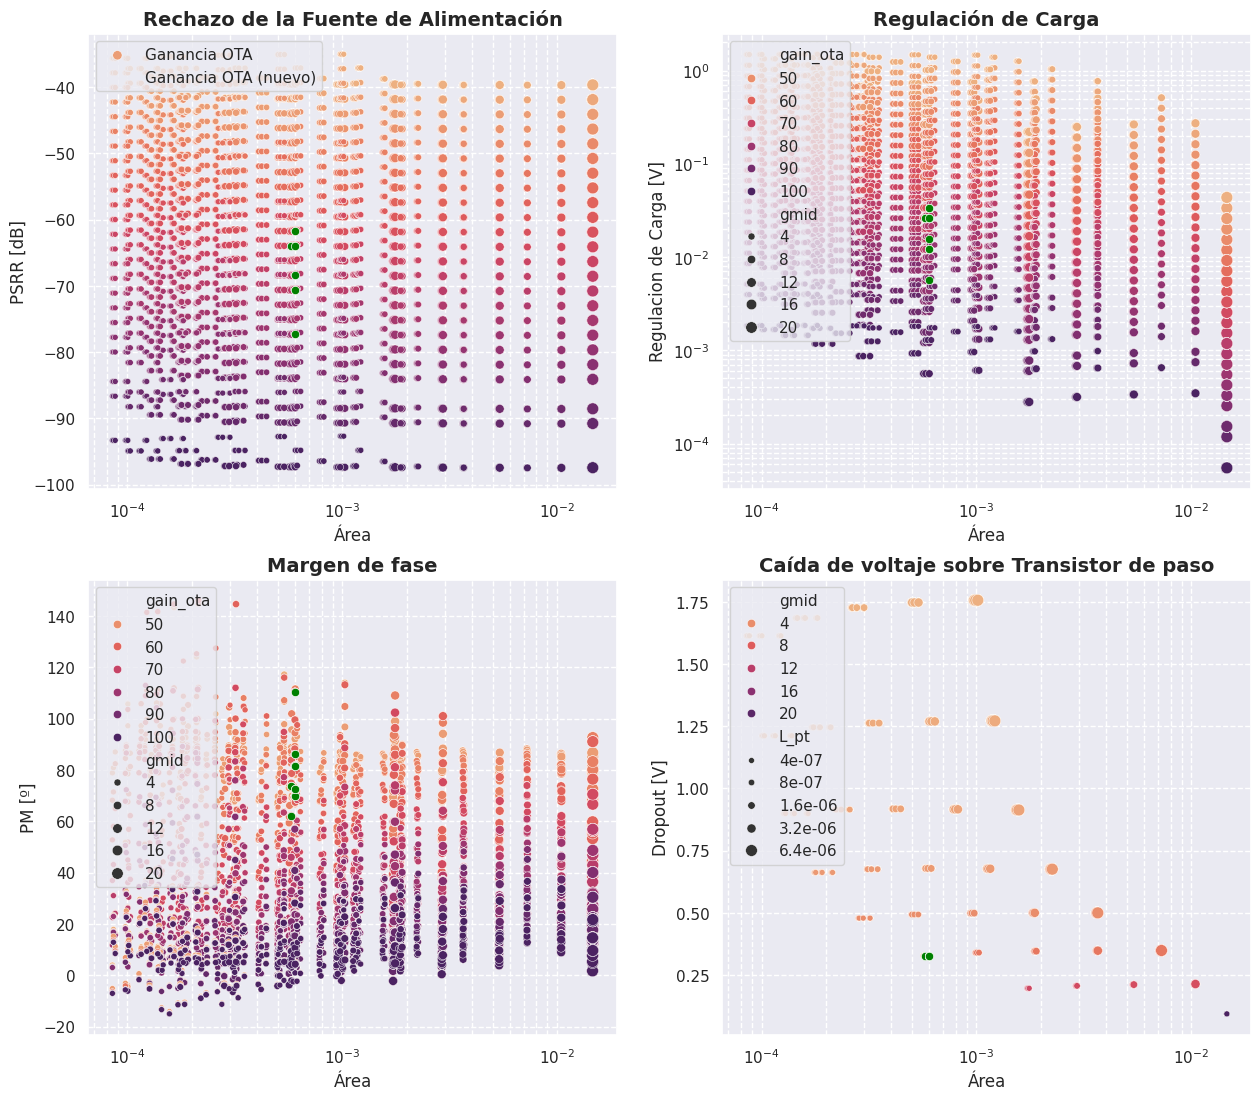

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(15, 13))
sns.scatterplot(ax=axs[0,0], data=ldo_df, x='area', y='psrr', palette='flare', hue='gain_ota', rasterized=True, size='gmid')
sns.scatterplot(ax=axs[0,0], data=ldo_df_new, x='area', y='psrr', c='green')
sns.scatterplot(ax=axs[0,1], data=ldo_df, x='area', y='loadreg', palette='flare', rasterized=True, hue='gain_ota', size='gmid')
sns.scatterplot(ax=axs[0,1], data=ldo_df_new, x='area', y='loadreg', c='green')
sns.scatterplot(ax=axs[1,1], data=ldo_df, x='area', y=('dropout'), palette='flare', hue='gmid', rasterized=True, size=('L_pt'))
sns.scatterplot(ax=axs[1,1], data=ldo_df_new, x='area', y=('dropout'), c='green')
sns.scatterplot(ax=axs[1,0], data=ldo_df, x='area', y="phase_margin_LDO_wc", palette='flare', hue="gain_ota", rasterized=True, size='gmid')
sns.scatterplot(ax=axs[1,0], data=ldo_df_new, x='area', y="phase_margin_LDO_wc", c='green')

axs[0,0].set_title(r"Rechazo de la Fuente de Alimentación", fontsize=14, weight='bold')
axs[0,0].set_xlabel(r"Área")
axs[0,0].set_ylabel(r"PSRR [dB]")
axs[0,0].locator_params(axis='x', nbins=10) 
axs[0,0].legend(loc = 'upper right')

axs[0,1].set_title(r"Regulación de Carga", fontsize=14, weight='bold')
axs[0,1].set_xlabel(r"Área")
axs[0,1].set_ylabel(r"Regulacion de Carga [V]")
axs[0,1].legend(loc = 'upper right')

axs[1,1].set_xlabel(r"Área")
axs[1,1].set_ylabel(r"Dropout [V]")
axs[1,1].set_title(r"Caída de voltaje sobre Transistor de paso", fontsize=14, weight='bold')
axs[1,1].legend(loc = 'upper right')

axs[1,0].set_title(r"Margen de fase", fontsize=14, weight='bold')
axs[1,0].set_xlabel(r"Área")
axs[1,0].set_ylabel(r"PM [º]")
axs[1,0].legend(loc = 'upper right')
#fig.suptitle(r"Ganancias intrínsecas", fontsize=24, y=1.1)

axs[0,0].set_xscale('log')
axs[0,1].set_xscale('log')
axs[1,0].set_xscale('log')
axs[1,1].set_xscale('log')

axs[0,1].set_yscale('log')



axs[0,0].grid(True,which="both",ls="--")  
axs[0,1].grid(True,which="both",ls="--")  
axs[1,0].grid(True,which="both",ls="--")  
axs[1,1].grid(True,which="both",ls="--")  

sns.move_legend(axs[0,0], "upper left")
sns.move_legend(axs[0,1], "upper left")
sns.move_legend(axs[1,0], "upper left")
sns.move_legend(axs[1,1], "upper left")

plt.savefig('ldo_explore_raw_ihp.pdf')

# OTA exploration (derivation)

## Case 2

/tmp/ipykernel_55836/3872070470.py:37: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[1].legend(loc = 'upper right')
/tmp/ipykernel_55836/3872070470.py:42: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[2].legend(loc = 'upper right')


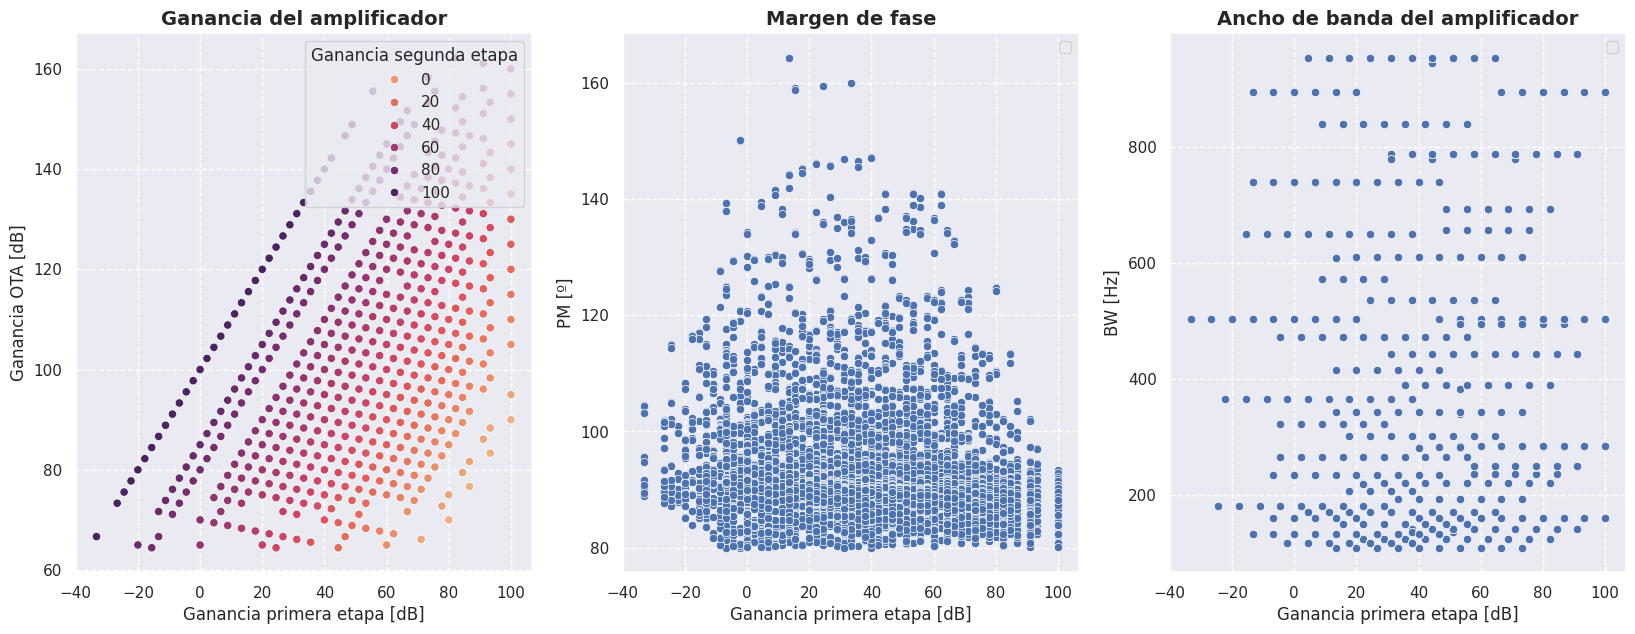

In [41]:
ota_df = pd.read_csv("data/IHP_lv_ota_exploration1_case1_98_10_10.csv")

ota_df_wc = pd.read_csv("data/IHP_lv_ota_exploration1_case2_98_10_10.csv")

ota_df['gain_1stage'] = 20*np.log10(ota_df[('Ra_1stage')]*ota_df[('gma_1stage')])
ota_df['gain_2stage'] = 20*np.log10(ota_df[('Ra_2stage')]*ota_df[('gma_2stage')])

ota_df["Cin"] = ota_df[("Cin_2stage")]+ota_df[("gma_2stage")]*ota_df[("Ra_2stage")]*ota_df[("Cc")]

ota_df["bw"] = 1/(2*np.pi*ota_df[("Ra_1stage")]*(ota_df[("Cin_2stage")]+ota_df[("gma_2stage")]*ota_df[("Ra_2stage")]*ota_df[("Cc")]))

ota_df["phase_margin_OTA_wc"]=ota_df_wc["phase_margin_OTA"]

ota_df["Cc_area"] = ota_df[("W_cc")]+ota_df[("L_cc")]
ota_df['gain'] = 20*np.log10(ota_df['gain_OTA'])
ota_df["gain_wc"] = 20*np.log10(ota_df_wc['gain_OTA'])

ota_df_new = ota_df[((ota_df["bw"]>500) & (ota_df["bw"]<1000) & (ota_df["gain"]>64.44) & (ota_df["phase_margin_OTA_wc"]>60) & (ota_df["phase_margin_OTA"]>80)) 
                                                        | ((ota_df["bw"]>100) & (ota_df["bw"]<1000) & (ota_df["gain"]>73.33) & (ota_df["phase_margin_OTA_wc"]>60) & (ota_df["phase_margin_OTA"]>80))]
#ota_df_new = ota_df
ota_df_new.sort_values(by=["gain_1stage", "phase_margin_OTA"] , ascending=True)

fig, axs = plt.subplots(1, 3, figsize=(20, 7))
sns.scatterplot(ax=axs[0], data=ota_df_new, x='gain_1stage', y='gain', palette='flare', hue="gain_2stage")
sns.scatterplot(ax=axs[1], data=ota_df_new, x="gain_1stage", y="phase_margin_OTA")
sns.scatterplot(ax=axs[2], data=ota_df_new, x="gain_1stage", y="bw")

axs[0].set_title(r"Ganancia del amplificador", fontsize=14, weight='bold')
axs[0].set_xlabel(r"Ganancia primera etapa [dB]")
axs[0].set_ylabel(r"Ganancia OTA [dB]")
axs[0].locator_params(axis='x', nbins=10) 
axs[0].legend(loc = 'upper right')

axs[1].set_title(r"Margen de fase", fontsize=14, weight='bold')
axs[1].set_xlabel(r"Ganancia primera etapa [dB]")
axs[1].set_ylabel(r"PM [º]")
axs[1].legend(loc = 'upper right')

axs[2].set_xlabel(r"Ganancia primera etapa [dB]")
axs[2].set_ylabel(r"BW [Hz]")
axs[2].set_title(r"Ancho de banda del amplificador", fontsize=14, weight='bold')
axs[2].legend(loc = 'upper right')

axs[0].grid(True,which="both",ls="--")  
axs[1].grid(True,which="both",ls="--")  
axs[2].grid(True,which="both",ls="--")  

sns.move_legend(axs[0], "upper right",title="Ganancia segunda etapa")

plt.savefig('ota_explore_raw.pdf', dpi=120)

# OTA 1stage

## Case 2

In [ ]:
OTA_1stage_macro.ext_mask = None

OTA_1stage_macro.primitives = [diffpair_wc, activeload_wc, currentsource]
OTA_1stage_macro.submacromodels = [] 
OTA_1stage_macro.num_level_exp = -1
OTA_1stage_macro.specifications = [gain_1stage_OTA, rout_1stage_OTA, gm_1stage_OTA]
OTA_1stage_macro.opt_specifications = [gain_1stage_OTA]
OTA_1stage_macro.is_primitive = 0
OTA_1stage_macro.run_pareto = True

_, _, _, ota_1stage_df_wc, mask = dfs(OTA_1stage_macro, debug = False)

## Case 1

In [ ]:
OTA_1stage_macro.ext_mask = mask

OTA_1stage_macro.primitives = [diffpair, activeload, currentsource]
OTA_1stage_macro.submacromodels = [] 
OTA_1stage_macro.num_level_exp = -1
OTA_1stage_macro.specifications = [gain_1stage_OTA, rout_1stage_OTA, gm_1stage_OTA]
OTA_1stage_macro.opt_specifications = [gain_1stage_OTA]
OTA_1stage_macro.is_primitive = 0
OTA_1stage_macro.run_pareto = True

ota_1stage_results, ota_1stage_axes, ota_1stage_primouts, ota_1stage_df, _ = dfs(OTA_1stage_macro, debug = False)

## Filtering

In [ ]:
ota_1stage_df_wc["gain"] = 20*np.log10(ota_1stage_df_wc["gain_1stage"])
ota_1stage_df_wc.sort_values(by=Symbol("W_cs"))

In [ ]:
ota_1stage_df["gain"] = 20*np.log10(ota_1stage_df["gain_1stage"])
ota_1stage_df["gain_wc"] = ota_1stage_df_wc["gain"]

ota_1stage_df = ota_1stage_df.dropna()

mask = (ota_1stage_df[Symbol("W_cs")]>3e-6) & (ota_1stage_df[Symbol("W_cs")]<3e-4)
ota_1stage_df_new = ota_1stage_df[mask]

In [ ]:
ota_1stage_df_new.to_csv("data/IHP_lv_ota_1stage_case1_98_10_10.csv", index=False)

In [ ]:
ota_1stage_df_wc = ota_1stage_df_wc[mask]
ota_1stage_df_wc

In [ ]:
ota_1stage_df_wc.to_csv("data/IHP_lv_ota_1stage_case2_98_10_10.csv", index=False)

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
sns.scatterplot(ax=axs[0], data=ota_1stage_df_new, x="area", y="gain", hue="gain_wc", palette='flare')
sns.scatterplot(ax=axs[1], data=ota_1stage_df_new, x=Symbol("Rdiff_1"), y=Symbol("Raload_1"), hue="rout_1stage", palette='flare')

axs[0].set_title(r"Ganancia de primera etapa", fontsize=14, weight='bold')
axs[0].set_xlabel(r"Area [m]")
axs[0].set_ylabel(r"Ganancia [dB]")
axs[0].locator_params(axis='x', nbins=10) 
axs[0].legend(loc = 'upper right')

axs[1].set_title(r"Resistencia de salida primera etapa", fontsize=14, weight='bold')
axs[1].set_xlabel(r"Ro par diferencial simple $[\Omega]$")
axs[1].set_ylabel(r"Ro carga activa simple $[\Omega]$")
axs[1].legend(loc = 'upper right')

axs[0].set_xscale('log')

axs[0].grid(True,which="both",ls="--")  
axs[1].grid(True,which="both",ls="--")  

sns.move_legend(axs[1], "upper right",title="rout_1stage")
sns.move_legend(axs[0], "upper right",title="ganancia_caso2")

plt.savefig('ota_1stage_explore_ihp.pdf')

# OTA exploration 2

In [113]:
ota_1stage_df_new = pd.read_csv("data/IHP_lv_ota_1stage_case1_98_10_10.csv")
ota_1stage_df_wc = pd.read_csv("data/IHP_lv_ota_1stage_case2_98_10_10.csv")

In [114]:
OTA_1stage_primitive = Primitive(parameters={
    Symbol("Ra_1stage"): ota_1stage_df_new["rout_1stage"].values,
    Symbol("gma_1stage"): ota_1stage_df_new["gm_1stage"].values})
OTA_1stage_primitive.outputs = {
    Symbol("W_diff"): ota_1stage_df_new[("W_diff")].values,
    Symbol("L_diff"): ota_1stage_df_new[("L_diff")].values,
    Symbol("vout_1stage"): ota_1stage_df_new[("vout_1stage")].values,
    Symbol("W_al"): ota_1stage_df_new[("W_al")].values,
    Symbol("L_al"): ota_1stage_df_new[("L_al")].values,
    Symbol("W_cs"): ota_1stage_df_new[("W_cs")].values,
    Symbol("L_cs"): ota_1stage_df_new[("L_cs")].values,
    Symbol("vgs_cs"): ota_1stage_df_new[("vgs_cs")].values}

OTA_1stage_primitive_wc = Primitive(parameters={
    Symbol("Ra_1stage"): ota_1stage_df_wc["rout_1stage"].values,
    Symbol("gma_1stage"): ota_1stage_df_wc["gm_1stage"].values})
OTA_1stage_primitive_wc.outputs = {
    Symbol("W_diff"): ota_1stage_df_wc[("W_diff")].values,
    Symbol("L_diff"): ota_1stage_df_wc[("L_diff")].values,
    Symbol("vout_1stage"): ota_1stage_df_wc[("vout_1stage")].values,
    Symbol("W_al"): ota_1stage_df_wc[("W_al")].values,
    Symbol("L_al"): ota_1stage_df_wc[("L_al")].values,
    Symbol("W_cs"): ota_1stage_df_wc[("W_cs")].values,
    Symbol("L_cs"): ota_1stage_df_wc[("L_cs")].values,
    Symbol("vgs_cs"): ota_1stage_df_wc[("vgs_cs")].values}

In [115]:
phase_margin_OTA.parametros = {
    Symbol("V1"): 0,
    Symbol("Vpos"): 1,
    Symbol("Cin_pt"): Cin_pt_wc}           

OTA_macro.ext_mask = None

OTA_macro.primitives = [OTA_1stage_primitive_wc, Cc_primitive]
OTA_macro.submacromodels = [OTA_2stage_macro]
OTA_macro.num_level_exp = 1
OTA_macro.specifications = [gain_OTA, rout_OTA, gm_OTA]
OTA_macro.opt_specifications = [gain_OTA]
OTA_macro.is_primitive = 0
OTA_macro.run_pareto = False

ota_results, ota_axes, ota_primouts, ota_df_wc, ota_df_wc_mask = dfs(OTA_macro, debug = False)

############################################
Starting the exploration of:  OpAmp_2stage
Netlist:  OpAmp_2stage
Running MNA... 
MNA of gain_OTA took: 0.02525472640991211
   net1  vss  vpos  vout  net2
0     1    0     2     3     4
[['vout', 'vpos']]
Netlist:  OpAmp_2stage_rout
Running MNA... 
MNA of rout_OTA took: 0.021083831787109375
   net1  vss  vpos  vout  net2  vr
0     1    0     2     3     4   5
[['vout', 'vr']]
Netlist:  OpAmp_2stage
Running MNA... 
MNA of gm_OTA took: 0.018342971801757812
   net1  vss  vpos  vout  net2
0     1    0     2     3     4
[['vout', 'vpos']]
older order of submacros:  [<sstadex.models.macromodel.Macromodel object at 0x7f591501a770>]
new order of submacros:  [<sstadex.models.macromodel.Macromodel object at 0x7f591501a770>]
in eval
-Ra_1stage*Ra_2stage*gma_1stage*gma_2stage
lambdify variables: (Ra_2stage, gma_2stage, Cin_2stage, Ra_1stage, gma_1stage, Cc, Rc) <function _lambdifygenerated at 0x7f590feaa050>
#### creating the primods_list ####
primmods_

In [116]:
phase_margin_OTA.parametros = {
    Symbol("V1"): 0,
    Symbol("Vpos"): 1,
    Symbol("Cin_pt"): Cin_pt}    

OTA_macro.ext_mask = ota_df_wc_mask

OTA_macro.primitives = [OTA_1stage_primitive, Cc_primitive]
OTA_macro.submacromodels = [OTA_2stage_macro]
OTA_macro.num_level_exp = 1
OTA_macro.specifications = [gain_OTA, rout_OTA, gm_OTA]
OTA_macro.opt_specifications = [gain_OTA]
OTA_macro.is_primitive = 0
OTA_macro.run_pareto = False

ota_results, ota_axes, ota_primouts, ota_df, _ = dfs(OTA_macro, debug = False)

############################################
Starting the exploration of:  OpAmp_2stage
Netlist:  OpAmp_2stage
Running MNA... 
MNA of gain_OTA took: 0.02108287811279297
   net1  vss  vpos  vout  net2
0     1    0     2     3     4
[['vout', 'vpos']]
Netlist:  OpAmp_2stage_rout
Running MNA... 
MNA of rout_OTA took: 0.02705693244934082
   net1  vss  vpos  vout  net2  vr
0     1    0     2     3     4   5
[['vout', 'vr']]
Netlist:  OpAmp_2stage
Running MNA... 
MNA of gm_OTA took: 0.0259857177734375
   net1  vss  vpos  vout  net2
0     1    0     2     3     4
[['vout', 'vpos']]
older order of submacros:  [<sstadex.models.macromodel.Macromodel object at 0x7f591501a770>]
new order of submacros:  [<sstadex.models.macromodel.Macromodel object at 0x7f591501a770>]
in eval
-Ra_1stage*Ra_2stage*gma_1stage*gma_2stage
lambdify variables: (Ra_2stage, gma_2stage, Cin_2stage, Ra_1stage, gma_1stage, Cc, Rc) <function _lambdifygenerated at 0x7f58b8fe9240>
#### creating the primods_list ####
primmods_out

In [119]:
len(ota_df)

1281250

In [120]:
len(ota_df_wc)

1281250

In [125]:
ota_df["gain"] = 20*np.log10(ota_df["gain_OTA"])
ota_df["gain_wc"] = 20*np.log10(ota_df_wc["gain_OTA"])

ota_df["gain_2stage"] = 20*np.log10(ota_df[Symbol('Ra_2stage')]*ota_df[Symbol('gma_2stage')])
ota_df["bw"] = 1/(2*np.pi*ota_df[Symbol("Ra_1stage")]*(ota_df[Symbol("Cin_2stage")]+ota_df[Symbol("gma_2stage")]*ota_df[Symbol("Ra_2stage")]*ota_df[Symbol("Cc")]))

mask = ((ota_df["gain"]>73.333) & (ota_df["bw"]>100) & (ota_df["bw"]<1000) & (ota_df["gain"]<90)) | ((ota_df["gain"]>64.44) & (ota_df["bw"]>500)& (ota_df["bw"]<1000) & (ota_df["gain"]<90))

ota_df_new = ota_df[mask]
ota_df_new.sort_values(by=["gain_2stage"])


Ra_2stage  gma_2stage    Cin_2stage      Ra_1stage  gma_1stage  \
410927   1000000.0    0.000056  1.000000e-16  989747.706266    0.000049   
410928   1000000.0    0.000056  1.000000e-16  989762.308248    0.000049   
410929   1000000.0    0.000056  1.000000e-16  989772.979901    0.000049   
410935   1000000.0    0.000056  1.000000e-16  989747.706266    0.000049   
410936   1000000.0    0.000056  1.000000e-16  989762.308248    0.000049   
...            ...         ...           ...            ...         ...   
1144911   100000.0    0.010000  1.778279e-15  247139.685963    0.000111   
1144910   100000.0    0.010000  1.778279e-15  189308.164916    0.000123   
1140855   100000.0    0.010000  1.778279e-15  247139.685963    0.000111   
1140854   100000.0    0.010000  1.778279e-15  189308.164916    0.000123   
1140964   100000.0    0.010000  1.778279e-15  190826.709913    0.000123   

                   Cc            Rc      gain_OTA   rout_OTA    gm_OTA  ...  \
410927   3.162278e-12   1000.000000   2731.681616  1000000.0  0.002732  ...   
410928   3.162278e-12   1000.000000   2731.657671  1000000.0  0.002732  ...   
410929   3.162278e-12   1000.000000   2731.640171  1000000.0  0.002732  ...   
410935   3.162278e-12   1000.000000   2731.681616  1000000.0  0.002732  ...   
410936   3.162278e-12   1000.000000   2731.657671  1000000.0  0.002732  ...   
...               ...           ...           ...        ...       ...  ...   
1144911  3.162278e-12  31622.776602  27435.025615   100000.0  0.274350  ...   
1144910  3.162278e-12  31622.776602  23275.054706   100000.0  0.232751  ...   
1140855  3.162278e-12   3162.277660  27435.025615   100000.0  0.274350  ...   
1140854  3.162278e-12   3162.277660  23275.054706   100000.0  0.232751  ...   
1140964  3.162278e-12   3162.277660  23473.794935   100000.0  0.234738  ...   

         vgs_cs      W_cc      L_cc      W_rc          L_rc      area  \
410927    0.350  0.000046  0.000046  0.000001  5.000000e-07  0.000318   
410928    0.350  0.000046  0.000046  0.000001  5.000000e-07  0.000323   
410929    0.350  0.000046  0.000046  0.000001  5.000000e-07  0.000331   
410935    0.350  0.000046  0.000046  0.000001  5.000000e-07  0.000318   
410936    0.350  0.000046  0.000046  0.000001  5.000000e-07  0.000323   
...         ...       ...       ...       ...           ...       ...   
1144911   0.475  0.000046  0.000046  0.000007  5.000000e-07  0.000129   
1144910   0.475  0.000046  0.000046  0.000007  5.000000e-07  0.000133   
1140855   0.475  0.000046  0.000046  0.000002  5.000000e-07  0.000124   
1140854   0.475  0.000046  0.000046  0.000002  5.000000e-07  0.000128   
1140964   0.475  0.000046  0.000046  0.000002  5.000000e-07  0.000134   

              gain    gain_wc  gain_2stage          bw  
410927   68.728602  68.711446         35.0  904.264296  
410928   68.728525  68.711370         35.0  904.250955  
410929   68.728470  68.711314         35.0  904.241206  
410935   68.728602  68.717631         35.0  904.264296  
410936   68.728525  68.717555         35.0  904.250955  
...            ...        ...          ...         ...  
1144911  88.766107  88.652418         60.0  203.646709  
1144910  87.337814  87.201646         60.0  265.858495  
1140855  88.766107  88.738204         60.0  203.646709  
1140854  87.337814  87.305074         60.0  265.858495  
1140964  87.411666  87.378265         60.0  263.742868  

[60300 rows x 27 columns]

In [126]:
ota_df_wc_new = ota_df_wc[mask]

In [127]:
len(ota_df_new)

60300

In [128]:
len(ota_df_wc_new)

60300

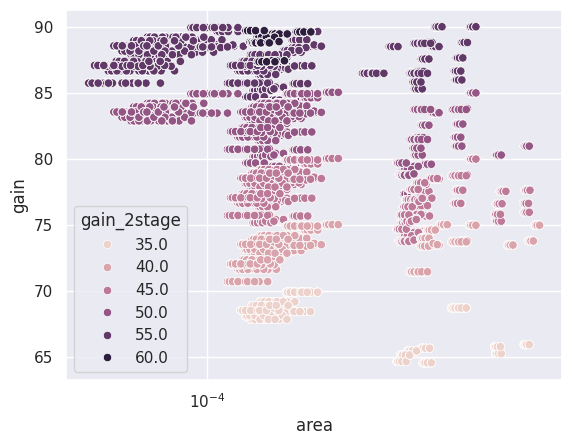

In [129]:
sns.scatterplot(data=ota_df_new, x="area", y="gain", hue="gain_2stage")
plt.xscale("log")

In [130]:
OTA_2stage_primitive_wc = Primitive(parameters={Symbol("Ra_2stage"): ota_df_wc_new[Symbol("Ra_2stage")].values,
                                  Symbol("gma_2stage"): ota_df_wc_new[Symbol("gma_2stage")].values,
                                  Symbol("Cin_2stage"): ota_df_wc_new[Symbol("Cin_2stage")].values,

                                  Symbol("Ra_1stage"): ota_df_wc_new[Symbol("Ra_1stage")].values,
                                  Symbol("gma_1stage"): ota_df_wc_new[Symbol("gma_1stage")].values,

                                  Symbol("Cc"): ota_df_wc_new[Symbol("Cc")].values,
                                  Symbol("Rc"): ota_df_wc_new[Symbol("Rc")].values,})
OTA_2stage_primitive_wc.outputs = {
    
    Symbol("W_diff"): ota_df_wc_new[Symbol("W_diff")].values,
    Symbol("L_diff"): ota_df_wc_new[Symbol("L_diff")].values,
    Symbol("vout_1stage"): ota_df_wc_new[Symbol("vout_1stage")].values,
    Symbol("W_al"): ota_df_wc_new[Symbol("W_al")].values,
    Symbol("L_al"): ota_df_wc_new[Symbol("L_al")].values,
    Symbol("W_cs"): ota_df_wc_new[Symbol("W_cs")].values,
    Symbol("L_cs"): ota_df_wc_new[Symbol("L_cs")].values,
    Symbol("vgs_cs"): ota_df_wc_new[Symbol("vgs_cs")].values,
    
    Symbol("W_cc"): ota_df_wc_new[Symbol("W_cc")].values,
    Symbol("L_cc"): ota_df_wc_new[Symbol("L_cc")].values,
    
    Symbol("W_rc"): ota_df_wc_new[Symbol("W_rc")].values,
    Symbol("L_rc"): ota_df_wc_new[Symbol("L_rc")].values}



phase_margin_OTA.parametros = {
    Symbol("V1"): 0,
    Symbol("Vpos"): 1,
    Symbol("Cin_pt"): Cin_pt_wc}    

OTA_macro.ext_mask = None

OTA_macro.primitives = [OTA_2stage_primitive_wc]
OTA_macro.submacromodels = []
OTA_macro.num_level_exp = 1
OTA_macro.specifications = [gain_OTA, rout_OTA, gm_OTA, phase_margin_OTA]
OTA_macro.opt_specifications = [gain_OTA]
OTA_macro.is_primitive = 0
OTA_macro.run_pareto = False

_, _, _, ota_df_wc, mask_ota_df_wc = dfs(OTA_macro, debug = False)

############################################
Starting the exploration of:  OpAmp_2stage
Netlist:  OpAmp_2stage
Running MNA... 
MNA of gain_OTA took: 0.02531576156616211
   net1  vss  vpos  vout  net2
0     1    0     2     3     4
[['vout', 'vpos']]
Netlist:  OpAmp_2stage_rout
Running MNA... 
MNA of rout_OTA took: 0.020532846450805664
   net1  vss  vpos  vout  net2  vr
0     1    0     2     3     4   5
[['vout', 'vr']]
Netlist:  OpAmp_2stage
Running MNA... 
MNA of gm_OTA took: 0.01975417137145996
   net1  vss  vpos  vout  net2
0     1    0     2     3     4
[['vout', 'vpos']]
Netlist:  OpAmp_2stage
Running MNA... 
MNA of phase_margin_OTA took: 0.018410444259643555
   net1  vss  vpos  vout  net2
0     1    0     2     3     4
[['vout', 'vpos']]
older order of submacros:  []
new order of submacros:  []
[]
in eval
-Ra_1stage*Ra_2stage*gma_1stage*gma_2stage
lambdify variables: (Ra_2stage, gma_2stage, Cin_2stage, Ra_1stage, gma_1stage, Cc, Rc) <function _lambdifygenerated at 0x7f590c0896c0

In [131]:
ota_df_wc.to_csv("data/IHP_lv_ota_exploration2_case2_98_10_10_v1.csv", index=False)

In [132]:
OTA_2stage_primitive = Primitive(parameters={Symbol("Ra_2stage"): ota_df_new[Symbol("Ra_2stage")].values,
                                  Symbol("gma_2stage"): ota_df_new[Symbol("gma_2stage")].values,
                                  Symbol("Cin_2stage"): ota_df_new[Symbol("Cin_2stage")].values,

                                  Symbol("Ra_1stage"): ota_df_new[Symbol("Ra_1stage")].values,
                                  Symbol("gma_1stage"): ota_df_new[Symbol("gma_1stage")].values,

                                  Symbol("Cc"): ota_df_new[Symbol("Cc")].values,
                                  Symbol("Rc"): ota_df_new[Symbol("Rc")].values,})
OTA_2stage_primitive.outputs = {
    
    Symbol("W_diff"): ota_df_new[Symbol("W_diff")].values,
    Symbol("L_diff"): ota_df_new[Symbol("L_diff")].values,
    Symbol("vout_1stage"): ota_df_new[Symbol("vout_1stage")].values,
    Symbol("W_al"): ota_df_new[Symbol("W_al")].values,
    Symbol("L_al"): ota_df_new[Symbol("L_al")].values,
    Symbol("W_cs"): ota_df_new[Symbol("W_cs")].values,
    Symbol("L_cs"): ota_df_new[Symbol("L_cs")].values,
    Symbol("vgs_cs"): ota_df_new[Symbol("vgs_cs")].values,
    
    Symbol("W_cc"): ota_df_new[Symbol("W_cc")].values,
    Symbol("L_cc"): ota_df_new[Symbol("L_cc")].values,
    
    Symbol("W_rc"): ota_df_new[Symbol("W_rc")].values,
    Symbol("L_rc"): ota_df_new[Symbol("L_rc")].values}

phase_margin_OTA.parametros = {
    Symbol("V1"): 0,
    Symbol("Vpos"): 1,
    Symbol("Cin_pt"): Cin_pt}    

OTA_macro.ext_mask = mask_ota_df_wc

OTA_macro.primitives = [OTA_2stage_primitive]
OTA_macro.submacromodels = []
OTA_macro.num_level_exp = 1
OTA_macro.specifications = [gain_OTA, rout_OTA, gm_OTA, phase_margin_OTA]
OTA_macro.opt_specifications = [gain_OTA]
OTA_macro.is_primitive = 0
OTA_macro.run_pareto = False

ota_results, ota_axes, ota_primouts, ota_df, _ = dfs(OTA_macro, debug = False)

############################################
Starting the exploration of:  OpAmp_2stage
Netlist:  OpAmp_2stage
Running MNA... 
MNA of gain_OTA took: 0.03230929374694824
   net1  vss  vpos  vout  net2
0     1    0     2     3     4
[['vout', 'vpos']]
Netlist:  OpAmp_2stage_rout
Running MNA... 
MNA of rout_OTA took: 0.026309967041015625
   net1  vss  vpos  vout  net2  vr
0     1    0     2     3     4   5
[['vout', 'vr']]
Netlist:  OpAmp_2stage
Running MNA... 
MNA of gm_OTA took: 0.018976211547851562
   net1  vss  vpos  vout  net2
0     1    0     2     3     4
[['vout', 'vpos']]
Netlist:  OpAmp_2stage
Running MNA... 
MNA of phase_margin_OTA took: 0.018521785736083984
   net1  vss  vpos  vout  net2
0     1    0     2     3     4
[['vout', 'vpos']]
older order of submacros:  []
new order of submacros:  []
[]
in eval
-Ra_1stage*Ra_2stage*gma_1stage*gma_2stage
lambdify variables: (Ra_2stage, gma_2stage, Cin_2stage, Ra_1stage, gma_1stage, Cc, Rc) <function _lambdifygenerated at 0x7f59023ec79

In [133]:
ota_df.to_csv("data/IHP_lv_ota_exploration2_case1_98_10_10_v1.csv", index=False)

In [117]:
ota_df_wc = pd.read_csv("data/IHP_lv_ota_exploration2_case2_98_10_10_v1.csv")
ota_df = pd.read_csv("data/IHP_lv_ota_exploration2_case1_98_10_10_v1.csv")

In [118]:
len(ota_df_wc)

60300

In [119]:
len(ota_df)

60300

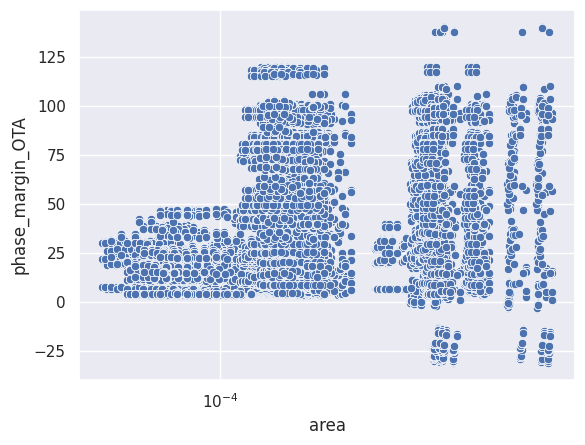

In [120]:
ota_df_wc["gain"] = 20*np.log10(ota_df_wc["gain_OTA"])
sns.scatterplot(data=ota_df_wc, x="area", y="phase_margin_OTA")
plt.xscale("log")

In [121]:
ota_df["gain"] = 20*np.log10(ota_df["gain_OTA"])
ota_df["gain_wc"] = 20*np.log10(ota_df_wc["gain_OTA"])

ota_df["gain_1stage"] = 20*np.log10(ota_df[("Ra_1stage")]*ota_df[("gma_1stage")])
ota_df["gain_2stage"] = 20*np.log10(ota_df[("Ra_2stage")]*ota_df[("gma_2stage")])
ota_df["bw"] = 1/(2*np.pi*ota_df[("Ra_1stage")]*(ota_df[("Cin_2stage")]+ota_df[("gma_2stage")]*ota_df[("Ra_2stage")]*ota_df[("Cc")]))

ota_df["bw_wc"] = 1/(2*np.pi*ota_df_wc[("Ra_1stage")]*(ota_df_wc[("Cin_2stage")]+ota_df_wc[("gma_2stage")]*ota_df_wc[("Ra_2stage")]*ota_df_wc[("Cc")]))

ota_df["phase_margin_OTA_wc"] = ota_df_wc["phase_margin_OTA"]

ota_df_new = ota_df[((ota_df["bw"]>500) & (ota_df["bw"]<1000) & (ota_df["gain"]>64.44) & (ota_df["phase_margin_OTA_wc"]>60) & (ota_df["phase_margin_OTA"]>80)) 
                                                        | ((ota_df["bw"]>100) & (ota_df["bw"]<1000) & (ota_df["gain"]>73.33) & (ota_df["phase_margin_OTA_wc"]>60) & (ota_df["phase_margin_OTA"]>80))]
ota_df_new

Ra_2stage  gma_2stage    Cin_2stage      Ra_1stage  gma_1stage  \
8110   1000000.0    0.000056  1.000000e-16  248148.426225    0.000132   
8111   1000000.0    0.000056  1.000000e-16  303220.554140    0.000114   
8112   1000000.0    0.000056  1.000000e-16  248148.426225    0.000132   
8113   1000000.0    0.000056  1.000000e-16  303220.554140    0.000114   
8114   1000000.0    0.000056  1.000000e-16  248148.426225    0.000132   
...          ...         ...           ...            ...         ...   
59971   100000.0    0.010000  5.623413e-13  249755.995336    0.000111   
59973   100000.0    0.010000  5.623413e-13  249755.995336    0.000111   
59975   100000.0    0.010000  5.623413e-13  249755.995336    0.000111   
59977   100000.0    0.010000  5.623413e-13  249755.995336    0.000111   
59979   100000.0    0.010000  5.623413e-13  249755.995336    0.000111   

                 Cc        Rc      gain_OTA   rout_OTA    gm_OTA  ...  \
8110   1.778279e-11  100000.0   1838.546387  1000000.0  0.001839  ...   
8111   1.778279e-11  100000.0   1950.973028  1000000.0  0.001951  ...   
8112   1.778279e-11  100000.0   1838.546387  1000000.0  0.001839  ...   
8113   1.778279e-11  100000.0   1950.973028  1000000.0  0.001951  ...   
8114   1.778279e-11  100000.0   1838.546387  1000000.0  0.001839  ...   
...             ...       ...           ...        ...       ...  ...   
59971  3.162278e-12   10000.0  27741.689391   100000.0  0.277417  ...   
59973  3.162278e-12   10000.0  27741.689391   100000.0  0.277417  ...   
59975  3.162278e-12   10000.0  27741.689391   100000.0  0.277417  ...   
59977  3.162278e-12   10000.0  27741.689391   100000.0  0.277417  ...   
59979  3.162278e-12   10000.0  27741.689391   100000.0  0.277417  ...   

           W_rc          L_rc      area       gain    gain_wc  gain_1stage  \
8110   0.000012  5.000000e-07  0.000403  65.289492  65.272315    30.289492   
8111   0.000012  5.000000e-07  0.000401  65.805025  65.787290    30.805025   
8112   0.000012  5.000000e-07  0.000403  65.289492  65.281196    30.289492   
8113   0.000012  5.000000e-07  0.000401  65.805025  65.796473    30.805025   
8114   0.000012  5.000000e-07  0.000403  65.289492  65.284181    30.289492   
...         ...           ...       ...        ...        ...          ...   
59971  0.000004  5.000000e-07  0.000132  88.862658  88.745482    28.862658   
59973  0.000004  5.000000e-07  0.000132  88.862658  88.781475    28.862658   
59975  0.000004  5.000000e-07  0.000132  88.862658  88.804728    28.862658   
59977  0.000004  5.000000e-07  0.000132  88.862658  88.822243    28.862658   
59979  0.000004  5.000000e-07  0.000132  88.862658  88.833905    28.862658   

       gain_2stage          bw       bw_wc  phase_margin_OTA_wc  
8110          35.0  641.369883  642.632026            81.825405  
8111          35.0  524.881724  525.967699            80.894457  
8112          35.0  641.369883  641.978279            81.823479  
8113          35.0  524.881724  525.404511            80.892473  
8114          35.0  641.369883  641.759091            81.822833  
...            ...         ...         ...                  ...  
59971         60.0  201.477701  203.797795            89.048050  
59973         60.0  201.477701  203.086273            89.047916  
59975         60.0  201.477701  202.628836            89.047830  
59977         60.0  201.477701  202.281204            89.047765  
59979         60.0  201.477701  202.049109            89.047721  

[11635 rows x 31 columns]

/tmp/ipykernel_55836/3093679510.py:18: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[1].legend(loc = 'upper right')
/tmp/ipykernel_55836/3093679510.py:23: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[2].legend(loc = 'upper right')


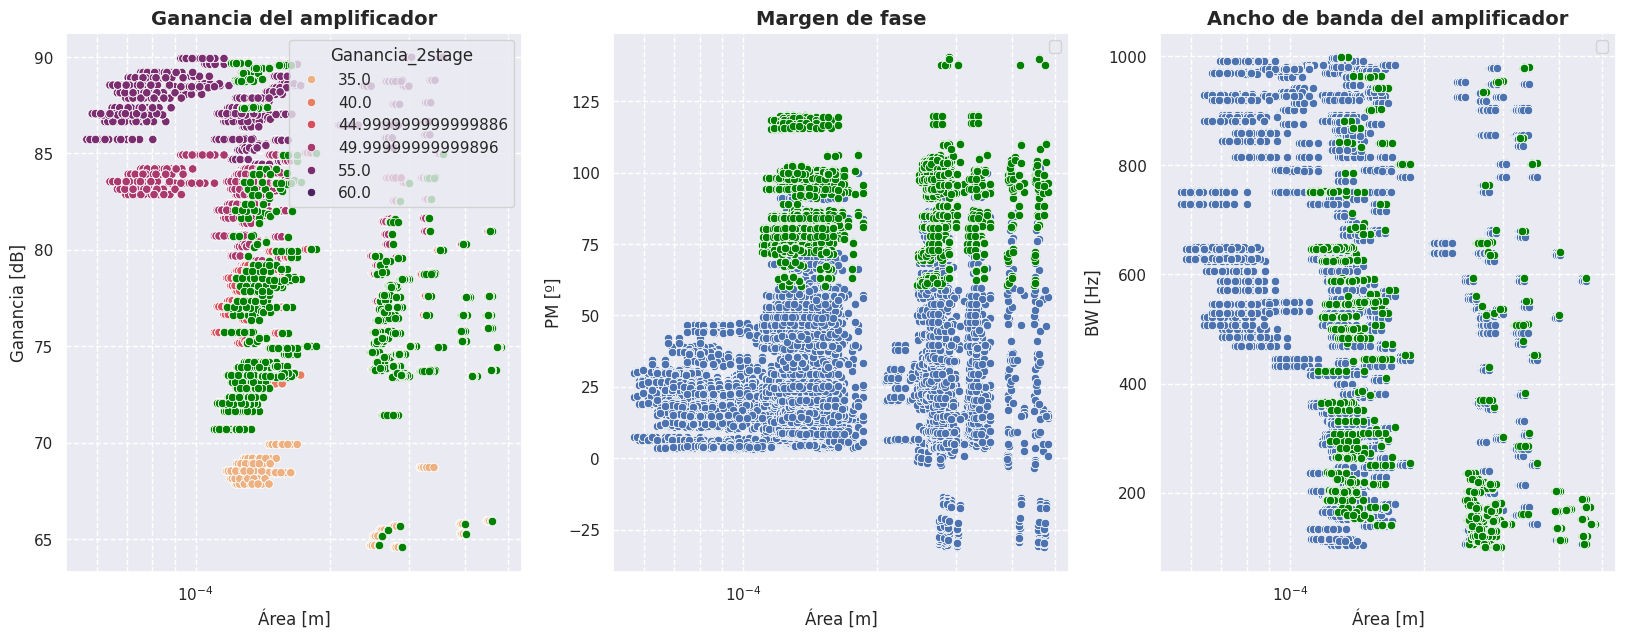

In [122]:


fig, axs = plt.subplots(1, 3, figsize=(20, 7))
sns.scatterplot(ax=axs[0], data=ota_df, x='area', y='gain', palette='flare', hue="gain_2stage", rasterized=True)
sns.scatterplot(ax=axs[0], data=ota_df_new, x='area', y='gain', color="green", rasterized=True)
sns.scatterplot(ax=axs[1], data=ota_df, x="area", y="phase_margin_OTA_wc", rasterized=True)
sns.scatterplot(ax=axs[1], data=ota_df_new, x="area", y="phase_margin_OTA_wc", color="green", rasterized=True)
sns.scatterplot(ax=axs[2], data=ota_df, x="area", y="bw", rasterized=True)
sns.scatterplot(ax=axs[2], data=ota_df_new, x="area", y="bw", color="green", rasterized=True)

axs[0].set_title(r"Ganancia del amplificador", fontsize=14, weight='bold')
axs[0].set_xlabel(r"Área [m]")
axs[0].set_ylabel(r"Ganancia [dB]")
axs[0].locator_params(axis='x', nbins=10) 
axs[0].legend(loc = 'upper right', title="Ganancia_2stage")

axs[1].set_title(r"Margen de fase", fontsize=14, weight='bold')
axs[1].set_xlabel(r"Área [m]")
axs[1].set_ylabel(r"PM [º]")
axs[1].legend(loc = 'upper right')

axs[2].set_xlabel(r"Área [m]")
axs[2].set_ylabel(r"BW [Hz]")
axs[2].set_title(r"Ancho de banda del amplificador", fontsize=14, weight='bold')
axs[2].legend(loc = 'upper right')

axs[0].grid(True,which="both",ls="--")  
axs[1].grid(True,which="both",ls="--")  
axs[2].grid(True,which="both",ls="--")  

axs[0].set_xscale('log')
axs[1].set_xscale('log')
axs[2].set_xscale('log')

plt.savefig('ota_explore_raw_2.pdf')

# OTA 2stage 

## Case 2

In [ ]:
OTA_2stage_macro.ext_mask = None

OTA_2stage_macro.primitives = [stage2_t_wc, stage2_cs_wc]
OTA_2stage_macro.submacromodels = [] 
OTA_2stage_macro.num_level_exp = -1
OTA_2stage_macro.specifications = [gain_2stage_OTA, rout_2stage_OTA, gm_2stage_OTA]
OTA_2stage_macro.opt_specifications = [gain_2stage_OTA]
OTA_2stage_macro.is_primitive = 0
OTA_2stage_macro.run_pareto = True

_, _, _, ota_2stage_df_wc, mask = dfs(OTA_2stage_macro, debug = False)

In [ ]:
ota_2stage_df_wc["gain"] = 20*np.log10(ota_2stage_df_wc["gain_2stage"])
ota_2stage_df_wc_new = ota_2stage_df_wc[(ota_2stage_df_wc[Symbol("W_2stage")]<3e-4) & (ota_2stage_df_wc[Symbol("W_2stage")]>3e-6) & (ota_2stage_df_wc[Symbol("W_cs_2stage")]<3e-4) & (ota_2stage_df_wc[Symbol("W_cs_2stage")]>3e-6)]
ota_2stage_df_wc_new.sort_values(by=Symbol("W_2stage"))

## Case 1

In [ ]:
OTA_2stage_macro.ext_mask = mask

OTA_2stage_macro.primitives = [stage2_t, stage2_cs]
OTA_2stage_macro.submacromodels = [] 
OTA_2stage_macro.num_level_exp = -1
OTA_2stage_macro.specifications = [gain_2stage_OTA, rout_2stage_OTA, gm_2stage_OTA]
OTA_2stage_macro.opt_specifications = [gain_2stage_OTA]
OTA_2stage_macro.is_primitive = 0
OTA_2stage_macro.run_pareto = True

_, _, _, ota_2stage_df, _ = dfs(OTA_2stage_macro, debug = False)

In [ ]:
ota_2stage_df["gain"] = 20*np.log10(ota_2stage_df["gain_2stage"])
ota_2stage_df_new = ota_2stage_df[(ota_2stage_df_wc[Symbol("W_2stage")]<3e-4) & (ota_2stage_df_wc[Symbol("W_2stage")]>3e-6) & (ota_2stage_df_wc[Symbol("W_cs_2stage")]<3e-4) & (ota_2stage_df_wc[Symbol("W_cs_2stage")]>3e-6)]
ota_2stage_df_new

## filtering

In [ ]:
mask = (ota_2stage_df["gain"]>35)
ota_2stage_df_new = ota_2stage_df_new[mask]
ota_2stage_df_wc_new = ota_2stage_df_wc_new[mask]

In [ ]:
ota_2stage_df_new["gain_wc"] = ota_2stage_df_wc_new["gain"]
ota_2stage_df_new

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
sns.scatterplot(ax=axs[0], data=ota_2stage_df_new, x="area", y="gain", palette='flare', hue="gain_wc")
sns.scatterplot(ax=axs[1], data=ota_2stage_df_new, x=Symbol("Ro_2stage"), y=Symbol("Rcs_2stage"), hue="rout_2stage", palette='flare')

axs[0].set_title(r"Ganancia de primera etapa", fontsize=14, weight='bold')
axs[0].set_xlabel(r"Area [m]")
axs[0].set_ylabel(r"Ganancia [dB]")
axs[0].locator_params(axis='x', nbins=10) 
axs[0].legend(loc = 'upper right')

axs[1].set_title(r"Resistencia de salida primera etapa", fontsize=14, weight='bold')
axs[1].set_xlabel(r"Ro fuente común $[\Omega]$")
axs[1].set_ylabel(r"Ro fuente de corriente $[\Omega]$")
axs[1].legend(loc = 'upper right')

axs[0].set_xscale('log')

axs[0].grid(True,which="both",ls="--")  
axs[1].grid(True,which="both",ls="--")  

sns.move_legend(axs[1], "lower right",title="rout_1stage")
sns.move_legend(axs[0], "upper left",title="ganancia_caso2")

plt.savefig('ota_2stage_explore_ihp.pdf')

In [ ]:
ota_2stage_df_new.to_csv("data/IHP_lv_ota_2stage_case1.csv", index=False)
ota_2stage_df_wc_new.to_csv("data/IHP_lv_ota_2stage_case2.csv", index=False)

# OTA exploration 3

In [91]:
ota_1stage_df_new = pd.read_csv("data/IHP_lv_ota_1stage_case1_98_10_10.csv")
#ota_1stage_df_new = ota_1stage_df_new.sort_values(by="gain").drop_duplicates()
print(len(ota_1stage_df_new))

ota_2stage_df_new = pd.read_csv("data/IHP_lv_ota_2stage_case1.csv")
#mask = (ota_2stage_df_new["Ro_2stage"]>10000) & (ota_2stage_df_new["Ro_2stage"]<1000000)
#ota_2stage_df_new = ota_2stage_df_new[mask]
print(len(ota_2stage_df_new))

410
46


In [92]:
ota_1stage_df_wc_new = pd.read_csv("data/IHP_lv_ota_1stage_case2_98_10_10.csv")
print(len(ota_1stage_df_wc_new))

ota_2stage_df_wc_new = pd.read_csv("data/IHP_lv_ota_2stage_case2.csv")
#ota_2stage_df_wc_new = ota_2stage_df_wc_new[mask]
print(len(ota_2stage_df_wc_new))

410
46


In [93]:
Cc_mask = []
for c in Cc_primitive.parameters[Symbol("Cc")]:
    if c>3e-12 and c<2e-11:
        Cc_mask.append(True)
    else:
        Cc_mask.append(False)

In [94]:
Cc = np.logspace(-13, -10, 5)
Rc = np.logspace(3, 5, 5)

mesh = np.meshgrid(Cc, Rc)

Cc_primitive = Primitive(parameters={Symbol("Cc"): mesh[0].flatten()[Cc_mask],
                                     Symbol("Rc"): mesh[1].flatten()[Cc_mask]})
Cc_primitive.outputs = {
    Symbol("W_cc"): np.sqrt(Cc_primitive.parameters[Symbol("Cc")]/1.5e-15)*1e-6,
    Symbol("L_cc"): np.sqrt(Cc_primitive.parameters[Symbol("Cc")]/1.5e-15)*1e-6,
    Symbol("W_rc"): np.sqrt(Cc_primitive.parameters[Symbol("Rc")]/(1360*0.5))*1e-6,
    Symbol("L_rc"): np.repeat(0.5e-6, len(mesh[0].flatten()[Cc_mask]))}

IndexError: boolean index did not match indexed array along axis 0; size of axis is 25 but size of corresponding boolean axis is 10

In [95]:
OTA_2stage_primitive_wc = Primitive(parameters={Symbol("Ra_2stage"): ota_2stage_df_wc_new["rout_2stage"].values,
                                  Symbol("gma_2stage"): ota_2stage_df_wc_new["gm_2stage"].values,
                                  Symbol("Cin_2stage"): ota_2stage_df_wc_new["Cin_2stage"].values})

OTA_2stage_primitive_wc.outputs = {
    Symbol("W_2stage"): ota_2stage_df_wc_new["W_2stage"].values,
    Symbol("L_2stage"): ota_2stage_df_wc_new["L_2stage"].values,
    Symbol("vin_2stage"): ota_2stage_df_wc_new["vin_2stage"].values,
    Symbol("W_cs_2stage"): ota_2stage_df_wc_new["W_cs_2stage"].values,
    Symbol("L_cs_2stage"): ota_2stage_df_wc_new["L_cs_2stage"].values,
    Symbol("vgs_cs_2stage"): ota_2stage_df_wc_new["vgs_cs_2stage"].values}

OTA_1stage_primitive_wc = Primitive(parameters={
    Symbol("Ra_1stage"): ota_1stage_df_wc_new["rout_1stage"].values,
    Symbol("gma_1stage"): ota_1stage_df_wc_new["gm_1stage"].values})
OTA_1stage_primitive_wc.outputs = {
    Symbol("W_diff"): ota_1stage_df_wc_new["W_diff"].values,
    Symbol("L_diff"): ota_1stage_df_wc_new["L_diff"].values,
    Symbol("vout_1stage"): ota_1stage_df_wc_new["vout_1stage"].values,
    Symbol("W_al"): ota_1stage_df_wc_new["W_al"].values,
    Symbol("L_al"): ota_1stage_df_wc_new["L_al"].values,
    Symbol("W_cs"): ota_1stage_df_wc_new["W_cs"].values,
    Symbol("L_cs"): ota_1stage_df_wc_new["L_cs"].values,
    Symbol("vgs_cs"): ota_1stage_df_wc_new["vgs_cs"].values}

In [96]:
phase_margin_OTA.parametros = {
    Symbol("V1"): 0,
    Symbol("Vpos"): 1,
    Symbol("Cin_pt"): Cin_pt_wc}

rout_OTA.parametros = {
    Symbol("Vpos"): 0,
    Symbol("Vr"): 1,
    Symbol("s"): 0,
    Symbol("Rr"): 1000,
    Symbol("Cin_pt"): Cin_pt_wc}

OTA_macro.ext_mask = None

OTA_macro.primitives = [OTA_2stage_primitive_wc, OTA_1stage_primitive_wc, Cc_primitive]
OTA_macro.submacromodels = []
OTA_macro.num_level_exp = 1
OTA_macro.specifications = [gain_OTA, rout_OTA, gm_OTA]
OTA_macro.opt_specifications = [gain_OTA]
OTA_macro.is_primitive = 0
OTA_macro.run_pareto = False

_, _, _, ota_df_wc, mask_ota = dfs(OTA_macro, debug = False)

############################################
Starting the exploration of:  OpAmp_2stage
Netlist:  OpAmp_2stage
Running MNA... 
MNA of gain_OTA took: 0.07070231437683105
   net1  vss  vpos  vout  net2
0     1    0     2     3     4
[['vout', 'vpos']]
Netlist:  OpAmp_2stage_rout
Running MNA... 
MNA of rout_OTA took: 0.04190850257873535
   net1  vss  vpos  vout  net2  vr
0     1    0     2     3     4   5
[['vout', 'vr']]
Netlist:  OpAmp_2stage
Running MNA... 
MNA of gm_OTA took: 0.0409390926361084
   net1  vss  vpos  vout  net2
0     1    0     2     3     4
[['vout', 'vpos']]
older order of submacros:  []
new order of submacros:  []
[]
in eval
-Ra_1stage*Ra_2stage*gma_1stage*gma_2stage
lambdify variables: (Ra_2stage, gma_2stage, Cin_2stage, Ra_1stage, gma_1stage, Cc, Rc) <function _lambdifygenerated at 0x7f4e51d6d510>
#### creating the primods_list ####
primmods_outputs_aux:  {W_2stage: array([2.88903081e-04, 2.88903081e-04, 2.88903081e-04, 2.88903081e-04,
       1.47182503e-05, 2.85590

sizing:  (18, 188600)
[Ra_2stage, gma_2stage, Cin_2stage, Ra_1stage, gma_1stage, Cc, Rc]
output name:  W_2stage
output name:  L_2stage
output name:  vin_2stage
output name:  W_cs_2stage
output name:  L_cs_2stage
output name:  vgs_cs_2stage
output name:  W_diff
output name:  L_diff
output name:  vout_1stage
output name:  W_al
output name:  L_al
output name:  W_cs
output name:  L_cs
output name:  vgs_cs
output name:  W_cc
output name:  L_cc
output name:  W_rc
output name:  L_rc
End of the exploration of:  OpAmp_2stage


In [97]:
ota_df_wc["gain"] = 20*np.log10(ota_df_wc["gain_OTA"])
ota_df_wc

Ra_2stage  gma_2stage    Cin_2stage      Ra_1stage  gma_1stage  \
450     549942.150049    0.000292  3.478333e-13  247661.057652    0.000132   
451     549942.150049    0.000292  3.478333e-13  247661.057652    0.000132   
452     549942.150049    0.000292  3.478333e-13  247661.057652    0.000132   
453     549942.150049    0.000292  3.478333e-13  247661.057652    0.000132   
454     549942.150049    0.000292  3.478333e-13  247661.057652    0.000132   
...               ...         ...           ...            ...         ...   
188585  951304.740784    0.000107  3.170943e-12  626360.410105    0.000090   
188586  951304.740784    0.000107  3.170943e-12  626360.410105    0.000090   
188587  951304.740784    0.000107  3.170943e-12  626360.410105    0.000090   
188588  951304.740784    0.000107  3.170943e-12  626360.410105    0.000090   
188589  951304.740784    0.000107  3.170943e-12  626360.410105    0.000090   

                  Cc             Rc     gain_OTA       rout_OTA    gm_OTA  \
450     3.162278e-12    1000.000000  5241.257798  549942.150049  0.009531   
451     1.778279e-11    1000.000000  5241.257798  549942.150049  0.009531   
452     3.162278e-12    3162.277660  5241.257798  549942.150049  0.009531   
453     1.778279e-11    3162.277660  5241.257798  549942.150049  0.009531   
454     3.162278e-12   10000.000000  5241.257798  549942.150049  0.009531   
...              ...            ...          ...            ...       ...   
188585  1.778279e-11   10000.000000  5737.080209  951304.740784  0.006031   
188586  3.162278e-12   31622.776602  5737.080209  951304.740784  0.006031   
188587  1.778279e-11   31622.776602  5737.080209  951304.740784  0.006031   
188588  3.162278e-12  100000.000000  5737.080209  951304.740784  0.006031   
188589  1.778279e-11  100000.000000  5737.080209  951304.740784  0.006031   

        ...          L_al      W_cs      L_cs  vgs_cs      W_cc      L_cc  \
450     ...  4.000000e-07  0.000004  0.000006   0.475  0.000046  0.000046   
451     ...  4.000000e-07  0.000004  0.000006   0.475  0.000109  0.000109   
452     ...  4.000000e-07  0.000004  0.000006   0.475  0.000046  0.000046   
453     ...  4.000000e-07  0.000004  0.000006   0.475  0.000109  0.000109   
454     ...  4.000000e-07  0.000004  0.000006   0.475  0.000046  0.000046   
...     ...           ...       ...       ...     ...       ...       ...   
188585  ...  6.400000e-06  0.000004  0.000006   0.475  0.000109  0.000109   
188586  ...  6.400000e-06  0.000004  0.000006   0.475  0.000046  0.000046   
188587  ...  6.400000e-06  0.000004  0.000006   0.475  0.000109  0.000109   
188588  ...  6.400000e-06  0.000004  0.000006   0.475  0.000046  0.000046   
188589  ...  6.400000e-06  0.000004  0.000006   0.475  0.000109  0.000109   

            W_rc          L_rc      area       gain  
450     0.000001  5.000000e-07  0.000566  74.388710  
451     0.000001  5.000000e-07  0.000692  74.388710  
452     0.000002  5.000000e-07  0.000567  74.388710  
453     0.000002  5.000000e-07  0.000693  74.388710  
454     0.000004  5.000000e-07  0.000569  74.388710  
...          ...           ...       ...        ...  
188585  0.000004  5.000000e-07  0.000377  75.173818  
188586  0.000007  5.000000e-07  0.000254  75.173818  
188587  0.000007  5.000000e-07  0.000380  75.173818  
188588  0.000012  5.000000e-07  0.000260  75.173818  
188589  0.000012  5.000000e-07  0.000386  75.173818  

[1820 rows x 30 columns]

In [98]:
OTA_2stage_primitive = Primitive(parameters={Symbol("Ra_2stage"): ota_2stage_df_new["rout_2stage"].values,
                                  Symbol("gma_2stage"): ota_2stage_df_new["gm_2stage"].values,
                                  Symbol("Cin_2stage"): ota_2stage_df_new["Cin_2stage"].values})

OTA_2stage_primitive.outputs = {
    Symbol("W_2stage"): ota_2stage_df_new["W_2stage"].values,
    Symbol("L_2stage"): ota_2stage_df_new["L_2stage"].values,
    Symbol("vin_2stage"): ota_2stage_df_new["vin_2stage"].values,
    Symbol("W_cs_2stage"): ota_2stage_df_new["W_cs_2stage"].values,
    Symbol("L_cs_2stage"): ota_2stage_df_new["L_cs_2stage"].values,
    Symbol("vgs_cs_2stage"): ota_2stage_df_new["vgs_cs_2stage"].values}

OTA_1stage_primitive = Primitive(parameters={
    Symbol("Ra_1stage"): ota_1stage_df_new["rout_1stage"].values,
    Symbol("gma_1stage"): ota_1stage_df_new["gm_1stage"].values})
OTA_1stage_primitive.outputs = {
    Symbol("W_diff"): ota_1stage_df_new["W_diff"].values,
    Symbol("L_diff"): ota_1stage_df_new["L_diff"].values,
    Symbol("vout_1stage"): ota_1stage_df_new["vout_1stage"].values,
    Symbol("W_al"): ota_1stage_df_new["W_al"].values,
    Symbol("L_al"): ota_1stage_df_new["L_al"].values,
    Symbol("W_cs"): ota_1stage_df_new["W_cs"].values,
    Symbol("L_cs"): ota_1stage_df_new["L_cs"].values,
    Symbol("vgs_cs"): ota_1stage_df_new["vgs_cs"].values}

In [99]:
phase_margin_OTA.parametros = {
    Symbol("V1"): 0,
    Symbol("Vpos"): 1,
    Symbol("Cin_pt"): Cin_pt}

rout_OTA.parametros = {
    Symbol("Vpos"): 0,
    Symbol("Vr"): 1,
    Symbol("s"): 0,
    Symbol("Rr"): 1000,
    Symbol("Cin_pt"): Cin_pt}

OTA_macro.ext_mask = mask_ota

OTA_macro.primitives = [OTA_2stage_primitive, OTA_1stage_primitive, Cc_primitive]
OTA_macro.submacromodels = []
OTA_macro.num_level_exp = 1
OTA_macro.specifications = [gain_OTA, rout_OTA, gm_OTA]
OTA_macro.opt_specifications = [gain_OTA]
OTA_macro.is_primitive = 0
OTA_macro.run_pareto = False

_, _, _, ota_df, _ = dfs(OTA_macro, debug = False)

############################################
Starting the exploration of:  OpAmp_2stage
Netlist:  OpAmp_2stage
Running MNA... 
MNA of gain_OTA took: 0.03391671180725098
   net1  vss  vpos  vout  net2
0     1    0     2     3     4
[['vout', 'vpos']]
Netlist:  OpAmp_2stage_rout
Running MNA... 
MNA of rout_OTA took: 0.03650712966918945
   net1  vss  vpos  vout  net2  vr
0     1    0     2     3     4   5
[['vout', 'vr']]
Netlist:  OpAmp_2stage
Running MNA... 
MNA of gm_OTA took: 0.034458160400390625
   net1  vss  vpos  vout  net2
0     1    0     2     3     4
[['vout', 'vpos']]
older order of submacros:  []
new order of submacros:  []
[]
in eval
-Ra_1stage*Ra_2stage*gma_1stage*gma_2stage
lambdify variables: (Ra_2stage, gma_2stage, Cin_2stage, Ra_1stage, gma_1stage, Cc, Rc) <function _lambdifygenerated at 0x7f4e51d6e3b0>
#### creating the primods_list ####
primmods_outputs_aux:  {W_2stage: array([2.88903081e-04, 2.88903081e-04, 2.88903081e-04, 2.88903081e-04,
       1.47182503e-05, 2.855

In [100]:
ota_df["gain"] = 20*np.log10(ota_df["gain_OTA"])
ota_df

Ra_2stage  gma_2stage    Cin_2stage      Ra_1stage  gma_1stage  \
450     6.375933e+05    0.000295  3.998863e-13  248148.426225    0.000132   
451     6.375933e+05    0.000295  3.998863e-13  248148.426225    0.000132   
452     6.375933e+05    0.000295  3.998863e-13  248148.426225    0.000132   
453     6.375933e+05    0.000295  3.998863e-13  248148.426225    0.000132   
454     6.375933e+05    0.000295  3.998863e-13  248148.426225    0.000132   
...              ...         ...           ...            ...         ...   
188585  1.063413e+06    0.000107  3.039681e-12  626684.898102    0.000090   
188586  1.063413e+06    0.000107  3.039681e-12  626684.898102    0.000090   
188587  1.063413e+06    0.000107  3.039681e-12  626684.898102    0.000090   
188588  1.063413e+06    0.000107  3.039681e-12  626684.898102    0.000090   
188589  1.063413e+06    0.000107  3.039681e-12  626684.898102    0.000090   

                  Cc             Rc     gain_OTA      rout_OTA    gm_OTA  ...  \
450     3.162278e-12    1000.000000  6144.101015  6.375933e+05  0.009636  ...   
451     1.778279e-11    1000.000000  6144.101015  6.375933e+05  0.009636  ...   
452     3.162278e-12    3162.277660  6144.101015  6.375933e+05  0.009636  ...   
453     1.778279e-11    3162.277660  6144.101015  6.375933e+05  0.009636  ...   
454     3.162278e-12   10000.000000  6144.101015  6.375933e+05  0.009636  ...   
...              ...            ...          ...           ...       ...  ...   
188585  1.778279e-11   10000.000000  6438.819697  1.063413e+06  0.006055  ...   
188586  3.162278e-12   31622.776602  6438.819697  1.063413e+06  0.006055  ...   
188587  1.778279e-11   31622.776602  6438.819697  1.063413e+06  0.006055  ...   
188588  3.162278e-12  100000.000000  6438.819697  1.063413e+06  0.006055  ...   
188589  1.778279e-11  100000.000000  6438.819697  1.063413e+06  0.006055  ...   

                L_al      W_cs      L_cs  vgs_cs      W_cc      L_cc  \
450     4.000000e-07  0.000004  0.000006   0.475  0.000046  0.000046   
451     4.000000e-07  0.000004  0.000006   0.475  0.000109  0.000109   
452     4.000000e-07  0.000004  0.000006   0.475  0.000046  0.000046   
453     4.000000e-07  0.000004  0.000006   0.475  0.000109  0.000109   
454     4.000000e-07  0.000004  0.000006   0.475  0.000046  0.000046   
...              ...       ...       ...     ...       ...       ...   
188585  6.400000e-06  0.000004  0.000006   0.475  0.000109  0.000109   
188586  6.400000e-06  0.000004  0.000006   0.475  0.000046  0.000046   
188587  6.400000e-06  0.000004  0.000006   0.475  0.000109  0.000109   
188588  6.400000e-06  0.000004  0.000006   0.475  0.000046  0.000046   
188589  6.400000e-06  0.000004  0.000006   0.475  0.000109  0.000109   

            W_rc          L_rc      area       gain  
450     0.000001  5.000000e-07  0.000566  75.769167  
451     0.000001  5.000000e-07  0.000692  75.769167  
452     0.000002  5.000000e-07  0.000567  75.769167  
453     0.000002  5.000000e-07  0.000693  75.769167  
454     0.000004  5.000000e-07  0.000569  75.769167  
...          ...           ...       ...        ...  
188585  0.000004  5.000000e-07  0.000377  76.176125  
188586  0.000007  5.000000e-07  0.000254  76.176125  
188587  0.000007  5.000000e-07  0.000380  76.176125  
188588  0.000012  5.000000e-07  0.000260  76.176125  
188589  0.000012  5.000000e-07  0.000386  76.176125  

[9100 rows x 30 columns]

In [101]:
ota_df["gain"] = 20*np.log10(ota_df["gain_OTA"])
ota_df["gain_wc"] = 20*np.log10(ota_df_wc["gain_OTA"])
ota_df = ota_df.dropna()
ota_df

Ra_2stage  gma_2stage    Cin_2stage      Ra_1stage  gma_1stage  \
450     6.375933e+05    0.000295  3.998863e-13  248148.426225    0.000132   
451     6.375933e+05    0.000295  3.998863e-13  248148.426225    0.000132   
452     6.375933e+05    0.000295  3.998863e-13  248148.426225    0.000132   
453     6.375933e+05    0.000295  3.998863e-13  248148.426225    0.000132   
454     6.375933e+05    0.000295  3.998863e-13  248148.426225    0.000132   
...              ...         ...           ...            ...         ...   
188585  1.063413e+06    0.000107  3.039681e-12  626684.898102    0.000090   
188586  1.063413e+06    0.000107  3.039681e-12  626684.898102    0.000090   
188587  1.063413e+06    0.000107  3.039681e-12  626684.898102    0.000090   
188588  1.063413e+06    0.000107  3.039681e-12  626684.898102    0.000090   
188589  1.063413e+06    0.000107  3.039681e-12  626684.898102    0.000090   

                  Cc             Rc     gain_OTA      rout_OTA    gm_OTA  ...  \
450     3.162278e-12    1000.000000  6144.101015  6.375933e+05  0.009636  ...   
451     1.778279e-11    1000.000000  6144.101015  6.375933e+05  0.009636  ...   
452     3.162278e-12    3162.277660  6144.101015  6.375933e+05  0.009636  ...   
453     1.778279e-11    3162.277660  6144.101015  6.375933e+05  0.009636  ...   
454     3.162278e-12   10000.000000  6144.101015  6.375933e+05  0.009636  ...   
...              ...            ...          ...           ...       ...  ...   
188585  1.778279e-11   10000.000000  6438.819697  1.063413e+06  0.006055  ...   
188586  3.162278e-12   31622.776602  6438.819697  1.063413e+06  0.006055  ...   
188587  1.778279e-11   31622.776602  6438.819697  1.063413e+06  0.006055  ...   
188588  3.162278e-12  100000.000000  6438.819697  1.063413e+06  0.006055  ...   
188589  1.778279e-11  100000.000000  6438.819697  1.063413e+06  0.006055  ...   

            W_cs      L_cs  vgs_cs      W_cc      L_cc      W_rc  \
450     0.000004  0.000006   0.475  0.000046  0.000046  0.000001   
451     0.000004  0.000006   0.475  0.000109  0.000109  0.000001   
452     0.000004  0.000006   0.475  0.000046  0.000046  0.000002   
453     0.000004  0.000006   0.475  0.000109  0.000109  0.000002   
454     0.000004  0.000006   0.475  0.000046  0.000046  0.000004   
...          ...       ...     ...       ...       ...       ...   
188585  0.000004  0.000006   0.475  0.000109  0.000109  0.000004   
188586  0.000004  0.000006   0.475  0.000046  0.000046  0.000007   
188587  0.000004  0.000006   0.475  0.000109  0.000109  0.000007   
188588  0.000004  0.000006   0.475  0.000046  0.000046  0.000012   
188589  0.000004  0.000006   0.475  0.000109  0.000109  0.000012   

                L_rc      area       gain    gain_wc  
450     5.000000e-07  0.000566  75.769167  74.388710  
451     5.000000e-07  0.000692  75.769167  74.388710  
452     5.000000e-07  0.000567  75.769167  74.388710  
453     5.000000e-07  0.000693  75.769167  74.388710  
454     5.000000e-07  0.000569  75.769167  74.388710  
...              ...       ...        ...        ...  
188585  5.000000e-07  0.000377  76.176125  75.173818  
188586  5.000000e-07  0.000254  76.176125  75.173818  
188587  5.000000e-07  0.000380  76.176125  75.173818  
188588  5.000000e-07  0.000260  76.176125  75.173818  
188589  5.000000e-07  0.000386  76.176125  75.173818  

[1820 rows x 31 columns]

In [102]:
ota_df_wc["gain"] = 20*np.log10(ota_df_wc["gain_OTA"])
ota_df_wc

Ra_2stage  gma_2stage    Cin_2stage      Ra_1stage  gma_1stage  \
450     549942.150049    0.000292  3.478333e-13  247661.057652    0.000132   
451     549942.150049    0.000292  3.478333e-13  247661.057652    0.000132   
452     549942.150049    0.000292  3.478333e-13  247661.057652    0.000132   
453     549942.150049    0.000292  3.478333e-13  247661.057652    0.000132   
454     549942.150049    0.000292  3.478333e-13  247661.057652    0.000132   
...               ...         ...           ...            ...         ...   
188585  951304.740784    0.000107  3.170943e-12  626360.410105    0.000090   
188586  951304.740784    0.000107  3.170943e-12  626360.410105    0.000090   
188587  951304.740784    0.000107  3.170943e-12  626360.410105    0.000090   
188588  951304.740784    0.000107  3.170943e-12  626360.410105    0.000090   
188589  951304.740784    0.000107  3.170943e-12  626360.410105    0.000090   

                  Cc             Rc     gain_OTA       rout_OTA    gm_OTA  \
450     3.162278e-12    1000.000000  5241.257798  549942.150049  0.009531   
451     1.778279e-11    1000.000000  5241.257798  549942.150049  0.009531   
452     3.162278e-12    3162.277660  5241.257798  549942.150049  0.009531   
453     1.778279e-11    3162.277660  5241.257798  549942.150049  0.009531   
454     3.162278e-12   10000.000000  5241.257798  549942.150049  0.009531   
...              ...            ...          ...            ...       ...   
188585  1.778279e-11   10000.000000  5737.080209  951304.740784  0.006031   
188586  3.162278e-12   31622.776602  5737.080209  951304.740784  0.006031   
188587  1.778279e-11   31622.776602  5737.080209  951304.740784  0.006031   
188588  3.162278e-12  100000.000000  5737.080209  951304.740784  0.006031   
188589  1.778279e-11  100000.000000  5737.080209  951304.740784  0.006031   

        ...          L_al      W_cs      L_cs  vgs_cs      W_cc      L_cc  \
450     ...  4.000000e-07  0.000004  0.000006   0.475  0.000046  0.000046   
451     ...  4.000000e-07  0.000004  0.000006   0.475  0.000109  0.000109   
452     ...  4.000000e-07  0.000004  0.000006   0.475  0.000046  0.000046   
453     ...  4.000000e-07  0.000004  0.000006   0.475  0.000109  0.000109   
454     ...  4.000000e-07  0.000004  0.000006   0.475  0.000046  0.000046   
...     ...           ...       ...       ...     ...       ...       ...   
188585  ...  6.400000e-06  0.000004  0.000006   0.475  0.000109  0.000109   
188586  ...  6.400000e-06  0.000004  0.000006   0.475  0.000046  0.000046   
188587  ...  6.400000e-06  0.000004  0.000006   0.475  0.000109  0.000109   
188588  ...  6.400000e-06  0.000004  0.000006   0.475  0.000046  0.000046   
188589  ...  6.400000e-06  0.000004  0.000006   0.475  0.000109  0.000109   

            W_rc          L_rc      area       gain  
450     0.000001  5.000000e-07  0.000566  74.388710  
451     0.000001  5.000000e-07  0.000692  74.388710  
452     0.000002  5.000000e-07  0.000567  74.388710  
453     0.000002  5.000000e-07  0.000693  74.388710  
454     0.000004  5.000000e-07  0.000569  74.388710  
...          ...           ...       ...        ...  
188585  0.000004  5.000000e-07  0.000377  75.173818  
188586  0.000007  5.000000e-07  0.000254  75.173818  
188587  0.000007  5.000000e-07  0.000380  75.173818  
188588  0.000012  5.000000e-07  0.000260  75.173818  
188589  0.000012  5.000000e-07  0.000386  75.173818  

[1820 rows x 30 columns]

In [103]:
mask = ota_df["gain"]>64.44
ota_df = ota_df[mask]
ota_df_wc = ota_df_wc[mask]

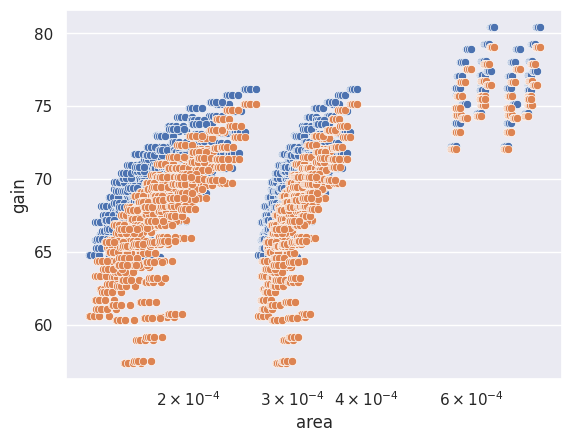

In [104]:
sns.scatterplot(data=ota_df, x="area", y="gain")
sns.scatterplot(data=ota_df_wc, x="area", y="gain")
plt.xscale("log")

In [105]:
ota_df["gain"] = 20*np.log10(ota_df["gain_OTA"])
ota_df["gain_wc"] = 20*np.log10(ota_df_wc["gain_OTA"])

ota_df["gain_1stage"] = 20*np.log10(ota_df[Symbol("Ra_1stage")]*ota_df[Symbol("gma_1stage")])
ota_df["gain_2stage"] = 20*np.log10(ota_df[Symbol("Ra_2stage")]*ota_df[Symbol("gma_2stage")])
ota_df["bw"] = 1/(2*np.pi*ota_df[Symbol("Ra_1stage")]*(ota_df[Symbol("Cin_2stage")]+ota_df[Symbol("gma_2stage")]*ota_df[Symbol("Ra_2stage")]*ota_df[Symbol("Cc")]))

ota_df["bw_2"] = 1/(2*np.pi*ota_df[Symbol("Ra_1stage")]*Cin_pt)

ota_df["bw_wc"] = 1/(2*np.pi*ota_df_wc[Symbol("Ra_1stage")]*(ota_df_wc[Symbol("Cin_2stage")]+ota_df_wc[Symbol("gma_2stage")]*ota_df_wc[Symbol("Ra_2stage")]*ota_df_wc[Symbol("Cc")]))

#ota_df["phase_margin_OTA_wc"] = ota_df_wc["phase_margin_OTA"]

ota_df_wc["gain"] =  20*np.log10(ota_df_wc["gain_OTA"])

ota_df_new = ota_df[((ota_df["bw"]>500) & (ota_df["bw"]<1000) & (ota_df["gain"]>64.44)) | ((ota_df["bw"]>100) & (ota_df["bw"]<1000) & (ota_df["gain"]>73.33))]
ota_df_wc_new = ota_df_wc[((ota_df["bw"]>500) & (ota_df["bw"]<1000) & (ota_df["gain"]>64.44)) | ((ota_df["bw"]>100) & (ota_df["bw"]<1000) & (ota_df["gain"]>73.33))]

ota_df_new.sort_values(by="gain")

/tmp/ipykernel_55836/838698729.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ota_df["gain"] = 20*np.log10(ota_df["gain_OTA"])
/tmp/ipykernel_55836/838698729.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ota_df["gain_wc"] = 20*np.log10(ota_df_wc["gain_OTA"])
/tmp/ipykernel_55836/838698729.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pyd

Ra_2stage  gma_2stage    Cin_2stage      Ra_1stage  gma_1stage  \
113109  480247.065913    0.000118  1.199986e-14  229379.099989    0.000129   
113107  480247.065913    0.000118  1.199986e-14  229379.099989    0.000129   
113105  480247.065913    0.000118  1.199986e-14  229379.099989    0.000129   
113101  480247.065913    0.000118  1.199986e-14  229379.099989    0.000129   
113103  480247.065913    0.000118  1.199986e-14  229379.099989    0.000129   
...               ...         ...           ...            ...         ...   
47374   637593.313972    0.000295  3.998863e-13  626366.437520    0.000090   
47370   637593.313972    0.000295  3.998863e-13  626366.437520    0.000090   
47376   637593.313972    0.000295  3.998863e-13  626366.437520    0.000090   
47372   637593.313972    0.000295  3.998863e-13  626366.437520    0.000090   
47378   637593.313972    0.000295  3.998863e-13  626366.437520    0.000090   

                  Cc             Rc      gain_OTA       rout_OTA    gm_OTA  \
113109  1.778279e-11  100000.000000   1682.393693  480247.065913  0.003503   
113107  1.778279e-11   31622.776602   1682.393693  480247.065913  0.003503   
113105  1.778279e-11   10000.000000   1682.393693  480247.065913  0.003503   
113101  1.778279e-11    1000.000000   1682.393693  480247.065913  0.003503   
113103  1.778279e-11    3162.277660   1682.393693  480247.065913  0.003503   
...              ...            ...           ...            ...       ...   
47374   3.162278e-12   10000.000000  10546.864491  637593.313972  0.016542   
47370   3.162278e-12    1000.000000  10546.864491  637593.313972  0.016542   
47376   3.162278e-12   31622.776602  10546.864491  637593.313972  0.016542   
47372   3.162278e-12    3162.277660  10546.864491  637593.313972  0.016542   
47378   3.162278e-12  100000.000000  10546.864491  637593.313972  0.016542   

        ...      W_rc          L_rc      area       gain    gain_wc  \
113109  ...  0.000012  5.000000e-07  0.000288  64.518553  60.327773   
113107  ...  0.000007  5.000000e-07  0.000282  64.518553  60.327773   
113105  ...  0.000004  5.000000e-07  0.000279  64.518553  60.327773   
113101  ...  0.000001  5.000000e-07  0.000277  64.518553  60.327773   
113103  ...  0.000002  5.000000e-07  0.000278  64.518553  60.327773   
...     ...       ...           ...       ...        ...        ...   
47374   ...  0.000004  5.000000e-07  0.000649  80.462467  79.073249   
47370   ...  0.000001  5.000000e-07  0.000646  80.462467  79.073249   
47376   ...  0.000007  5.000000e-07  0.000652  80.462467  79.073249   
47372   ...  0.000002  5.000000e-07  0.000647  80.462467  79.073249   
47378   ...  0.000012  5.000000e-07  0.000657  80.462467  79.073249   

        gain_1stage  gain_2stage          bw          bw_2        bw_wc  
113109    29.436906    35.081647  687.351364  14276.771807  1112.616318  
113107    29.436906    35.081647  687.351364  14276.771807  1112.616318  
113105    29.436906    35.081647  687.351364  14276.771807  1112.616318  
113101    29.436906    35.081647  687.351364  14276.771807  1112.616318  
113103    29.436906    35.081647  687.351364  14276.771807  1112.616318  
...             ...          ...         ...           ...          ...  
47374     34.982792    45.479675  427.283141   5228.238411   501.403154  
47370     34.982792    45.479675  427.283141   5228.238411   501.403154  
47376     34.982792    45.479675  427.283141   5228.238411   501.403154  
47372     34.982792    45.479675  427.283141   5228.238411   501.403154  
47378     34.982792    45.479675  427.283141   5228.238411   501.403154  

[520 rows x 36 columns]

/tmp/ipykernel_55836/4168062300.py:18: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[1].legend(loc = 'upper right')


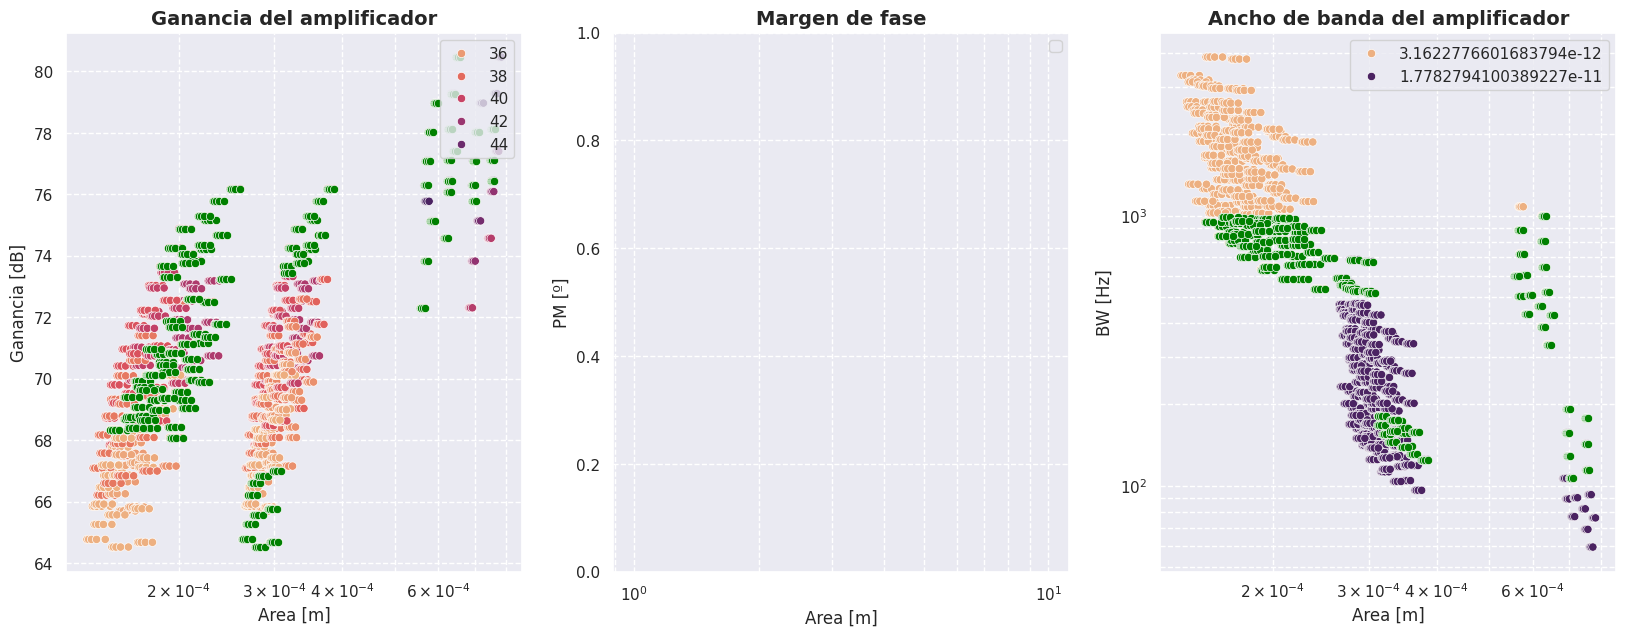

In [106]:
fig, axs = plt.subplots(1, 3, figsize=(20, 7))
sns.scatterplot(ax=axs[0], data=ota_df, x='area', y='gain', palette='flare', hue="gain_2stage")
sns.scatterplot(ax=axs[0], data=ota_df_new, x='area', y='gain', color="green")
#sns.scatterplot(ax=axs[1], data=ota_df, x="area", y="phase_margin_OTA", hue="phase_margin_OTA_wc", palette='flare')
#sns.scatterplot(ax=axs[1], data=ota_df_new, x="area", y="phase_margin_OTA", color="green")
sns.scatterplot(ax=axs[2], data=ota_df, x="area", y="bw", hue=Symbol("Cc"), hue_norm=LogNorm(), palette='flare')
sns.scatterplot(ax=axs[2], data=ota_df_new, x="area", y="bw", color="green")

axs[0].set_title(r"Ganancia del amplificador", fontsize=14, weight='bold')
axs[0].set_xlabel(r"Area [m]")
axs[0].set_ylabel(r"Ganancia [dB]")
axs[0].locator_params(axis='x', nbins=10) 
axs[0].legend(loc = 'upper right')

axs[1].set_title(r"Margen de fase", fontsize=14, weight='bold')
axs[1].set_xlabel(r"Area [m]")
axs[1].set_ylabel(r"PM [º]")
axs[1].legend(loc = 'upper right')

axs[2].set_xlabel(r"Area [m]")
axs[2].set_ylabel(r"BW [Hz]")
axs[2].set_title(r"Ancho de banda del amplificador", fontsize=14, weight='bold')
axs[2].legend(loc = 'upper right')

axs[0].grid(True,which="both",ls="--")  
axs[1].grid(True,which="both",ls="--")  
axs[2].grid(True,which="both",ls="--")  

axs[0].set_xscale('log')
axs[1].set_xscale('log')
axs[2].set_xscale('log')

axs[2].set_yscale('log')

#sns.move_legend(axs[0], "upper left",title="ganancia segunda etapa")

plt.savefig('ota_explore_raw_3.svg', dpi=120)

In [107]:
OTA_2stage_primitive_wc = Primitive(parameters={Symbol("Ra_2stage"): ota_df_wc[Symbol("Ra_2stage")].values,
                                  Symbol("gma_2stage"): ota_df_wc[Symbol("gma_2stage")].values,
                                  Symbol("Cin_2stage"): ota_df_wc[Symbol("Cin_2stage")].values,

                                  Symbol("Ra_1stage"): ota_df_wc[Symbol("Ra_1stage")].values,
                                  Symbol("gma_1stage"): ota_df_wc[Symbol("gma_1stage")].values,

                                  Symbol("Cc"): ota_df_wc[Symbol("Cc")].values,
                                  Symbol("Rc"): ota_df_wc[Symbol("Rc")].values,})

OTA_2stage_primitive_wc.outputs = {
    Symbol("W_2stage"): ota_df_wc[Symbol("W_2stage")].values,
    Symbol("L_2stage"): ota_df_wc[Symbol("L_2stage")].values,
    Symbol("vin_2stage"): ota_df_wc[Symbol("vin_2stage")].values,
    Symbol("W_cs_2stage"): ota_df_wc[Symbol("W_cs_2stage")].values,
    Symbol("L_cs_2stage"): ota_df_wc[Symbol("L_cs_2stage")].values,
    Symbol("vgs_cs_2stage"): ota_df_wc[Symbol("vgs_cs_2stage")].values,
    
    Symbol("W_diff"): ota_df_wc[Symbol("W_diff")].values,
    Symbol("L_diff"): ota_df_wc[Symbol("L_diff")].values,
    Symbol("vout_1stage"): ota_df_wc[Symbol("vout_1stage")].values,
    Symbol("W_al"): ota_df_wc[Symbol("W_al")].values,
    Symbol("L_al"): ota_df_wc[Symbol("L_al")].values,
    Symbol("W_cs"): ota_df_wc[Symbol("W_cs")].values,
    Symbol("L_cs"): ota_df_wc[Symbol("L_cs")].values,
    Symbol("vgs_cs"): ota_df_wc[Symbol("vgs_cs")].values,
    
    Symbol("W_cc"): ota_df_wc[Symbol("W_cc")].values,
    Symbol("L_cc"): ota_df_wc[Symbol("L_cc")].values,
    
    Symbol("W_rc"): ota_df_wc[Symbol("W_rc")].values,
    Symbol("L_rc"): ota_df_wc[Symbol("L_rc")].values}

In [108]:
phase_margin_OTA.parametros = {
    Symbol("V1"): 0,
    Symbol("Vpos"): 1,
    Symbol("Cin_pt"): Cin_pt_wc}    

OTA_macro.ext_mask = None

OTA_macro.primitives = [OTA_2stage_primitive_wc]
OTA_macro.submacromodels = []
OTA_macro.num_level_exp = 1
OTA_macro.specifications = [gain_OTA, rout_OTA, gm_OTA, phase_margin_OTA]
OTA_macro.opt_specifications = [gain_OTA]
OTA_macro.is_primitive = 0
OTA_macro.run_pareto = False

_, _, _, ota_df_wc, mask_ota = dfs(OTA_macro, debug = False)

############################################
Starting the exploration of:  OpAmp_2stage
Netlist:  OpAmp_2stage
Running MNA... 
MNA of gain_OTA took: 0.035360097885131836
   net1  vss  vpos  vout  net2
0     1    0     2     3     4
[['vout', 'vpos']]
Netlist:  OpAmp_2stage_rout
Running MNA... 
MNA of rout_OTA took: 0.05146288871765137
   net1  vss  vpos  vout  net2  vr
0     1    0     2     3     4   5
[['vout', 'vr']]
Netlist:  OpAmp_2stage
Running MNA... 
MNA of gm_OTA took: 0.03859710693359375
   net1  vss  vpos  vout  net2
0     1    0     2     3     4
[['vout', 'vpos']]
Netlist:  OpAmp_2stage
Running MNA... 
MNA of phase_margin_OTA took: 0.03944587707519531
   net1  vss  vpos  vout  net2
0     1    0     2     3     4
[['vout', 'vpos']]
older order of submacros:  []
new order of submacros:  []
[]
in eval
-Ra_1stage*Ra_2stage*gma_1stage*gma_2stage
lambdify variables: (Ra_2stage, gma_2stage, Cin_2stage, Ra_1stage, gma_1stage, Cc, Rc) <function _lambdifygenerated at 0x7f4e51b46440>

starting the return
Explore time: 20.623068809509277
eval:  [(4.01713631989208e-5*s - 5241.25779805281)/(3.205971536993e-20*s**3 + 1.02830187294784e-10*s**2 + 0.000246098254517034*s + 1)
 (0.00022590017615984*s - 5241.25779805281)/(1.80285028263518e-19*s**3 + 5.3138367836572e-10*s**2 + 0.000839395400477341*s + 1)
 (4.33309766435847e-6*s - 5241.25779805281)/(1.01381721705686e-19*s**3 + 1.03635491597908e-10*s**2 + 0.000246105092239374*s + 1)
 ...
 (-0.00227236946353283*s - 5737.08020934791)/(2.27376834882288e-16*s**3 + 2.82109141742045e-9*s**2 + 0.00136753521287317*s + 1)
 (-0.00164460682002687*s - 5737.08020934791)/(1.27863390645293e-16*s**3 + 8.78554493667643e-10*s**2 + 0.000412412300707651*s + 1)
 (-0.00924830378590999*s - 5737.08020934791)/(7.19028685388052e-16*s**3 + 3.0710461771781e-9*s**2 + 0.00136875115095801*s + 1)]
[15.54383737 20.18798365 17.92551167 ... 42.18769587 25.14296642
 51.08886909]
{'gain_OTA': 0.035360097885131836, 'rout_OTA': 0.05146288871765137, 'gm_OTA': 0.038597

In [109]:
OTA_2stage_primitive = Primitive(parameters={Symbol("Ra_2stage"): ota_df[Symbol("Ra_2stage")].values,
                                  Symbol("gma_2stage"): ota_df[Symbol("gma_2stage")].values,
                                  Symbol("Cin_2stage"): ota_df[Symbol("Cin_2stage")].values,

                                  Symbol("Ra_1stage"): ota_df[Symbol("Ra_1stage")].values,
                                  Symbol("gma_1stage"): ota_df[Symbol("gma_1stage")].values,

                                  Symbol("Cc"): ota_df[Symbol("Cc")].values,
                                  Symbol("Rc"): ota_df[Symbol("Rc")].values,})
OTA_2stage_primitive.outputs = {
    Symbol("W_2stage"): ota_df[Symbol("W_2stage")].values,
    Symbol("L_2stage"): ota_df[Symbol("L_2stage")].values,
    Symbol("vin_2stage"): ota_df[Symbol("vin_2stage")].values,
    Symbol("W_cs_2stage"): ota_df[Symbol("W_cs_2stage")].values,
    Symbol("L_cs_2stage"): ota_df[Symbol("L_cs_2stage")].values,
    Symbol("vgs_cs_2stage"): ota_df[Symbol("vgs_cs_2stage")].values,
    
    Symbol("W_diff"): ota_df[Symbol("W_diff")].values,
    Symbol("L_diff"): ota_df[Symbol("L_diff")].values,
    Symbol("vout_1stage"): ota_df[Symbol("vout_1stage")].values,
    Symbol("W_al"): ota_df[Symbol("W_al")].values,
    Symbol("L_al"): ota_df[Symbol("L_al")].values,
    Symbol("W_cs"): ota_df[Symbol("W_cs")].values,
    Symbol("L_cs"): ota_df[Symbol("L_cs")].values,
    Symbol("vgs_cs"): ota_df[Symbol("vgs_cs")].values,
    
    Symbol("W_cc"): ota_df[Symbol("W_cc")].values,
    Symbol("L_cc"): ota_df[Symbol("L_cc")].values,
    
    Symbol("W_rc"): ota_df[Symbol("W_rc")].values,
    Symbol("L_rc"): ota_df[Symbol("L_rc")].values}

In [110]:
phase_margin_OTA.parametros = {
    Symbol("V1"): 0,
    Symbol("Vpos"): 1,
    Symbol("Cin_pt"): Cin_pt}    

OTA_macro.ext_mask = mask_ota

OTA_macro.primitives = [OTA_2stage_primitive]
OTA_macro.submacromodels = []
OTA_macro.num_level_exp = 1
OTA_macro.specifications = [gain_OTA, rout_OTA, gm_OTA, phase_margin_OTA]
OTA_macro.opt_specifications = [gain_OTA]
OTA_macro.is_primitive = 0
OTA_macro.run_pareto = False

_, _, _, ota_df, _ = dfs(OTA_macro, debug = False)

############################################
Starting the exploration of:  OpAmp_2stage
Netlist:  OpAmp_2stage
Running MNA... 
MNA of gain_OTA took: 0.05854463577270508
   net1  vss  vpos  vout  net2
0     1    0     2     3     4
[['vout', 'vpos']]
Netlist:  OpAmp_2stage_rout
Running MNA... 
MNA of rout_OTA took: 0.050037384033203125
   net1  vss  vpos  vout  net2  vr
0     1    0     2     3     4   5
[['vout', 'vr']]
Netlist:  OpAmp_2stage
Running MNA... 
MNA of gm_OTA took: 0.034096479415893555
   net1  vss  vpos  vout  net2
0     1    0     2     3     4
[['vout', 'vpos']]
Netlist:  OpAmp_2stage
Running MNA... 
MNA of phase_margin_OTA took: 0.03519797325134277
   net1  vss  vpos  vout  net2
0     1    0     2     3     4
[['vout', 'vpos']]
older order of submacros:  []
new order of submacros:  []
[]
in eval
-Ra_1stage*Ra_2stage*gma_1stage*gma_2stage
lambdify variables: (Ra_2stage, gma_2stage, Cin_2stage, Ra_1stage, gma_1stage, Cc, Rc) <function _lambdifygenerated at 0x7f4e51b47d90

In [111]:
ota_df["gain"] = 20*np.log10(ota_df["gain_OTA"])
ota_df["gain_wc"] = 20*np.log10(ota_df_wc["gain_OTA"])

ota_df["gain_1stage"] = 20*np.log10(ota_df[Symbol("Ra_1stage")]*ota_df[Symbol("gma_1stage")])
ota_df["gain_2stage"] = 20*np.log10(ota_df[Symbol("Ra_2stage")]*ota_df[Symbol("gma_2stage")])
ota_df["bw"] = 1/(2*np.pi*ota_df[Symbol("Ra_1stage")]*(ota_df[Symbol("Cin_2stage")]+ota_df[Symbol("gma_2stage")]*ota_df[Symbol("Ra_2stage")]*ota_df[Symbol("Cc")]))

ota_df["bw_wc"] = 1/(2*np.pi*ota_df_wc[Symbol("Ra_1stage")]*(ota_df_wc[Symbol("Cin_2stage")]+ota_df_wc[Symbol("gma_2stage")]*ota_df_wc[Symbol("Ra_2stage")]*ota_df_wc[Symbol("Cc")]))

ota_df["phase_margin_OTA_wc"] = ota_df_wc["phase_margin_OTA"]

ota_df_wc["gain"] =  20*np.log10(ota_df_wc["gain_OTA"])

ota_df_new = ota_df[((ota_df["bw"]>500) & (ota_df["bw"]<1000) & (ota_df["gain"]>64.44) & (ota_df["phase_margin_OTA_wc"]>60) & (ota_df["phase_margin_OTA"]>80)) 
                                                        | ((ota_df["bw"]>100) & (ota_df["bw"]<1000) & (ota_df["gain"]>73.33) & (ota_df["phase_margin_OTA_wc"]>60) & (ota_df["phase_margin_OTA"]>80))]
ota_df_wc_new = ota_df_wc[((ota_df["bw"]>500) & (ota_df["bw"]<1000) & (ota_df["gain"]>64.44) & (ota_df["phase_margin_OTA_wc"]>60) & (ota_df["phase_margin_OTA"]>80)) 
                                                        | ((ota_df["bw"]>100) & (ota_df["bw"]<1000) & (ota_df["gain"]>73.33) & (ota_df["phase_margin_OTA_wc"]>60) & (ota_df["phase_margin_OTA"]>80))]

ota_df_new.sort_values(by="gain")

Ra_2stage  gma_2stage    Cin_2stage      Ra_1stage  gma_1stage  \
959   480247.065913    0.000118  1.199986e-14  229379.099989    0.000129   
1379  480247.065913    0.000118  1.199986e-14  233394.616325    0.000129   
89    480247.065913    0.000118  1.199986e-14  268409.414009    0.000114   
549   480247.065913    0.000118  1.199986e-14  283660.944203    0.000114   
969   480247.065913    0.000118  1.199986e-14  293785.461105    0.000114   
1389  480247.065913    0.000118  1.199986e-14  300425.372489    0.000114   
129   660517.275112    0.000112  4.924471e-14  213601.550958    0.000129   
589   660517.275112    0.000112  4.924471e-14  223164.823113    0.000129   
1009  660517.275112    0.000112  4.924471e-14  229379.099989    0.000129   
1429  660517.275112    0.000112  4.924471e-14  233394.616325    0.000129   
1159  818708.937211    0.000109  1.934075e-13  598218.609449    0.000090   
1579  818708.937211    0.000109  1.934075e-13  626684.898102    0.000090   
7     637593.313972    0.000295  3.998863e-13  248148.426225    0.000132   
17    637593.313972    0.000295  3.998863e-13  303220.554140    0.000114   
467   637593.313972    0.000295  3.998863e-13  267858.321879    0.000132   
27    637593.313972    0.000295  3.998863e-13  370132.748685    0.000103   
477   637593.313972    0.000295  3.998863e-13  333260.648716    0.000115   
37    637593.313972    0.000295  3.998863e-13  445603.597811    0.000095   
487   637593.313972    0.000295  3.998863e-13  415999.184579    0.000103   

                Cc             Rc     gain_OTA       rout_OTA    gm_OTA  ...  \
959   1.778279e-11  100000.000000  1682.393693  480247.065913  0.003503  ...   
1379  1.778279e-11  100000.000000  1712.592114  480247.065913  0.003566  ...   
89    1.778279e-11  100000.000000  1731.362077  480247.065913  0.003605  ...   
549   1.778279e-11  100000.000000  1831.239734  480247.065913  0.003813  ...   
969   1.778279e-11  100000.000000  1897.851148  480247.065913  0.003952  ...   
1389  1.778279e-11  100000.000000  1941.707890  480247.065913  0.004043  ...   
129   1.778279e-11  100000.000000  2043.712245  660517.275112  0.003094  ...   
589   1.778279e-11  100000.000000  2136.400511  660517.275112  0.003234  ...   
1009  1.778279e-11  100000.000000  2197.054242  660517.275112  0.003326  ...   
1429  1.778279e-11  100000.000000  2236.490654  660517.275112  0.003386  ...   
1159  1.778279e-11  100000.000000  4813.588790  818708.937211  0.005879  ...   
1579  1.778279e-11  100000.000000  5045.694398  818708.937211  0.006163  ...   
7     1.778279e-11   31622.776602  6144.101015  637593.313972  0.009636  ...   
17    1.778279e-11   31622.776602  6519.811219  637593.313972  0.010226  ...   
467   1.778279e-11   31622.776602  6638.866303  637593.313972  0.010412  ...   
27    1.778279e-11   31622.776602  7148.717066  637593.313972  0.011212  ...   
477   1.778279e-11   31622.776602  7173.023824  637593.313972  0.011250  ...   
37    1.778279e-11   31622.776602  7965.494717  637593.313972  0.012493  ...   
487   1.778279e-11   31622.776602  8042.754830  637593.313972  0.012614  ...   

          W_rc          L_rc      area       gain    gain_wc  gain_1stage  \
959   0.000012  5.000000e-07  0.000288  64.518553  60.327773    29.436906   
1379  0.000012  5.000000e-07  0.000305  64.673079  60.479268    29.591432   
89    0.000012  5.000000e-07  0.000273  64.767758  60.598939    29.686111   
549   0.000012  5.000000e-07  0.000277  65.254904  61.077965    30.173258   
969   0.000012  5.000000e-07  0.000285  65.565243  61.382678    30.483596   
1389  0.000012  5.000000e-07  0.000303  65.763678  61.577310    30.682031   
129   0.000012  5.000000e-07  0.000279  66.208395  62.444731    28.808485   
589   0.000012  5.000000e-07  0.000283  66.593653  62.825760    29.193744   
1009  0.000012  5.000000e-07  0.000291  66.836816  63.066049    29.436906   
1429  0.000012  5.000000e-07  0.000309  66.991342  63.218658    29.591432   
1159  0.000012  5.000000e-07  0.000322  7

In [114]:
ota_df[Symbol("Cc")] = np.round(ota_df[Symbol("Cc")], 14)
ota_df_new[Symbol("Cc")] = np.round(ota_df_new[Symbol("Cc")], 14)

/tmp/ipykernel_55836/3674838728.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ota_df_new[Symbol("Cc")] = np.round(ota_df_new[Symbol("Cc")], 14)


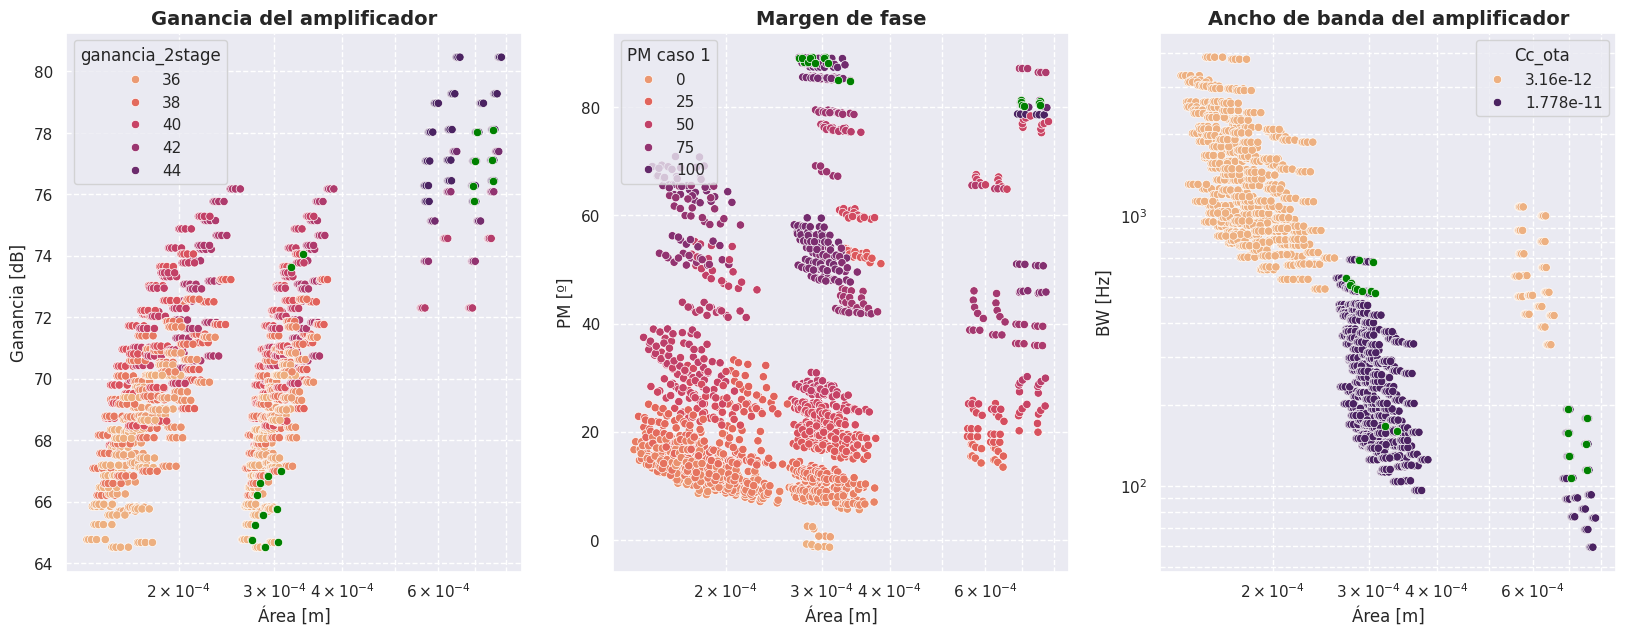

In [116]:
fig, axs = plt.subplots(1, 3, figsize=(20, 7))
sns.scatterplot(ax=axs[0], data=ota_df, x='area', y='gain', palette='flare', hue="gain_2stage", rasterized=True)
sns.scatterplot(ax=axs[0], data=ota_df_new, x='area', y='gain', color="green", rasterized=True)
sns.scatterplot(ax=axs[1], data=ota_df, x="area", y="phase_margin_OTA_wc", hue="phase_margin_OTA", palette='flare', rasterized=True)
sns.scatterplot(ax=axs[1], data=ota_df_new, x="area", y="phase_margin_OTA_wc", color="green", rasterized=True)
sns.scatterplot(ax=axs[2], data=ota_df, x="area", y="bw", hue=Symbol("Cc"), hue_norm=LogNorm(), palette='flare', rasterized=True)
sns.scatterplot(ax=axs[2], data=ota_df_new, x="area", y="bw", color="green", rasterized=True)

axs[0].set_title(r"Ganancia del amplificador", fontsize=14, weight='bold')
axs[0].set_xlabel(r"Área [m]")
axs[0].set_ylabel(r"Ganancia [dB]")
axs[0].locator_params(axis='x', nbins=10) 
axs[0].legend(loc = 'upper left')

axs[1].set_title(r"Margen de fase", fontsize=14, weight='bold')
axs[1].set_xlabel(r"Área [m]")
axs[1].set_ylabel(r"PM [º]")
axs[1].legend(loc = 'upper left')

axs[2].set_xlabel(r"Área [m]")
axs[2].set_ylabel(r"BW [Hz]")
axs[2].set_title(r"Ancho de banda del amplificador", fontsize=14, weight='bold')
axs[2].legend(loc = 'upper right')

axs[0].grid(True,which="both",ls="--")  
axs[1].grid(True,which="both",ls="--")  
axs[2].grid(True,which="both",ls="--")  

axs[0].set_xscale('log')
axs[1].set_xscale('log')
axs[2].set_xscale('log')

axs[2].set_yscale('log')

#sns.move_legend(axs[0], "upper left",title="ganancia segunda etapa")
sns.move_legend(axs[0], "upper left",title="ganancia_2stage")
sns.move_legend(axs[1], "upper left",title="PM caso 1")
sns.move_legend(axs[2], "upper right",title="Cc_ota")

plt.savefig('ota_explore_raw_3.pdf')

In [84]:
ota_df_new.to_csv("data/IHP_lv_ota_exploration3_case1_98_10_10.csv")
ota_df_wc_new.to_csv("data/IHP_lv_ota_exploration3_case2_98_10_10.csv")

# LDO

In [ ]:
ota_df_new = pd.read_csv("data/IHP_lv_ota_exploration3_case1_98_10_10.csv")
ota_df_wc_new = pd.read_csv("data/IHP_lv_ota_exploration3_case2_98_10_10.csv")

In [ ]:
OTA_primitive_wc = Primitive(
    parameters={
        Symbol("Ra"): ota_df_wc_new["rout_OTA"].values,
        Symbol("gma"): ota_df_wc_new["gm_OTA"].values,
        Symbol("Ra_1stage"): ota_df_wc_new[("Ra_1stage")].values,
        Symbol("gma_1stage"): ota_df_wc_new[("gma_1stage")].values,
        Symbol("Ra_2stage"): ota_df_wc_new[("Ra_2stage")].values,
        Symbol("gma_2stage"): ota_df_wc_new[("gma_2stage")].values,
        Symbol("Cin_2stage"): ota_df_wc_new[("Cin_2stage")].values,
        Symbol("Rc_2stage"): ota_df_wc_new[("Rc")].values,
        Symbol("Cc_2stage"): ota_df_wc_new[("Cc")].values,
    }
)

OTA_primitive_wc.outputs = {
    Symbol("W_2stage"): ota_df_wc_new[("W_2stage")].values,
    Symbol("L_2stage"): ota_df_wc_new[("L_2stage")].values,
    Symbol("vin_2stage"): ota_df_wc_new[("vin_2stage")].values,
    Symbol("W_cs_2stage"): ota_df_wc_new[("W_cs_2stage")].values,
    Symbol("L_cs_2stage"): ota_df_wc_new[("L_cs_2stage")].values,
    Symbol("vgs_cs_2stage"): ota_df_wc_new[("vgs_cs_2stage")].values,
    
    Symbol("W_diff"): ota_df_wc_new[("W_diff")].values,
    Symbol("L_diff"): ota_df_wc_new[("L_diff")].values,
    Symbol("vout_1stage"): ota_df_wc_new[("vout_1stage")].values,
    Symbol("W_al"): ota_df_wc_new[("W_al")].values,
    Symbol("L_al"): ota_df_wc_new[("L_al")].values,
    Symbol("W_cs"): ota_df_wc_new[("W_cs")].values,
    Symbol("L_cs"): ota_df_wc_new[("L_cs")].values,
    Symbol("vgs_cs"): ota_df_wc_new[("vgs_cs")].values,
}

In [ ]:
ldo_df_new

In [ ]:
ldo_df_wc_new

In [ ]:
pt_2 = Primitive(
    parameters={
        Symbol('gm_pt'): np.asarray([0.0310605956289642]),
        Symbol('Ro_pt'): np.asarray([1502.1958194630895]),
        Symbol("Cgg_pt"): np.asarray([1.5580110817282832e-12]),
        Symbol("Cgd_pt"): np.asarray([8.692283358742219e-15]),
        Symbol("Cin_pt"): np.asarray([1.9635851732796777e-12]),
        Symbol("dropout"): np.asarray([0.3267805975534815]),
        Symbol('Vota'): np.asarray([1.122222222222])
    }
)

pt_2.outputs = {
    Symbol("W_pt"): np.asarray([0.0005470250841739]),
    Symbol("L_pt"): np.asarray([4e-7])
}

pt_2_wc = Primitive(
    parameters={
        Symbol('gm_pt'): np.asarray([0.0019411907396011]),
        Symbol('Ro_pt'): np.asarray([109936.0448858981]),
        Symbol("Cgg_pt"): np.asarray([7.507718738430091e-13]),
        Symbol("Cgd_pt"): np.asarray([7.745003513700936e-16]),
        Symbol("Cin_pt"): np.asarray([9.160555404293312e-13]),
        Symbol("dropout"): np.asarray([0.0971945954880531]),
        Symbol('Vota'): np.asarray([0.077272159267986])
    }
)

pt_2_wc.outputs = {
    Symbol("W_pt"): np.asarray([0.0005470250841739]),
    Symbol("L_pt"): np.asarray([4e-7])
}

In [ ]:
Cc_primitive_LDO_2 = Primitive(
    parameters={
        Symbol("Cc"): np.asarray([3.1622776601683798e-12, 1e-12, 3.1622e-12, 1e-12]),
        Symbol("Rc"): np.asarray([1000.0, 1000, 3162, 3162])
    }
)

Cc_primitive_LDO_2.outputs = {
    Symbol("W_cc"): np.sqrt(Cc_primitive_LDO.parameters[Symbol("Cc")]/1.5e-15)*1e-6,
    Symbol("L_cc"): np.sqrt(Cc_primitive_LDO.parameters[Symbol("Cc")]/1.5e-15)*1e-6,
    Symbol("W_rc"): np.sqrt(Cc_primitive_LDO.parameters[Symbol("Rc")]/(1360*0.5))*1e-6,
    Symbol("L_rc"): np.repeat(0.5e-6, 4)
}

In [ ]:
psrr_LDO_macro.parametros = {Symbol("V1"): 1,
                             Symbol("V2"): 0,
                             Symbol("s"): 0,
                             Symbol("Cl"): CL,
                             Symbol("Rl"): 1000000000000,
                             Symbol("R1"): R1, 
                             Symbol("R2"): R2}

dc_LDO_macro.parametros = {Symbol("V1"): Vin,
                           Symbol("V2"): Vref,
                           Symbol("s"): 0,
                           Symbol("Rl"): 1000000000000,
                           Symbol("Cl"): CL,
                           Symbol("R1"): R1, 
                           Symbol("R2"): R2}

gain_ol_LDO_macro.parametros = {Symbol("V1"): 0,
                             Symbol("V2"): 0,
                             Symbol("V3"): 1,
                             Symbol("s"): 0,
                             Symbol("C1"): 10,
                             Symbol("Cl"): CL,
                             Symbol("Rl"): 1000000000000,
                             Symbol("R1"): R1, 
                             Symbol("R2"): R2,
                             Symbol("R3"): 10000000000}

phase_margin_LDO_macro.tf = ["vout", "vol"]
phase_margin_LDO_macro.netlist = "ldo_ol_pm"
phase_margin_LDO_macro.parametros = {Symbol("V1"): 1,
                             Symbol("V2"): 0,
                             Symbol("V3"): 1,
                             Symbol("C1"): 10,
                             Symbol("Cl"): CL,
                             Symbol("Rl"): 1000000000000,
                             Symbol("R1"): R1, 
                             Symbol("R2"): R2,
                             Symbol("R3"): 10000000000}

LDO_macro.ext_mask = None

LDO_macro.primitives = [OTA_primitive_wc, pt_2_wc, Cc_primitive_LDO_2]
LDO_macro.submacromodels = []
LDO_macro.num_level_exp = 1
LDO_macro.specifications = [psrr_LDO_macro, dc_LDO_macro, gain_ol_LDO_macro, phase_margin_LDO_macro]
LDO_macro.opt_specifications = [psrr_LDO_macro]
LDO_macro.is_primitive = 0
LDO_macro.run_pareto = False

_, _, _, ldo_df_wc, ldo_mask_wc = dfs(LDO_macro, debug = False)

In [ ]:
OTA_primitive = Primitive(
    parameters={
        Symbol("Ra"): ota_df_new["rout_OTA"],
        Symbol("gma"): ota_df_new["gm_OTA"],
        Symbol("Ra_1stage"): ota_df_new[("Ra_1stage")],
        Symbol("gma_1stage"): ota_df_new[("gma_1stage")],
        Symbol("Ra_2stage"): ota_df_new[("Ra_2stage")],
        Symbol("gma_2stage"): ota_df_new[("gma_2stage")],
        Symbol("Cin_2stage"): ota_df_new[("Cin_2stage")],
        Symbol("Rc_2stage"): ota_df_new[("Rc")],
        Symbol("Cc_2stage"): ota_df_new[("Cc")],
    }
)

OTA_primitive.outputs = {
    Symbol("W_2stage"): ota_df_new[("W_2stage")].values,
    Symbol("L_2stage"): ota_df_new[("L_2stage")].values,
    Symbol("vin_2stage"): ota_df_new[("vin_2stage")].values,
    Symbol("W_cs_2stage"): ota_df_new[("W_cs_2stage")].values,
    Symbol("L_cs_2stage"): ota_df_new[("L_cs_2stage")].values,
    Symbol("vgs_cs_2stage"): ota_df_new[("vgs_cs_2stage")].values,
    
    Symbol("W_diff"): ota_df_new[("W_diff")].values,
    Symbol("L_diff"): ota_df_new[("L_diff")].values,
    Symbol("vout_1stage"): ota_df_new[("vout_1stage")].values,
    Symbol("W_al"): ota_df_new[("W_al")].values,
    Symbol("L_al"): ota_df_new[("L_al")].values,
    Symbol("W_cs"): ota_df_new[("W_cs")].values,
    Symbol("L_cs"): ota_df_new[("L_cs")].values,
    Symbol("vgs_cs"): ota_df_new[("vgs_cs")].values,
}

In [ ]:
psrr_LDO_macro.parametros = {Symbol("V1"): 1,
                             Symbol("V2"): 0,
                             Symbol("s"): 0,
                             Symbol("Cl"): CL,
                             Symbol("Rl"): RL,
                             Symbol("R1"): R1, 
                             Symbol("R2"): R2}

dc_LDO_macro.parametros = {Symbol("V1"): Vin,
                           Symbol("V2"): Vref,
                           Symbol("s"): 0,
                           Symbol("Rl"): RL,
                           Symbol("Cl"): CL,
                           Symbol("R1"): R1, 
                           Symbol("R2"): R2}

gain_ol_LDO_macro.parametros = {Symbol("V1"): 0,
                             Symbol("V2"): 0,
                             Symbol("V3"): 1,
                             Symbol("s"): 0,
                             Symbol("C1"): 10,
                             Symbol("Cl"): CL,
                             Symbol("Rl"): RL,
                             Symbol("R1"): R1, 
                             Symbol("R2"): R2,
                             Symbol("R3"): 10000000000}

phase_margin_LDO_macro.tf = ["vout", "vol"]
phase_margin_LDO_macro.netlist = "ldo_ol_pm"
phase_margin_LDO_macro.parametros = {Symbol("V1"): 1,
                             Symbol("V2"): 0,
                             Symbol("V3"): 1,
                             Symbol("C1"): 10,
                             Symbol("Cl"): CL,
                             Symbol("Rl"): RL,
                             Symbol("R1"): R1, 
                             Symbol("R2"): R2,
                             Symbol("R3"): 10000000000}


LDO_macro.ext_mask = ldo_mask_wc

LDO_macro.primitives = [OTA_primitive, pt_2, Cc_primitive_LDO_2]
LDO_macro.submacromodels = []
LDO_macro.num_level_exp = 1
LDO_macro.specifications = [psrr_LDO_macro, dc_LDO_macro, gain_ol_LDO_macro, phase_margin_LDO_macro]
LDO_macro.opt_specifications = [psrr_LDO_macro]
LDO_macro.is_primitive = 0
LDO_macro.run_pareto = False

_, _, _, ldo_df, _ = dfs(LDO_macro, debug = False)

In [ ]:
ldo_df["psrr"] = 20*np.log10(ldo_df["psrr_LDO"])
ldo_df["gain_ol"] = 20*np.log10(ldo_df["gain_ol_LDO"])  
ldo_df_new = ldo_df[(ldo_df[Symbol("dropout")]<0.4) & (ldo_df["phase_margin_LDO"]>10) & (ldo_df["phase_margin_LDO"]<100)]
ldo_df_new

In [ ]:
ldo_df["psrr"] = 20*np.log10(ldo_df["psrr_LDO"])
ldo_df["psrr_wc"] = 20*np.log10(ldo_df_wc["psrr_LDO"])

ldo_df['gain_ol'] = 20*np.log10(ldo_df['gain_ol_LDO'])
ldo_df['gain_ol_wc'] = 20*np.log10(ldo_df_wc['gain_ol_LDO'])

ldo_df["Vota_wc"] = ldo_df_wc[Symbol("Vota")]
ldo_df["cin_pt_wc"] = ldo_df_wc[Symbol("Cin_pt")]

ldo_df['gmid'] = ldo_df[Symbol('gm_pt')]/pt.inputs['il']

ldo_df["phase_margin_LDO_wc"] = ldo_df_wc["phase_margin_LDO"]

ldo_df['loadreg'] = np.abs(ldo_df['dc_LDO']-ldo_df_wc['dc_LDO'])/IL

ldo_df["bw"] = 1/(2*np.pi*ldo_df[Symbol("Ra_1stage")]*(ldo_df[Symbol("Cin_pt")]+ldo_df[Symbol("gma_2stage")]*ldo_df[Symbol("Ra_2stage")]*ldo_df[Symbol("Cc_2stage")]))    
ldo_df["gain_ota"] = 20*np.log10(ldo_df[Symbol("Ra")]*ldo_df[Symbol("gma")])

#ldo_df = ldo_df[(ldo_df["gain_ota"]>20) & (ldo_df[Symbol("W_pt")]<0.6e-3) & (ldo_df[Symbol("dropout")]<0.4)]

ldo_df_new = ldo_df[((ldo_df[Symbol("dropout")]<0.4) & (ldo_df["psrr"]<-60) & (ldo_df["phase_margin_LDO_wc"]>60) & (ldo_df["bw"]>10) & (ldo_df[Symbol("W_pt")]<1e-3))]
#ldo_df_new = ldo_df
ldo_df_new.sort_values(by="area")

In [ ]:
ldo_df_wc_new = ldo_df_wc[((ldo_df[Symbol("dropout")]<0.4) & (ldo_df["psrr"]<-60) & (ldo_df["phase_margin_LDO_wc"]>60) & (ldo_df["bw"]>100) & (ldo_df[Symbol("W_pt")]<1e-3))]
ldo_df_wc_new['gain_ol'] = 20*np.log10(ldo_df_wc['gain_ol_LDO'])

In [ ]:
pareto_dict = {"area": ldo_df_new["area"].values, "pm": ldo_df_new["phase_margin_LDO_wc"].values}
pareto_df = pd.DataFrame(pareto_dict)

mask = pareto.paretoset(pareto_df, sense=["min", "max"])

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(15, 13))
sns.scatterplot(ax=axs[0,0], data=ldo_df_new, x='area', y='psrr', palette='flare', hue='gain_ota', rasterized=True, size='gmid')
sns.scatterplot(ax=axs[0,0], data=ldo_df_new[mask], x='area', y='psrr', c='green')
sns.scatterplot(ax=axs[0,1], data=ldo_df_new, x='area', y='loadreg', palette='flare', rasterized=True, hue='gain_ota', size='gmid')
sns.scatterplot(ax=axs[0,1], data=ldo_df_new[mask], x='area', y='loadreg', c='green')
sns.scatterplot(ax=axs[1,1], data=ldo_df_new, x='area', y=Symbol('dropout'), palette='flare', hue='gmid', rasterized=True, size=Symbol('L_pt'))
sns.scatterplot(ax=axs[1,1], data=ldo_df_new[mask], x='area', y=Symbol('dropout'), c='green')
sns.scatterplot(ax=axs[1,0], data=ldo_df_new, x='area', y="phase_margin_LDO_wc", palette='flare', hue="gain_ota", rasterized=True, size='gmid')
sns.scatterplot(ax=axs[1,0], data=ldo_df_new[mask], x='area', y="phase_margin_LDO_wc", c='green')

axs[0,0].set_title(r"Rechazo de la Fuente de Alimentación", fontsize=14, weight='bold')
axs[0,0].set_xlabel(r"Area")
axs[0,0].set_ylabel(r"Psrr [dB]")
axs[0,0].locator_params(axis='x', nbins=10) 
axs[0,0].legend(loc = 'upper right')

axs[0,1].set_title(r"Regulacion de Carga", fontsize=14, weight='bold')
axs[0,1].set_xlabel(r"Area")
axs[0,1].set_ylabel(r"Regulacion de Carga [V]")
axs[0,1].legend(loc = 'upper right')

axs[1,1].set_xlabel(r"Area")
axs[1,1].set_ylabel(r"Dropout [V]")
axs[1,1].set_title(r"Caida de voltaje sobre Transistor de paso", fontsize=14, weight='bold')
axs[1,1].legend(loc = 'upper right')

axs[1,0].set_title(r"Margen de fase", fontsize=14, weight='bold')
axs[1,0].set_xlabel(r"Area")
axs[1,0].set_ylabel(r"PM [º]")
axs[1,0].legend(loc = 'upper right')
#fig.suptitle(r"Ganancias intrínsecas", fontsize=24, y=1.1)

axs[0,0].set_xscale('log')
axs[0,1].set_xscale('log')
axs[1,0].set_xscale('log')
axs[1,1].set_xscale('log')

axs[0,1].set_yscale('log')



axs[0,0].grid(True,which="both",ls="--")  
axs[0,1].grid(True,which="both",ls="--")  
axs[1,0].grid(True,which="both",ls="--")  
axs[1,1].grid(True,which="both",ls="--")  

sns.move_legend(axs[0,0], "upper right")
sns.move_legend(axs[0,1], "upper right")
sns.move_legend(axs[1,0], "lower right")
sns.move_legend(axs[1,1], "upper right")

plt.savefig('ldo_explore_raw_2.pdf')

In [ ]:
ldo_df_new[mask].to_csv("data/IHP_lv_ldo_final_98_10_10.csv")

In [ ]:
ldo_df_new[mask]

In [ ]:
ldo_df_wc_new[mask]

In [185]:
sim_ol_case2 = pd.read_csv("simulations/sim_ol_case2.csv", sep="\s+")
ss_ol_case2 = pd.read_csv("simulations/ss_ol_caso2.csv", sep="\s+")

sim_ol_case2.columns = ["f", "gain_ol", "f2", "phase_margin_ol"]
ss_ol_case2.columns = ["f", "gain_ol", "f2", "phase_margin_ol"]

In [186]:
abs_gain = np.abs(sim_ol_case2["gain_ol"])
sim_ol_case2["phase_margin_ol"][np.argmin(abs_gain)]

np.float64(58.8859859)

In [187]:
abs_gain = np.abs(ss_ol_case2["gain_ol"])
ss_ol_case2["phase_margin_ol"][np.argmin(abs_gain)]

np.float64(78.268465)

In [188]:
(78-58)/58

0.3448275862068966

In [189]:
sim_cl_case1 = pd.read_csv("simulations/sim_cl_case1.csv", sep="\s+")
ss_cl_case1 = pd.read_csv("simulations/ss_cl_caso2.csv", sep="\s+")

sim_cl_case1.columns = ["f", "gain_ol", "f2", "phase_margin_ol"]
ss_cl_case1.columns = ["f", "gain_ol", "f2", "phase_margin_ol"]

In [190]:
sim_cl_case1_dropout = pd.read_csv("simulations/sim_cl_case1_dropout.csv", sep="\s+")

sim_cl_case1_dropout.columns = ["f", "vout", "f2", "vdd"]

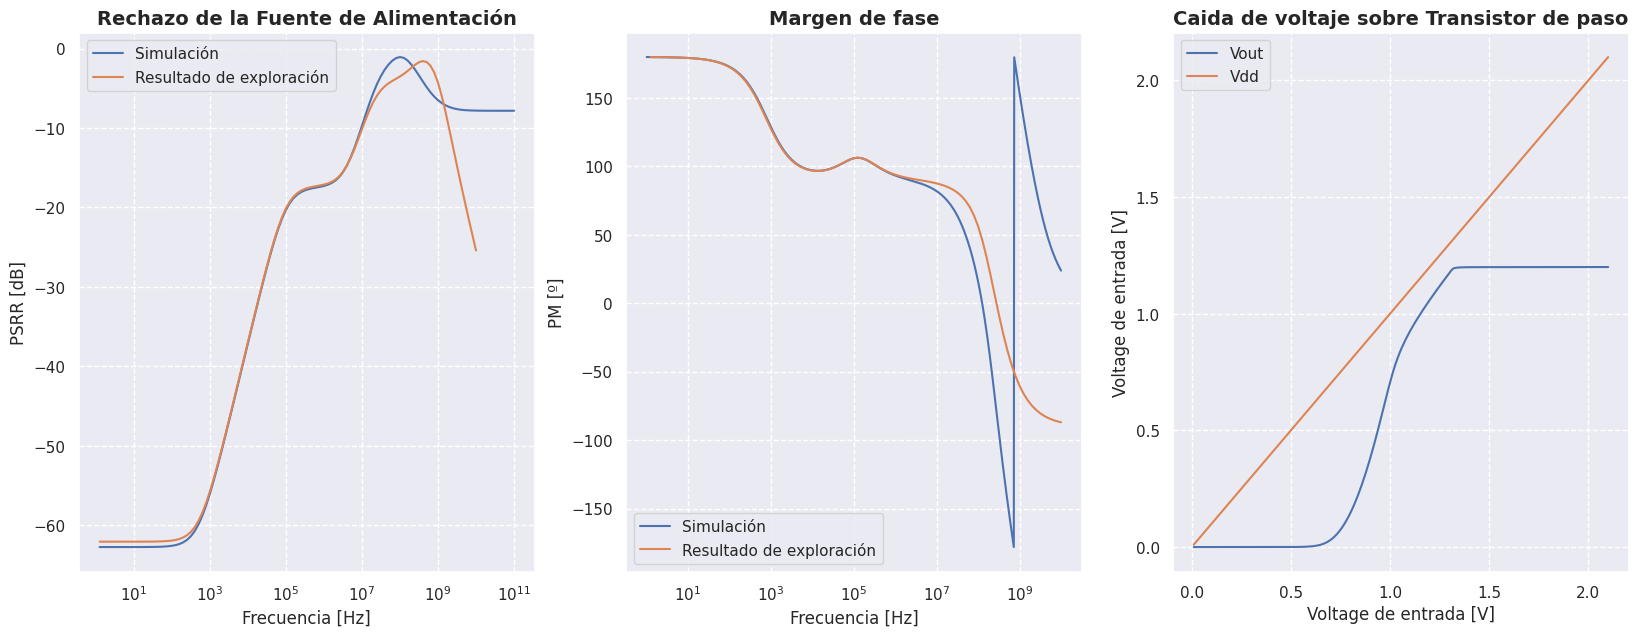

In [196]:
fig, axs = plt.subplots(1, 3, figsize=(20, 7))
sns.lineplot(ax=axs[0], data=sim_cl_case1, x="f", y="gain_ol", label="Simulación")
sns.lineplot(ax=axs[0], data=ss_cl_case1, x="f", y="gain_ol", label="Resultado de exploración")
#sns.lineplot(ax=axs[0,1], data=sim_ol_case2, x="f", y="gain_ol", label="Simulación")
#sns.lineplot(ax=axs[0,1], data=ss_ol_case2, x="f", y="gain_ol", label="Resultado de exploración")
sns.lineplot(ax=axs[1], data=sim_ol_case2, x="f", y="phase_margin_ol", label="Simulación")
sns.lineplot(ax=axs[1], data=ss_ol_case2, x="f", y="phase_margin_ol", label="Resultado de exploración")
sns.lineplot(ax=axs[2], data=sim_cl_case1_dropout, x="f", y="vout", label="Vout")
sns.lineplot(ax=axs[2], data=sim_cl_case1_dropout, x="f", y="vdd", label="Vdd")

axs[0].set_title(r"Rechazo de la Fuente de Alimentación", fontsize=14, weight='bold')
axs[0].set_xlabel(r"Frecuencia [Hz]")
axs[0].set_ylabel(r"PSRR [dB]")
axs[0].locator_params(axis='x', nbins=10) 
axs[0].legend(loc = 'upper right')

#axs[0,1].set_title(r"Ganancia de lazo abierto", fontsize=14, weight='bold')
#axs[0,1].set_xlabel(r"Frecuencia [Hz]")
#axs[0,1].set_ylabel(r"Regulacion de Carga [V]")
#axs[0,1].legend(loc = 'upper right')

axs[2].set_xlabel(r"Voltage de entrada [V]")
axs[2].set_ylabel(r"Voltage de entrada [V]")
axs[2].set_title(r"Caida de voltaje sobre Transistor de paso", fontsize=14, weight='bold')
axs[2].legend(loc = 'upper right')

axs[1].set_title(r"Margen de fase", fontsize=14, weight='bold')
axs[1].set_xlabel(r"Frecuencia [Hz]")
axs[1].set_ylabel(r"PM [º]")
axs[1].legend(loc = 'upper right')
#fig.suptitle(r"Ganancias intrínsecas", fontsize=24, y=1.1)

axs[0].set_xscale('log')
#axs[0,1].set_xscale('log')
axs[1].set_xscale('log')

axs[0].grid(True,which="both",ls="--")  
#axs[0,1].grid(True,which="both",ls="--")  
axs[1].grid(True,which="both",ls="--")  
axs[2].grid(True,which="both",ls="--")  


sns.move_legend(axs[0], "upper left")
#sns.move_legend(axs[0,1], "upper right")
sns.move_legend(axs[1], "lower left")
sns.move_legend(axs[2], "upper left")

plt.savefig('comp.pdf')

In [123]:
sky_ldo_final = pd.read_csv("data/SKY_lv_ldo_final_98_10_10.csv")
ihp_ldo_final = pd.read_csv("data/IHP_lv_ldo_final_98_10_10.csv")
gf_ldo_final = pd.read_csv("data/GF_lv_ldo_final_98_10_10.csv")

In [124]:
gf_ldo_final_telescopica = pd.read_csv("data/GF_lv_ldo_final_98_10_10_telescopica.csv")
ihp_ldo_final_telescopica = pd.read_csv("data/IHP_lv_ldo_explore2_topo3.csv")

In [125]:
gf_ldo_final_ccdiff = pd.read_csv("data/GF_lv_ldo_final_98_10_10_ccdiff.csv")

In [130]:
sky_ldo_final["Tecnología"] = "SKY"
ihp_ldo_final["Tecnología"] = "IHP"
gf_ldo_final["Tecnología"] = "GF"

gf_ldo_final_telescopica["Tecnología"] = "GF"
ihp_ldo_final_telescopica["Tecnología"] = "IHP"

gf_ldo_final_ccdiff["Tecnología"] = "GF"

In [131]:
sky_ldo_final["Topología de amplificador"] = "OTA simple"
ihp_ldo_final["Topología de amplificador"] = "OTA simple"
gf_ldo_final["Topología de amplificador"] = "OTA simple"

gf_ldo_final_telescopica["Topología de amplificador"] = "Telescopica"
ihp_ldo_final_telescopica["Topología de amplificador"] = "Telescopica"

gf_ldo_final_ccdiff["Topología de amplificador"] = "OTA simple con par diferencial cascode"

In [132]:


results = pd.concat([sky_ldo_final, ihp_ldo_final, gf_ldo_final, gf_ldo_final_telescopica, gf_ldo_final_ccdiff], ignore_index=True)

In [133]:
results

Unnamed: 0            Ra       gma     Ra_1stage  gma_1stage  \
0            0  4.698793e+05  0.005928  1.429260e+06    0.000054   
1            3  4.698793e+05  0.005928  1.429260e+06    0.000054   
2           16  4.802471e+05  0.003605  2.684094e+05    0.000114   
3           44  4.802471e+05  0.003503  2.293791e+05    0.000129   
4            8  6.703565e+05  0.008597  6.739734e+05    0.000110   
5           44  1.017716e+06  0.008597  6.739860e+05    0.000110   
6          921  2.077321e+07  0.000112           NaN         NaN   
7          923  2.077321e+07  0.000112           NaN         NaN   
8          289  1.314968e+07  0.000104           NaN         NaN   
9          291  1.314968e+07  0.000104           NaN         NaN   
10         339  1.442640e+07  0.000118           NaN         NaN   

       Ra_2stage  gma_2stage    Cin_2stage  Rc_2stage     Cc_2stage  ...  \
0   4.698793e+05    0.000077  1.781634e-14   100000.0  3.162278e-12  ...   
1   4.698793e+05    0.000077  1.781634e-14   100000.0  3.162278e-12  ...   
2   4.802471e+05    0.000118  1.199986e-14   100000.0  1.778279e-11  ...   
3   4.802471e+05    0.000118  1.199986e-14   100000.0  1.778279e-11  ...   
4   6.703565e+05    0.000116  1.346076e-14   100000.0  3.162278e-12  ...   
5   1.017716e+06    0.000116  1.346076e-14   100000.0  3.162278e-12  ...   
6            NaN         NaN           NaN        NaN           NaN  ...   
7            NaN         NaN           NaN        NaN           NaN  ...   
8            NaN         NaN           NaN        NaN           NaN  ...   
9            NaN         NaN           NaN        NaN           NaN  ...   
10           NaN         NaN           NaN        NaN           NaN  ...   

    W_diff_m1     L_diff_m1  W_diff_m2     L_diff_m2  W_aload_m1  \
0         NaN           NaN        NaN           NaN         NaN   
1         NaN           NaN        NaN           NaN         NaN   
2         NaN           NaN        NaN           NaN         NaN   
3         NaN           NaN        NaN           NaN         NaN   
4         NaN           NaN        NaN           NaN         NaN   
5         NaN           NaN        NaN           NaN         NaN   
6    0.000003  4.000000e-07   0.000201  8.000000e-07    0.000004   
7    0.000003  4.000000e-07   0.000201  8.000000e-07    0.000004   
8    0.000018  3.200000e-06   0.000091  4.000000e-07         NaN   
9    0.000018  3.200000e-06   0.000091  4.000000e-07         NaN   
10   0.000005  8.000000e-07   0.000091  4.000000e-07         NaN   

      L_aload_m1  W_aload_m2    L_aload_m2   W_aload   L_aload  
0            NaN         NaN           NaN       NaN       NaN  
1            NaN         NaN           NaN       NaN       NaN  
2            NaN         NaN           NaN       NaN       NaN  
3            NaN         NaN           NaN       NaN       NaN  
4            NaN         NaN           NaN       NaN       NaN  
5            NaN         NaN           NaN       NaN       NaN  
6   8.000000e-07    0.000006  8.000000e-07       NaN       NaN  
7   8.000000e-07    0.000006  8.000000e-07       NaN       NaN  
8            NaN         NaN           NaN  0.000019  0.000003  
9            NaN         NaN           NaN  0.000019  0.000003  
10           NaN         NaN           NaN  0.000039  0.000006  

[11 rows x 69 columns]

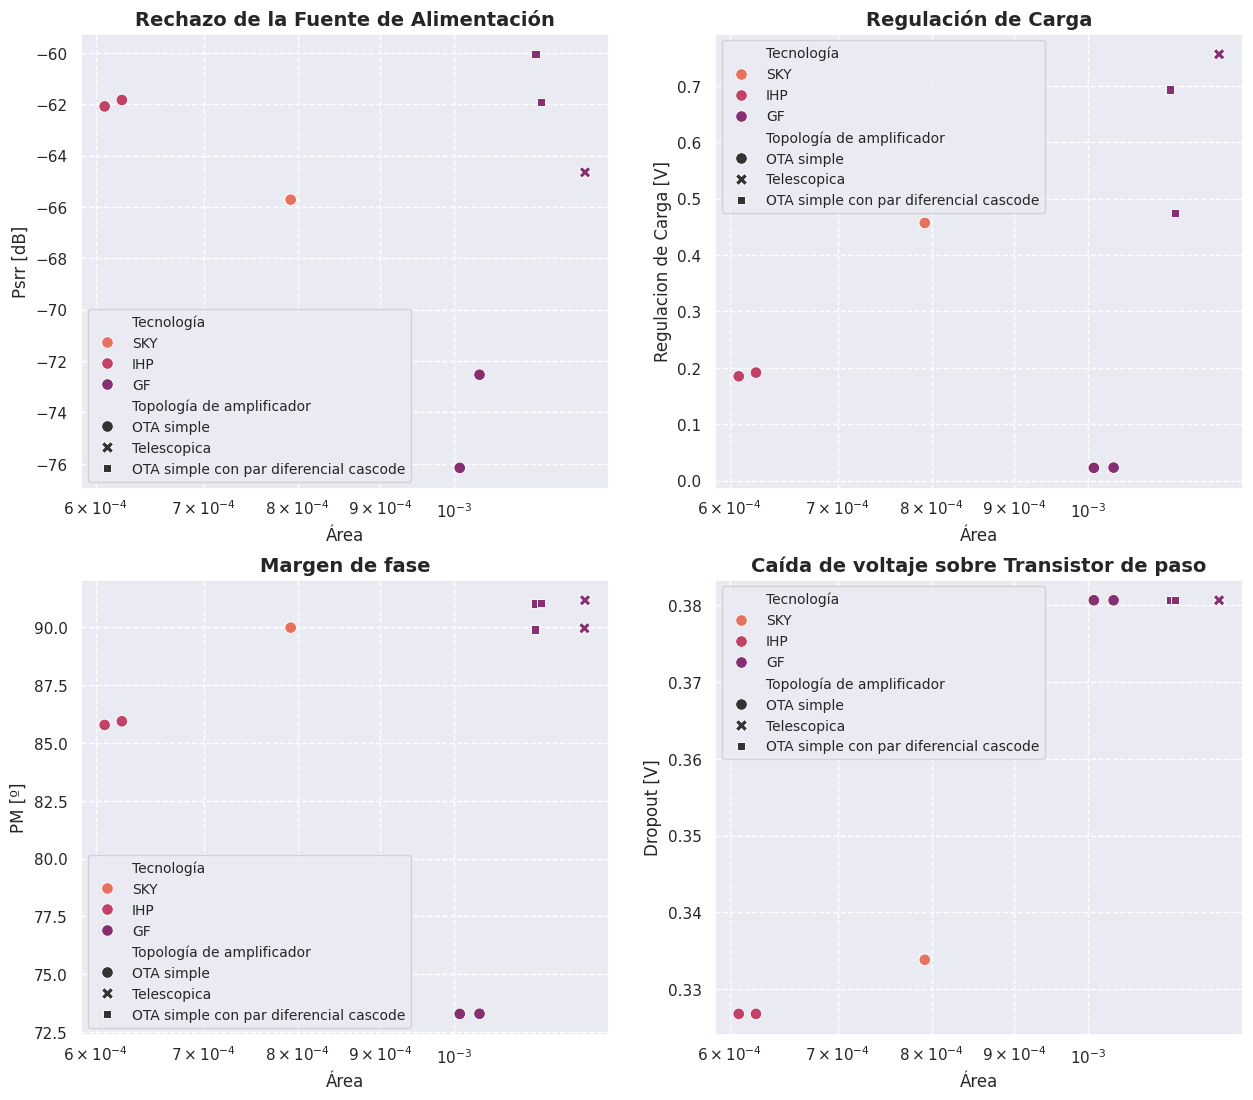

In [149]:
fig, axs = plt.subplots(2, 2, figsize=(15, 13))
sns.scatterplot(ax=axs[0,0], data=results, x='area', y='psrr', palette='flare', hue='Tecnología', rasterized=True, style='Topología de amplificador', s=70)
#sns.scatterplot(ax=axs[0,0], data=ldo_df_new[mask], x='area', y='psrr', c='green')
sns.scatterplot(ax=axs[0,1], data=results, x='area', y='loadreg', palette='flare',hue='Tecnología', rasterized=True, style='Topología de amplificador', s=70)
#sns.scatterplot(ax=axs[0,1], data=ldo_df_new[mask], x='area', y='loadreg', c='green')
sns.scatterplot(ax=axs[1,1], data=results, x='area', y=('dropout'), palette='flare', hue='Tecnología', rasterized=True, style='Topología de amplificador', s=70)
#sns.scatterplot(ax=axs[1,1], data=ldo_df_new[mask], x='area', y=Symbol('dropout'), c='green')
sns.scatterplot(ax=axs[1,0], data=results, x='area', y="phase_margin_LDO_wc", palette='flare',hue='Tecnología', rasterized=True, style='Topología de amplificador', s=70)
#sns.scatterplot(ax=axs[1,0], data=ldo_df_new[mask], x='area', y="phase_margin_LDO_wc", c='green')

axs[0,0].set_title(r"Rechazo de la Fuente de Alimentación", fontsize=14, weight='bold')
axs[0,0].set_xlabel(r"Área")
axs[0,0].set_ylabel(r"Psrr [dB]")
axs[0,0].locator_params(axis='x', nbins=10) 
axs[0,0].legend(loc = 'upper right')

axs[0,1].set_title(r"Regulación de Carga", fontsize=14, weight='bold')
axs[0,1].set_xlabel(r"Área")
axs[0,1].set_ylabel(r"Regulacion de Carga [V]")
axs[0,1].legend(loc = 'upper right')

axs[1,1].set_xlabel(r"Área")
axs[1,1].set_ylabel(r"Dropout [V]")
axs[1,1].set_title(r"Caída de voltaje sobre Transistor de paso", fontsize=14, weight='bold')
axs[1,1].legend(loc = 'upper right')

axs[1,0].set_title(r"Margen de fase", fontsize=14, weight='bold')
axs[1,0].set_xlabel(r"Área")
axs[1,0].set_ylabel(r"PM [º]")
axs[1,0].legend(loc = 'upper right')
#fig.suptitle(r"Ganancias intrínsecas", fontsize=24, y=1.1)

axs[0,0].set_xscale('log')
axs[0,1].set_xscale('log')
axs[1,0].set_xscale('log')
axs[1,1].set_xscale('log')

#axs[0,1].set_yscale('log')



axs[0,0].grid(True,which="both",ls="--")  
axs[0,1].grid(True,which="both",ls="--")  
axs[1,0].grid(True,which="both",ls="--")  
axs[1,1].grid(True,which="both",ls="--")  

sns.move_legend(axs[0,0], "lower left", fontsize=10)
sns.move_legend(axs[0,1], "upper left", fontsize=10)
sns.move_legend(axs[1,0], "lower left", fontsize=10)
sns.move_legend(axs[1,1], "upper left", fontsize=10)

plt.savefig('final.pdf')

In [ ]:
sky_ldo_final.sort_values(by="area")

In [ ]:
gf_ldo_final.sort_values(by="area")

In [204]:
MNA_timing_1 = {'psrr_LDO': 0.03435707092285156, 'dc_LDO': 0.026358842849731445, 'gain_ol_LDO': 0.022366046905517578}
MNA_timing_2 = {'gain_OTA': 0.031392574310302734, 'rout_OTA': 0.029086828231811523, 'gm_OTA': 0.02180194854736328}
MNA_timing_3 = {'gain_1stage': 0.03394150733947754, 'rout_1stage': 0.025109529495239258, 'gm_1stage': 0.021559953689575195}
MNA_timing_4 = {'gain_OTA': 0.04286527633666992, 'rout_OTA': 0.027439117431640625, 'gm_OTA': 0.03298044204711914}
MNA_timing_5 = {'gain_2stage': 0.02648162841796875, 'rout_2stage': 0.03206276893615723, 'gm_2stage': 0.02405238151550293}
MNA_timing_6 = {'gain_OTA': 0.030135393142700195, 'rout_OTA': 0.02564406394958496, 'gm_OTA': 0.01954817771911621}
MNA_timing_7 = {'psrr_LDO': 0.12704873085021973, 'dc_LDO': 0.020874977111816406, 'gain_ol_LDO': 0.03919243812561035}

explore_timing_1 = {'psrr_LDO': 0.005555629730224609, 'dc_LDO': 0.00494384765625, 'gain_ol_LDO': 0.003154754638671875}
explore_timing_2 = {'gain_OTA': 0.172410249710083, 'rout_OTA': 0.15409374237060547, 'gm_OTA': 0.001}
explore_timing_3 = {'gain_1stage': 1.9614417552947998, 'rout_1stage': 1.872131586074829, 'gm_1stage': 0.001}
explore_timing_4 = {'gain_OTA': 3.201221227645874, 'rout_OTA': 3.2679336071014404, 'gm_OTA': 0.001}
explore_timing_5 = {'gain_2stage': 0.003532886505126953, 'rout_2stage': 0.010172843933105469, 'gm_2stage': 0.001}
explore_timing_6 = {'gain_OTA': 0.4191153049468994, 'rout_OTA': 0.39537644386291504, 'gm_OTA': 0.001}
explore_timing_7 = {'psrr_LDO': 0.006161212921142578, 'dc_LDO': 0.0053217411041259766, 'gain_ol_LDO': 0.005120992660522461}

In [205]:
MNA_total_1 = sum(MNA_timing_1.values())
MNA_total_2 = sum(MNA_timing_2.values())
MNA_total_3 = sum(MNA_timing_3.values())
MNA_total_4 = sum(MNA_timing_4.values())
MNA_total_5 = sum(MNA_timing_5.values())
MNA_total_6 = sum(MNA_timing_6.values())
MNA_total_7 = sum(MNA_timing_7.values())

explore_total_1 = sum(explore_timing_1.values())
explore_total_2 = sum(explore_timing_2.values())
explore_total_3 = sum(explore_timing_3.values())
explore_total_4 = sum(explore_timing_4.values())
explore_total_5 = sum(explore_timing_5.values())
explore_total_6 = sum(explore_timing_6.values())
explore_total_7 = sum(explore_timing_7.values())

n_evaluations_1 = 45000
n_evaluations_2 = 312000
n_evaluations_3 = 825000
n_evaluations_4 = 1281250
n_evaluations_5 = 3125
n_evaluations_6 = 188600
n_evaluations_7 = 76

timing_total_1 = MNA_total_1 + explore_total_1
timing_total_2 = MNA_total_2 + explore_total_2
timing_total_3 = MNA_total_3 + explore_total_3
timing_total_4 = MNA_total_4 + explore_total_4
timing_total_5 = MNA_total_5 + explore_total_5
timing_total_6 = MNA_total_6 + explore_total_6
timing_total_7 = MNA_total_7 + explore_total_7

In [206]:
timing_df = pd.DataFrame.from_dict({"MNA": {'t1': MNA_total_1, 't2': MNA_total_2, 't3': MNA_total_3, 't4': MNA_total_4,'t5': MNA_total_5, 't6': MNA_total_6, 't7': MNA_total_7},
                                    "explore": {'t1': explore_total_1, 't2': explore_total_2, 't3': explore_total_3, 't4': explore_total_4,'t5': explore_total_5, 't6': explore_total_6, 't7': explore_total_7},
                                    "total": {'t1': timing_total_1, 't2': timing_total_2, 't3': timing_total_3, 't4': timing_total_4,'t5': timing_total_5, 't6': timing_total_6, 't7': timing_total_7},
                                    "n_evaluations": {'t1': n_evaluations_1, 't2': n_evaluations_2, 't3': n_evaluations_3, 't4': n_evaluations_4,'t5': n_evaluations_5, 't6': n_evaluations_6, 't7': n_evaluations_7}})
timing_df.sort_values(by="total")

MNA   explore     total  n_evaluations
t1  0.083082  0.013654  0.096736          45000
t5  0.082597  0.014706  0.097303           3125
t7  0.187116  0.016604  0.203720             76
t2  0.082281  0.327504  0.409785         312000
t6  0.075328  0.815492  0.890819         188600
t3  0.080611  3.834573  3.915184         825000
t4  0.103285  6.470155  6.573440        1281250

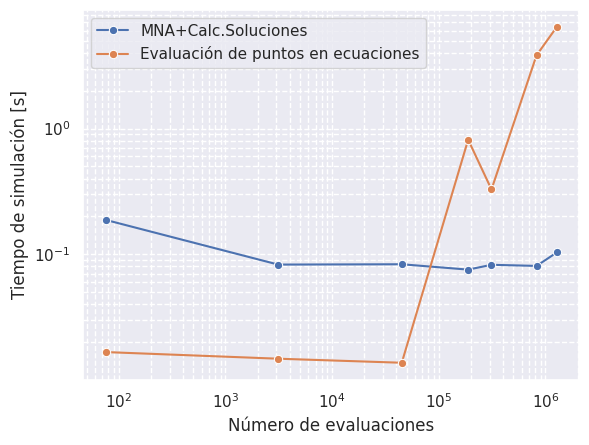

In [214]:
sns.lineplot(data=timing_df, x="n_evaluations", y='MNA', marker='o', label="MNA+Calc.Soluciones")
sns.lineplot(data=timing_df, x="n_evaluations", y='explore', marker='o', label="Evaluación de puntos en ecuaciones")
#sns.lineplot(data=timing_df, x="n_evaluations", y='total', color="green")

plt.xlabel(r"Número de evaluaciones")
plt.ylabel(r"Tiempo de simulación [s]")

plt.xscale("log")
plt.yscale("log")

plt.grid(True,which="both",ls="--")

plt.savefig("timing.pdf")